# Data analysis of the face Verification dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("juice0lover/face-identification")

print("Path to dataset files:", path)

100%|██████████| 10.6M/10.6M [00:00<00:00, 32.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/juice0lover/face-identification/versions/5


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_curve, auc)
from keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from keras.models import Model
from sklearn.decomposition import PCA
data_path = '/root/.cache/kagglehub/datasets/juice0lover/face-identification/versions/5/faces'
df = pd.read_csv("/root/.cache/kagglehub/datasets/juice0lover/face-identification/versions/5/face_identification.csv")

In [3]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/juice0lover/face-identification/versions/5/face_identification.csv")
print(f"Dataset size: {df.shape}")
print("\nFirst 5 lines:")
df.head()

Dataset size: (6657, 3)

First 5 lines:


,image_1,image_2,target
0,faces/Aaron Paul/cropped_Aaron Paul_1.jpg,faces/Aaron Paul/cropped_Aaron Paul_2.jpg,1
1,faces/Aaron Paul/cropped_Aaron Paul_1.jpg,faces/Aaron Paul/cropped_Aaron Paul_3.jpg,1
2,faces/Aaron Paul/cropped_Aaron Paul_1.jpg,faces/Aaron Paul/cropped_Aaron Paul_4.jpg,1
3,faces/Aaron Paul/cropped_Aaron Paul_1.jpg,faces/Aaron Paul/cropped_Aaron Paul_5.jpg,1
4,faces/Aaron Paul/cropped_Aaron Paul_1.jpg,faces/Aaron Paul/cropped_Aaron Paul_6.jpg,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6657 entries, 0 to 6656
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image_1  6657 non-null   object
 1   image_2  6657 non-null   object
 2   target   6657 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 156.2+ KB


In [5]:
print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
0    3339
1    3318
Name: count, dtype: int64


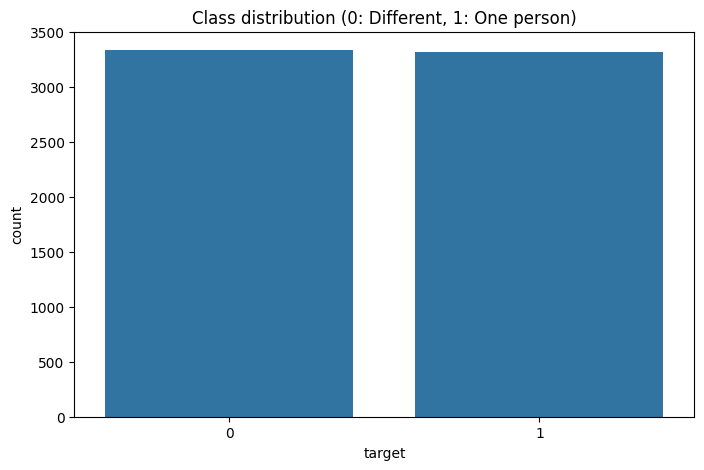

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df)
plt.title('Class distribution (0: Different, 1: One person)')
plt.show()


# ResNet50 vs VGG16 + Model Comparison

In [8]:
# Loading models
vgg_model = VGG16(weights='imagenet')
vgg_feature_extractor = Model(inputs=vgg_model.input,
                             outputs=vgg_model.get_layer('fc2').output)

resnet_model = ResNet50(weights='imagenet')
resnet_feature_extractor = Model(inputs=resnet_model.input,
                                outputs=resnet_model.get_layer('avg_pool').output)

def extract_features(image_path, model_type='vgg'):
    """Extracting features from an image"""
    try:
        if image_path.startswith('faces/'):
            full_path = os.path.join(data_path, image_path[len('faces/'):])
        else:
            full_path = os.path.join(data_path, image_path)

        img = Image.open(full_path)
        img = img.resize((224, 224))

        if len(np.array(img).shape) == 2:
            img = np.stack((img,)*3, axis=-1)

        if model_type == 'vgg':
            img = vgg_preprocess(np.array(img))
            model = vgg_feature_extractor
        else:  # resnet
            img = resnet_preprocess(np.array(img))
            model = resnet_feature_extractor

        img = np.expand_dims(img, axis=0)
        features = model.predict(img)
        return features.flatten()
    except Exception as e:
        print(f"Processing error {image_path}: {str(e)}")
        return None

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Feature extraction for both models
def extract_all_features():
    vgg_features = {}
    resnet_features = {}

    unique_images = pd.concat([df['image_1'], df['image_2']]).unique()

    print("Извлечение признаков VGG16...")
    for img_path in tqdm(unique_images):
        if img_path not in vgg_features:
            vgg_features[img_path] = extract_features(img_path, 'vgg')

    print("\nИзвлечение признаков ResNet50...")
    for img_path in tqdm(unique_images):
        if img_path not in resnet_features:
            resnet_features[img_path] = extract_features(img_path, 'resnet')

    return vgg_features, resnet_features

vgg_features, resnet_features = extract_all_features()

Извлечение признаков VGG16...


  0%|          | 0/1912 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 1/1912 [00:01<48:09,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 2/1912 [00:02<46:39,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 3/1912 [00:04<48:04,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 4/1912 [00:05<47:12,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


  0%|          | 5/1912 [00:06<39:05,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  0%|          | 6/1912 [00:07<33:12,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  0%|          | 7/1912 [00:08<29:28,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  0%|          | 8/1912 [00:08<27:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


  0%|          | 9/1912 [00:09<25:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


  1%|          | 10/1912 [00:10<30:38,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  1%|          | 11/1912 [00:12<34:52,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


  1%|          | 12/1912 [00:12<31:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  1%|          | 13/1912 [00:13<27:54,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


  1%|          | 14/1912 [00:14<26:07,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


  1%|          | 15/1912 [00:14<24:54,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


  1%|          | 16/1912 [00:15<24:03,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  1%|          | 17/1912 [00:16<22:41,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


  1%|          | 18/1912 [00:17<22:26,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


  1%|          | 19/1912 [00:17<22:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


  1%|          | 20/1912 [00:18<22:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


  1%|          | 21/1912 [00:19<22:01,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  1%|          | 22/1912 [00:19<21:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  1%|          | 23/1912 [00:20<21:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  1%|▏         | 24/1912 [00:21<21:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


  1%|▏         | 25/1912 [00:21<21:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


  1%|▏         | 26/1912 [00:22<20:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  1%|▏         | 27/1912 [00:25<39:29,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


  1%|▏         | 28/1912 [00:25<34:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


  2%|▏         | 29/1912 [00:26<30:39,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


  2%|▏         | 30/1912 [00:27<28:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  2%|▏         | 31/1912 [00:27<26:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  2%|▏         | 32/1912 [00:28<24:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


  2%|▏         | 33/1912 [00:29<23:43,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


  2%|▏         | 34/1912 [00:29<23:11,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  2%|▏         | 35/1912 [00:30<22:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


  2%|▏         | 36/1912 [00:31<21:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  2%|▏         | 37/1912 [00:31<21:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  2%|▏         | 38/1912 [00:32<20:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  2%|▏         | 39/1912 [00:33<20:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  2%|▏         | 40/1912 [00:33<19:31,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  2%|▏         | 41/1912 [00:34<20:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


  2%|▏         | 42/1912 [00:35<21:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  2%|▏         | 43/1912 [00:37<41:49,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  2%|▏         | 44/1912 [00:39<43:12,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 45/1912 [00:40<43:27,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 46/1912 [00:42<43:55,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 47/1912 [00:43<42:30,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 48/1912 [00:44<42:25,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


  3%|▎         | 49/1912 [00:46<43:52,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


  3%|▎         | 50/1912 [00:47<37:09,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


  3%|▎         | 51/1912 [00:47<31:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


  3%|▎         | 52/1912 [00:48<28:30,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


  3%|▎         | 53/1912 [00:49<32:16,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  3%|▎         | 54/1912 [00:52<48:56,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


  3%|▎         | 55/1912 [00:54<47:19,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


  3%|▎         | 56/1912 [00:55<46:03,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  3%|▎         | 57/1912 [00:56<37:48,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  3%|▎         | 58/1912 [00:56<32:52,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  3%|▎         | 59/1912 [00:57<28:45,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


  3%|▎         | 60/1912 [00:58<26:37,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


  3%|▎         | 61/1912 [00:58<25:06,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


  3%|▎         | 62/1912 [01:00<29:55,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


  3%|▎         | 63/1912 [01:00<27:23,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


  3%|▎         | 64/1912 [01:01<25:36,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


  3%|▎         | 65/1912 [01:02<30:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


  3%|▎         | 66/1912 [01:03<30:56,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


  4%|▎         | 67/1912 [01:05<34:34,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


  4%|▎         | 68/1912 [01:06<30:36,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


  4%|▎         | 69/1912 [01:06<27:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


  4%|▎         | 70/1912 [01:07<25:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


  4%|▎         | 71/1912 [01:08<24:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


  4%|▍         | 72/1912 [01:09<29:40,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


  4%|▍         | 73/1912 [01:10<33:26,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


  4%|▍         | 74/1912 [01:12<36:10,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


  4%|▍         | 75/1912 [01:13<38:06,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


  4%|▍         | 76/1912 [01:14<32:42,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


  4%|▍         | 77/1912 [01:15<35:17,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


  4%|▍         | 78/1912 [01:17<37:12,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


  4%|▍         | 79/1912 [01:17<32:30,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  4%|▍         | 80/1912 [01:18<29:01,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


  4%|▍         | 81/1912 [01:19<26:36,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


  4%|▍         | 82/1912 [01:20<28:24,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  4%|▍         | 83/1912 [01:21<30:01,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  4%|▍         | 84/1912 [01:22<33:15,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


  4%|▍         | 85/1912 [01:23<29:39,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  4%|▍         | 86/1912 [01:24<27:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


  5%|▍         | 87/1912 [01:24<25:02,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


  5%|▍         | 88/1912 [01:25<23:44,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  5%|▍         | 89/1912 [01:26<22:55,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


  5%|▍         | 90/1912 [01:26<22:29,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


  5%|▍         | 91/1912 [01:28<27:58,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▍         | 92/1912 [01:29<32:30,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▍         | 93/1912 [01:30<34:50,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


  5%|▍         | 94/1912 [01:32<36:59,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


  5%|▍         | 95/1912 [01:33<34:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


  5%|▌         | 96/1912 [01:33<29:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  5%|▌         | 97/1912 [01:34<26:12,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  5%|▌         | 98/1912 [01:34<23:45,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


  5%|▌         | 99/1912 [01:35<22:37,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


  5%|▌         | 100/1912 [01:36<22:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  5%|▌         | 101/1912 [01:39<39:48,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  5%|▌         | 102/1912 [01:42<55:05,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  5%|▌         | 103/1912 [01:44<1:03:31,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


  5%|▌         | 104/1912 [01:46<56:11,  1.87s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


  5%|▌         | 105/1912 [01:47<51:52,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  6%|▌         | 106/1912 [01:49<52:53,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 107/1912 [01:52<1:01:52,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


  6%|▌         | 108/1912 [01:52<49:40,  1.65s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


  6%|▌         | 109/1912 [01:53<41:01,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  6%|▌         | 110/1912 [01:54<34:54,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


  6%|▌         | 111/1912 [01:54<30:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


  6%|▌         | 112/1912 [01:56<33:51,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


  6%|▌         | 113/1912 [01:57<36:01,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step


  6%|▌         | 114/1912 [01:58<37:14,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


  6%|▌         | 115/1912 [02:00<38:38,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


  6%|▌         | 116/1912 [02:01<39:28,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


  6%|▌         | 117/1912 [02:03<40:13,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


  6%|▌         | 118/1912 [02:03<34:22,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


  6%|▌         | 119/1912 [02:04<30:38,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


  6%|▋         | 120/1912 [02:05<27:44,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


  6%|▋         | 121/1912 [02:05<25:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


  6%|▋         | 122/1912 [02:06<23:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


  6%|▋         | 123/1912 [02:07<22:49,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


  6%|▋         | 124/1912 [02:08<28:03,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  7%|▋         | 125/1912 [02:09<29:29,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


  7%|▋         | 126/1912 [02:11<33:05,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


  7%|▋         | 127/1912 [02:11<29:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  7%|▋         | 128/1912 [02:12<25:56,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  7%|▋         | 129/1912 [02:13<24:19,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  7%|▋         | 130/1912 [02:13<22:24,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  7%|▋         | 131/1912 [02:14<21:50,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  7%|▋         | 132/1912 [02:15<20:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  7%|▋         | 133/1912 [02:15<19:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  7%|▋         | 134/1912 [02:16<19:18,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


  7%|▋         | 135/1912 [02:16<19:37,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


  7%|▋         | 136/1912 [02:17<19:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


  7%|▋         | 137/1912 [02:18<20:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


  7%|▋         | 138/1912 [02:19<23:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 139/1912 [02:20<29:13,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  7%|▋         | 140/1912 [02:21<30:04,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 141/1912 [02:23<30:59,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  7%|▋         | 142/1912 [02:24<34:01,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


  7%|▋         | 143/1912 [02:25<32:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


  8%|▊         | 144/1912 [02:26<35:20,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


  8%|▊         | 145/1912 [02:28<36:31,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 146/1912 [02:29<39:19,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


  8%|▊         | 147/1912 [02:31<39:15,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 148/1912 [02:32<41:05,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  8%|▊         | 149/1912 [02:35<53:45,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  8%|▊         | 150/1912 [02:38<1:01:46,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


  8%|▊         | 151/1912 [02:39<50:32,  1.72s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


  8%|▊         | 152/1912 [02:39<40:55,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


  8%|▊         | 153/1912 [02:40<34:20,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


  8%|▊         | 154/1912 [02:41<30:04,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


  8%|▊         | 155/1912 [02:41<26:58,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


  8%|▊         | 156/1912 [02:42<25:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


  8%|▊         | 157/1912 [02:43<23:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


  8%|▊         | 158/1912 [02:44<28:22,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 159/1912 [02:45<31:10,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


  8%|▊         | 160/1912 [02:47<34:02,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  8%|▊         | 161/1912 [02:50<49:17,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


  8%|▊         | 162/1912 [02:51<43:12,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


  9%|▊         | 163/1912 [02:52<42:11,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


  9%|▊         | 164/1912 [02:53<35:44,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


  9%|▊         | 165/1912 [02:53<30:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


  9%|▊         | 166/1912 [02:54<27:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


  9%|▊         | 167/1912 [02:55<25:16,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  9%|▉         | 168/1912 [02:55<23:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  9%|▉         | 169/1912 [02:56<22:45,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  9%|▉         | 170/1912 [02:57<21:58,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  9%|▉         | 171/1912 [02:57<20:31,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


  9%|▉         | 172/1912 [02:59<25:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 173/1912 [03:00<30:06,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  9%|▉         | 174/1912 [03:03<45:27,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


  9%|▉         | 175/1912 [03:04<37:55,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


  9%|▉         | 176/1912 [03:04<33:01,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


  9%|▉         | 177/1912 [03:06<34:55,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


  9%|▉         | 178/1912 [03:07<32:49,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


  9%|▉         | 179/1912 [03:08<34:59,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


  9%|▉         | 180/1912 [03:09<30:13,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


  9%|▉         | 181/1912 [03:09<26:49,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 10%|▉         | 182/1912 [03:10<24:53,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 10%|▉         | 183/1912 [03:11<23:22,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 10%|▉         | 184/1912 [03:11<22:18,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 10%|▉         | 185/1912 [03:12<21:38,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 10%|▉         | 186/1912 [03:13<26:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 10%|▉         | 187/1912 [03:15<27:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 10%|▉         | 188/1912 [03:16<31:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


 10%|▉         | 189/1912 [03:17<33:47,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 10%|▉         | 190/1912 [03:19<35:28,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 10%|▉         | 191/1912 [03:19<30:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 10%|█         | 192/1912 [03:21<32:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 10%|█         | 193/1912 [03:22<35:12,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 10%|█         | 194/1912 [03:23<36:30,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 10%|█         | 195/1912 [03:24<32:00,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 10%|█         | 196/1912 [03:25<28:22,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 10%|█         | 197/1912 [03:26<31:15,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 10%|█         | 198/1912 [03:29<46:12,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


 10%|█         | 199/1912 [03:30<40:15,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 10%|█         | 200/1912 [03:31<34:12,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 11%|█         | 201/1912 [03:31<30:01,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 11%|█         | 202/1912 [03:32<26:55,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 11%|█         | 203/1912 [03:33<24:07,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█         | 204/1912 [03:33<22:52,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 11%|█         | 205/1912 [03:34<21:17,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 11%|█         | 206/1912 [03:35<20:48,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 11%|█         | 207/1912 [03:35<20:35,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 11%|█         | 208/1912 [03:36<20:25,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 11%|█         | 209/1912 [03:37<20:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 11%|█         | 210/1912 [03:37<19:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 11%|█         | 211/1912 [03:38<19:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


 11%|█         | 212/1912 [03:39<24:53,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 11%|█         | 213/1912 [03:41<28:59,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 11%|█         | 214/1912 [03:42<26:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 11%|█         | 215/1912 [03:42<24:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 11%|█▏        | 216/1912 [03:43<23:17,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 11%|█▏        | 217/1912 [03:44<22:09,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 11%|█▏        | 218/1912 [03:44<21:24,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 11%|█▏        | 219/1912 [03:46<26:17,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 12%|█▏        | 220/1912 [03:47<30:06,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


 12%|█▏        | 221/1912 [03:49<33:04,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 12%|█▏        | 222/1912 [03:49<28:58,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 12%|█▏        | 223/1912 [03:50<26:16,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 12%|█▏        | 224/1912 [03:51<24:20,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 12%|█▏        | 225/1912 [03:52<28:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 12%|█▏        | 226/1912 [03:53<31:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 12%|█▏        | 227/1912 [03:54<27:25,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 12%|█▏        | 228/1912 [03:55<24:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 12%|█▏        | 229/1912 [03:55<23:20,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 12%|█▏        | 230/1912 [03:56<22:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 12%|█▏        | 231/1912 [03:57<21:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 12%|█▏        | 232/1912 [03:57<20:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 12%|█▏        | 233/1912 [03:58<20:22,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 12%|█▏        | 234/1912 [03:59<20:11,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 12%|█▏        | 235/1912 [04:00<19:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 12%|█▏        | 236/1912 [04:00<18:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 12%|█▏        | 237/1912 [04:01<18:15,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 12%|█▏        | 238/1912 [04:01<18:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 12%|█▎        | 239/1912 [04:03<24:22,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 240/1912 [04:04<28:47,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 13%|█▎        | 241/1912 [04:06<35:15,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 13%|█▎        | 242/1912 [04:07<36:33,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 13%|█▎        | 243/1912 [04:08<31:11,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 13%|█▎        | 244/1912 [04:09<27:47,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 13%|█▎        | 245/1912 [04:10<25:18,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 13%|█▎        | 246/1912 [04:10<23:28,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 13%|█▎        | 247/1912 [04:11<22:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 13%|█▎        | 248/1912 [04:12<20:54,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 13%|█▎        | 249/1912 [04:12<20:08,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 13%|█▎        | 250/1912 [04:13<19:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 13%|█▎        | 251/1912 [04:14<19:12,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 13%|█▎        | 252/1912 [04:14<18:41,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 13%|█▎        | 253/1912 [04:15<18:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 13%|█▎        | 254/1912 [04:16<19:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 13%|█▎        | 255/1912 [04:16<19:10,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 13%|█▎        | 256/1912 [04:18<24:32,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 13%|█▎        | 257/1912 [04:19<28:37,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 13%|█▎        | 258/1912 [04:20<25:23,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 14%|█▎        | 259/1912 [04:20<22:48,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 14%|█▎        | 260/1912 [04:21<20:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 14%|█▎        | 261/1912 [04:22<20:26,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 14%|█▎        | 262/1912 [04:22<19:33,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 14%|█▍        | 263/1912 [04:23<19:32,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 14%|█▍        | 264/1912 [04:24<19:30,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 14%|█▍        | 265/1912 [04:24<18:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 14%|█▍        | 266/1912 [04:25<19:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 14%|█▍        | 267/1912 [04:26<19:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 14%|█▍        | 268/1912 [04:26<19:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 14%|█▍        | 269/1912 [04:27<19:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 14%|█▍        | 270/1912 [04:28<18:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 14%|█▍        | 271/1912 [04:28<19:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 14%|█▍        | 272/1912 [04:29<19:07,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 14%|█▍        | 273/1912 [04:31<24:42,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 14%|█▍        | 274/1912 [04:32<26:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 14%|█▍        | 275/1912 [04:33<29:48,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 14%|█▍        | 276/1912 [04:34<26:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 14%|█▍        | 277/1912 [04:34<24:10,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 15%|█▍        | 278/1912 [04:35<22:41,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 15%|█▍        | 279/1912 [04:36<21:43,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 15%|█▍        | 280/1912 [04:37<20:54,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 15%|█▍        | 281/1912 [04:37<19:43,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 15%|█▍        | 282/1912 [04:38<19:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 15%|█▍        | 283/1912 [04:39<19:09,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 15%|█▍        | 284/1912 [04:39<19:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 15%|█▍        | 285/1912 [04:40<19:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 15%|█▍        | 286/1912 [04:41<18:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 15%|█▌        | 287/1912 [04:41<19:10,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 15%|█▌        | 288/1912 [04:42<19:09,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 15%|█▌        | 289/1912 [04:44<24:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 15%|█▌        | 290/1912 [04:45<28:40,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 15%|█▌        | 291/1912 [04:46<25:56,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 15%|█▌        | 292/1912 [04:46<23:50,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 15%|█▌        | 293/1912 [04:47<21:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 15%|█▌        | 294/1912 [04:48<20:48,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 15%|█▌        | 295/1912 [04:49<26:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 15%|█▌        | 296/1912 [04:50<23:52,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 16%|█▌        | 297/1912 [04:50<22:23,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 16%|█▌        | 298/1912 [04:51<20:39,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 16%|█▌        | 299/1912 [04:52<19:28,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 16%|█▌        | 300/1912 [04:52<19:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 16%|█▌        | 301/1912 [04:53<19:06,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 16%|█▌        | 302/1912 [04:54<18:56,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 16%|█▌        | 303/1912 [04:55<24:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 16%|█▌        | 304/1912 [04:57<31:45,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 305/1912 [04:58<34:05,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


 16%|█▌        | 306/1912 [05:00<32:03,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 307/1912 [05:01<32:11,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 16%|█▌        | 308/1912 [05:01<27:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 16%|█▌        | 309/1912 [05:02<24:48,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 310/1912 [05:03<22:53,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 16%|█▋        | 311/1912 [05:03<21:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 16%|█▋        | 312/1912 [05:04<20:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 16%|█▋        | 313/1912 [05:05<22:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 16%|█▋        | 314/1912 [05:07<26:45,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


 16%|█▋        | 315/1912 [05:08<29:41,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


 17%|█▋        | 316/1912 [05:09<28:10,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 17%|█▋        | 317/1912 [05:11<34:29,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 318/1912 [05:12<36:12,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 17%|█▋        | 319/1912 [05:14<35:57,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 17%|█▋        | 320/1912 [05:15<32:59,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 17%|█▋        | 321/1912 [05:16<34:11,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 17%|█▋        | 322/1912 [05:17<34:55,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 17%|█▋        | 323/1912 [05:18<29:55,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 17%|█▋        | 324/1912 [05:19<26:34,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 17%|█▋        | 325/1912 [05:19<24:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 17%|█▋        | 326/1912 [05:20<22:21,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 17%|█▋        | 327/1912 [05:21<21:16,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 17%|█▋        | 328/1912 [05:22<20:36,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 17%|█▋        | 329/1912 [05:23<25:16,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 330/1912 [05:24<27:44,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 331/1912 [05:26<30:53,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 17%|█▋        | 332/1912 [05:27<29:56,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 333/1912 [05:28<33:16,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 334/1912 [05:30<34:18,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 18%|█▊        | 335/1912 [05:30<28:55,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 336/1912 [05:32<30:53,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 18%|█▊        | 337/1912 [05:33<36:05,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 18%|█▊        | 338/1912 [05:35<36:57,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 18%|█▊        | 339/1912 [05:37<41:08,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 340/1912 [05:38<39:54,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 18%|█▊        | 341/1912 [05:39<33:25,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 18%|█▊        | 342/1912 [05:40<28:04,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 18%|█▊        | 343/1912 [05:40<24:28,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 18%|█▊        | 344/1912 [05:41<22:32,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 18%|█▊        | 345/1912 [05:42<21:11,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 18%|█▊        | 346/1912 [05:42<20:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 18%|█▊        | 347/1912 [05:43<19:29,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 18%|█▊        | 348/1912 [05:44<19:01,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 18%|█▊        | 349/1912 [05:44<18:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 18%|█▊        | 350/1912 [05:45<17:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 18%|█▊        | 351/1912 [05:46<17:35,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 18%|█▊        | 352/1912 [05:46<17:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 18%|█▊        | 353/1912 [05:47<17:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 19%|█▊        | 354/1912 [05:48<17:38,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


 19%|█▊        | 355/1912 [05:49<22:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 19%|█▊        | 356/1912 [05:50<26:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 19%|█▊        | 357/1912 [05:51<23:29,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 19%|█▊        | 358/1912 [05:52<21:03,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 19%|█▉        | 359/1912 [05:52<19:53,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 19%|█▉        | 360/1912 [05:53<19:20,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 19%|█▉        | 361/1912 [05:54<18:56,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 19%|█▉        | 362/1912 [05:54<18:37,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 19%|█▉        | 363/1912 [05:55<18:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 19%|█▉        | 364/1912 [05:56<17:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 19%|█▉        | 365/1912 [05:56<18:01,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 19%|█▉        | 366/1912 [05:57<17:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 19%|█▉        | 367/1912 [05:58<17:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 19%|█▉        | 368/1912 [05:58<17:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 19%|█▉        | 369/1912 [05:59<17:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 19%|█▉        | 370/1912 [06:00<17:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 19%|█▉        | 371/1912 [06:01<22:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 19%|█▉        | 372/1912 [06:02<24:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 20%|█▉        | 373/1912 [06:04<27:55,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 20%|█▉        | 374/1912 [06:04<24:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 20%|█▉        | 375/1912 [06:05<22:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 20%|█▉        | 376/1912 [06:06<21:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 20%|█▉        | 377/1912 [06:06<19:53,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 20%|█▉        | 378/1912 [06:07<19:06,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 20%|█▉        | 379/1912 [06:08<18:43,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 20%|█▉        | 380/1912 [06:08<18:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 20%|█▉        | 381/1912 [06:09<18:09,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 20%|█▉        | 382/1912 [06:10<17:52,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 20%|██        | 383/1912 [06:10<17:31,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 20%|██        | 384/1912 [06:11<17:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 20%|██        | 385/1912 [06:12<18:08,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 20%|██        | 386/1912 [06:13<23:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 20%|██        | 387/1912 [06:16<34:34,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 20%|██        | 388/1912 [06:17<37:53,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 20%|██        | 389/1912 [06:18<31:50,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 20%|██        | 390/1912 [06:19<27:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 20%|██        | 391/1912 [06:20<24:27,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 21%|██        | 392/1912 [06:20<22:20,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 21%|██        | 393/1912 [06:21<20:51,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 21%|██        | 394/1912 [06:22<19:48,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 21%|██        | 395/1912 [06:23<24:11,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 396/1912 [06:24<28:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 397/1912 [06:27<40:47,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 21%|██        | 398/1912 [06:29<38:57,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 21%|██        | 399/1912 [06:29<32:05,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 21%|██        | 400/1912 [06:30<27:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 21%|██        | 401/1912 [06:31<24:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 21%|██        | 402/1912 [06:31<22:26,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 21%|██        | 403/1912 [06:32<21:00,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 21%|██        | 404/1912 [06:33<19:32,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 21%|██        | 405/1912 [06:33<18:43,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 21%|██        | 406/1912 [06:34<18:23,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 21%|██▏       | 407/1912 [06:35<18:20,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 21%|██▏       | 408/1912 [06:36<18:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 21%|██▏       | 409/1912 [06:36<17:54,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 21%|██▏       | 410/1912 [06:37<17:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 21%|██▏       | 411/1912 [06:38<17:39,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 22%|██▏       | 412/1912 [06:38<17:33,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 22%|██▏       | 413/1912 [06:40<22:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 22%|██▏       | 414/1912 [06:41<25:56,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 22%|██▏       | 415/1912 [06:42<28:32,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 22%|██▏       | 416/1912 [06:44<30:21,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 22%|██▏       | 417/1912 [06:45<26:47,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 22%|██▏       | 418/1912 [06:45<24:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 22%|██▏       | 419/1912 [06:46<22:05,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 22%|██▏       | 420/1912 [06:47<20:44,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 22%|██▏       | 421/1912 [06:47<19:30,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 22%|██▏       | 422/1912 [06:48<18:21,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 22%|██▏       | 423/1912 [06:49<18:03,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 22%|██▏       | 424/1912 [06:49<17:46,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 22%|██▏       | 425/1912 [06:50<19:48,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 426/1912 [06:52<24:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 22%|██▏       | 427/1912 [06:54<37:12,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


 22%|██▏       | 428/1912 [06:56<34:08,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 22%|██▏       | 429/1912 [06:56<29:01,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 22%|██▏       | 430/1912 [06:57<25:36,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 23%|██▎       | 431/1912 [06:58<23:01,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 23%|██▎       | 432/1912 [06:58<20:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 23%|██▎       | 433/1912 [06:59<19:41,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 23%|██▎       | 434/1912 [07:00<18:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 23%|██▎       | 435/1912 [07:00<18:25,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 23%|██▎       | 436/1912 [07:01<18:11,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 23%|██▎       | 437/1912 [07:02<18:15,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step


 23%|██▎       | 438/1912 [07:03<19:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


 23%|██▎       | 439/1912 [07:04<24:05,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 440/1912 [07:07<36:27,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 23%|██▎       | 441/1912 [07:08<31:04,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 23%|██▎       | 442/1912 [07:08<26:18,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 23%|██▎       | 443/1912 [07:09<23:32,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 23%|██▎       | 444/1912 [07:10<21:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 23%|██▎       | 445/1912 [07:10<20:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 23%|██▎       | 446/1912 [07:11<19:14,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


 23%|██▎       | 447/1912 [07:12<23:17,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 23%|██▎       | 448/1912 [07:14<26:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 23%|██▎       | 449/1912 [07:15<28:40,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 24%|██▎       | 450/1912 [07:16<24:36,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 24%|██▎       | 451/1912 [07:16<21:41,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 24%|██▎       | 452/1912 [07:18<24:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 24%|██▎       | 453/1912 [07:21<39:21,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▎       | 454/1912 [07:22<38:27,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 24%|██▍       | 455/1912 [07:23<35:10,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 24%|██▍       | 456/1912 [07:25<34:46,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 24%|██▍       | 457/1912 [07:26<30:07,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 24%|██▍       | 458/1912 [07:26<26:19,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 24%|██▍       | 459/1912 [07:27<23:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 24%|██▍       | 460/1912 [07:28<21:35,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 24%|██▍       | 461/1912 [07:29<24:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


 24%|██▍       | 462/1912 [07:31<27:59,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 24%|██▍       | 463/1912 [07:33<40:00,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 24%|██▍       | 464/1912 [07:36<48:58,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 465/1912 [07:39<54:25,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 466/1912 [07:42<59:46,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 24%|██▍       | 467/1912 [07:43<46:59,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 24%|██▍       | 468/1912 [07:43<38:05,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 25%|██▍       | 469/1912 [07:44<31:43,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▍       | 470/1912 [07:46<32:43,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 25%|██▍       | 471/1912 [07:48<43:19,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▍       | 472/1912 [07:50<41:46,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 25%|██▍       | 473/1912 [07:51<39:19,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 25%|██▍       | 474/1912 [07:53<37:28,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 25%|██▍       | 475/1912 [07:54<36:04,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 25%|██▍       | 476/1912 [07:55<30:17,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 25%|██▍       | 477/1912 [07:56<26:13,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 25%|██▌       | 478/1912 [07:56<23:13,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 25%|██▌       | 479/1912 [07:57<21:28,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 25%|██▌       | 480/1912 [07:58<24:40,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 481/1912 [08:00<27:18,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 482/1912 [08:01<28:54,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 25%|██▌       | 483/1912 [08:02<26:08,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 25%|██▌       | 484/1912 [08:03<23:16,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 25%|██▌       | 485/1912 [08:04<25:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 25%|██▌       | 486/1912 [08:05<23:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 25%|██▌       | 487/1912 [08:05<21:05,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 26%|██▌       | 488/1912 [08:06<19:40,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 26%|██▌       | 489/1912 [08:07<18:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 26%|██▌       | 490/1912 [08:08<18:00,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 26%|██▌       | 491/1912 [08:08<17:40,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 26%|██▌       | 492/1912 [08:10<22:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 26%|██▌       | 493/1912 [08:10<21:00,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 26%|██▌       | 494/1912 [08:12<24:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 26%|██▌       | 495/1912 [08:13<26:58,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 26%|██▌       | 496/1912 [08:14<23:45,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 26%|██▌       | 497/1912 [08:15<21:31,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 26%|██▌       | 498/1912 [08:15<20:03,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 26%|██▌       | 499/1912 [08:16<19:01,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 26%|██▌       | 500/1912 [08:17<18:16,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 26%|██▌       | 501/1912 [08:17<17:47,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 26%|██▋       | 502/1912 [08:19<21:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▋       | 503/1912 [08:21<34:33,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▋       | 504/1912 [08:23<34:57,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▋       | 505/1912 [08:26<44:03,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 26%|██▋       | 506/1912 [08:26<35:43,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 27%|██▋       | 507/1912 [08:27<30:00,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 27%|██▋       | 508/1912 [08:28<25:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 27%|██▋       | 509/1912 [08:29<23:00,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 27%|██▋       | 510/1912 [08:29<20:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 27%|██▋       | 511/1912 [08:31<23:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 27%|██▋       | 512/1912 [08:32<26:22,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 27%|██▋       | 513/1912 [08:33<26:07,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 27%|██▋       | 514/1912 [08:34<28:00,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 27%|██▋       | 515/1912 [08:35<24:25,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 27%|██▋       | 516/1912 [08:37<26:30,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 27%|██▋       | 517/1912 [08:39<38:31,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 27%|██▋       | 518/1912 [08:41<36:22,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 27%|██▋       | 519/1912 [08:42<35:10,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


 27%|██▋       | 520/1912 [08:44<34:22,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 27%|██▋       | 521/1912 [08:44<28:53,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 27%|██▋       | 522/1912 [08:45<25:05,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 27%|██▋       | 523/1912 [08:46<22:04,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 27%|██▋       | 524/1912 [08:46<20:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 27%|██▋       | 525/1912 [08:47<19:02,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 28%|██▊       | 526/1912 [08:48<18:10,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 28%|██▊       | 527/1912 [08:48<17:14,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 28%|██▊       | 528/1912 [08:50<21:27,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 28%|██▊       | 529/1912 [08:51<24:41,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 28%|██▊       | 530/1912 [08:52<22:28,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 28%|██▊       | 531/1912 [08:53<20:37,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 28%|██▊       | 532/1912 [08:53<19:12,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 28%|██▊       | 533/1912 [08:54<18:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 28%|██▊       | 534/1912 [08:55<17:36,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 28%|██▊       | 535/1912 [08:55<17:05,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 28%|██▊       | 536/1912 [08:56<16:48,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 28%|██▊       | 537/1912 [08:57<16:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 28%|██▊       | 538/1912 [08:57<16:21,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 28%|██▊       | 539/1912 [08:58<16:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 28%|██▊       | 540/1912 [08:59<16:14,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 28%|██▊       | 541/1912 [09:00<16:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 28%|██▊       | 542/1912 [09:00<16:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


 28%|██▊       | 543/1912 [09:02<20:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 544/1912 [09:04<33:22,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 29%|██▊       | 545/1912 [09:06<31:50,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 29%|██▊       | 546/1912 [09:07<31:51,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 29%|██▊       | 547/1912 [09:08<27:20,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 29%|██▊       | 548/1912 [09:08<23:52,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 29%|██▊       | 549/1912 [09:09<21:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 29%|██▉       | 550/1912 [09:10<19:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 29%|██▉       | 551/1912 [09:11<18:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 29%|██▉       | 552/1912 [09:11<17:43,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 29%|██▉       | 553/1912 [09:12<17:11,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 29%|██▉       | 554/1912 [09:13<16:50,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 29%|██▉       | 555/1912 [09:13<16:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 29%|██▉       | 556/1912 [09:14<16:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 29%|██▉       | 557/1912 [09:15<20:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 29%|██▉       | 558/1912 [09:17<21:54,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


 29%|██▉       | 559/1912 [09:17<21:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 29%|██▉       | 560/1912 [09:18<19:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 29%|██▉       | 561/1912 [09:19<18:39,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 29%|██▉       | 562/1912 [09:20<20:21,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 29%|██▉       | 563/1912 [09:21<18:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 29%|██▉       | 564/1912 [09:21<18:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 30%|██▉       | 565/1912 [09:23<22:56,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 30%|██▉       | 566/1912 [09:24<25:14,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


 30%|██▉       | 567/1912 [09:25<23:36,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 30%|██▉       | 568/1912 [09:27<25:43,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 30%|██▉       | 569/1912 [09:32<54:04,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 30%|██▉       | 570/1912 [09:33<43:09,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 30%|██▉       | 571/1912 [09:33<34:25,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 30%|██▉       | 572/1912 [09:34<28:48,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 30%|██▉       | 573/1912 [09:35<24:33,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 30%|███       | 574/1912 [09:35<21:33,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 30%|███       | 575/1912 [09:36<19:46,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 30%|███       | 576/1912 [09:37<18:34,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 30%|███       | 577/1912 [09:37<17:10,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 30%|███       | 578/1912 [09:38<16:40,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 30%|███       | 579/1912 [09:39<16:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 30%|███       | 580/1912 [09:39<16:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 30%|███       | 581/1912 [09:40<15:54,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 30%|███       | 582/1912 [09:41<15:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 30%|███       | 583/1912 [09:41<15:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 31%|███       | 584/1912 [09:43<19:48,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 31%|███       | 585/1912 [09:44<22:59,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 31%|███       | 586/1912 [09:45<20:49,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 31%|███       | 587/1912 [09:46<21:33,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 31%|███       | 588/1912 [09:47<24:56,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step


 31%|███       | 589/1912 [09:49<26:37,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 31%|███       | 590/1912 [09:50<23:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 31%|███       | 591/1912 [09:50<20:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 31%|███       | 592/1912 [09:51<18:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 31%|███       | 593/1912 [09:52<17:24,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 31%|███       | 594/1912 [09:52<16:16,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 31%|███       | 595/1912 [09:53<15:58,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 31%|███       | 596/1912 [09:54<20:00,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 31%|███       | 597/1912 [09:57<35:41,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 31%|███▏      | 598/1912 [09:59<32:12,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 31%|███▏      | 599/1912 [10:00<29:07,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 31%|███▏      | 600/1912 [10:00<24:58,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 31%|███▏      | 601/1912 [10:01<22:02,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 31%|███▏      | 602/1912 [10:02<20:50,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


 32%|███▏      | 603/1912 [10:03<23:37,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 32%|███▏      | 604/1912 [10:05<25:51,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 32%|███▏      | 605/1912 [10:05<22:45,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 32%|███▏      | 606/1912 [10:06<20:24,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 32%|███▏      | 607/1912 [10:07<18:48,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 32%|███▏      | 608/1912 [10:08<19:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 609/1912 [10:10<31:42,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 32%|███▏      | 610/1912 [10:13<40:42,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 611/1912 [10:15<39:09,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 32%|███▏      | 612/1912 [10:16<34:18,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 32%|███▏      | 613/1912 [10:17<33:06,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 614/1912 [10:20<40:28,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 615/1912 [10:21<36:38,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 32%|███▏      | 616/1912 [10:24<43:19,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 32%|███▏      | 617/1912 [10:25<36:48,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 618/1912 [10:27<34:45,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 32%|███▏      | 619/1912 [10:27<28:55,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 32%|███▏      | 620/1912 [10:28<24:42,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 32%|███▏      | 621/1912 [10:29<21:47,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 33%|███▎      | 622/1912 [10:29<19:48,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 33%|███▎      | 623/1912 [10:30<18:18,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 33%|███▎      | 624/1912 [10:31<17:21,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 33%|███▎      | 625/1912 [10:31<16:38,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 33%|███▎      | 626/1912 [10:32<16:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 33%|███▎      | 627/1912 [10:33<19:58,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 33%|███▎      | 628/1912 [10:35<22:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 33%|███▎      | 629/1912 [10:36<23:03,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


 33%|███▎      | 630/1912 [10:37<25:01,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 33%|███▎      | 631/1912 [10:38<21:41,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 33%|███▎      | 632/1912 [10:39<19:38,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 33%|███▎      | 633/1912 [10:39<18:18,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 33%|███▎      | 634/1912 [10:40<17:19,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 33%|███▎      | 635/1912 [10:41<16:32,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 33%|███▎      | 636/1912 [10:42<16:12,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 33%|███▎      | 637/1912 [10:42<15:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 33%|███▎      | 638/1912 [10:43<15:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 33%|███▎      | 639/1912 [10:44<14:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 33%|███▎      | 640/1912 [10:44<14:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 34%|███▎      | 641/1912 [10:45<14:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 34%|███▎      | 642/1912 [10:46<14:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 34%|███▎      | 643/1912 [10:46<14:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 34%|███▎      | 644/1912 [10:48<18:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 34%|███▎      | 645/1912 [10:51<32:14,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 34%|███▍      | 646/1912 [10:52<29:29,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 34%|███▍      | 647/1912 [10:53<27:07,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 34%|███▍      | 648/1912 [10:54<23:51,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 34%|███▍      | 649/1912 [10:54<21:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 34%|███▍      | 650/1912 [10:55<19:22,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 34%|███▍      | 651/1912 [10:56<18:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 34%|███▍      | 652/1912 [10:56<16:53,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 34%|███▍      | 653/1912 [10:57<16:15,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 34%|███▍      | 654/1912 [10:58<19:47,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 34%|███▍      | 655/1912 [10:59<18:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


 34%|███▍      | 656/1912 [11:00<18:23,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 657/1912 [11:01<21:28,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 34%|███▍      | 658/1912 [11:04<31:40,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 659/1912 [11:05<31:27,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


 35%|███▍      | 660/1912 [11:06<28:16,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


 35%|███▍      | 661/1912 [11:08<28:38,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 35%|███▍      | 662/1912 [11:09<28:40,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step


 35%|███▍      | 663/1912 [11:11<28:37,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 35%|███▍      | 664/1912 [11:11<24:38,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 35%|███▍      | 665/1912 [11:12<21:47,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 35%|███▍      | 666/1912 [11:13<19:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 35%|███▍      | 667/1912 [11:14<17:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 35%|███▍      | 668/1912 [11:14<16:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 35%|███▍      | 669/1912 [11:15<16:01,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


 35%|███▌      | 670/1912 [11:16<19:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▌      | 671/1912 [11:18<22:15,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 35%|███▌      | 672/1912 [11:19<24:26,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 35%|███▌      | 673/1912 [11:20<21:25,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 35%|███▌      | 674/1912 [11:20<18:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 35%|███▌      | 675/1912 [11:21<17:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 35%|███▌      | 676/1912 [11:22<16:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 35%|███▌      | 677/1912 [11:23<16:03,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 35%|███▌      | 678/1912 [11:23<15:05,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 36%|███▌      | 679/1912 [11:24<15:36,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 36%|███▌      | 680/1912 [11:25<19:17,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 681/1912 [11:27<23:21,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 36%|███▌      | 682/1912 [11:28<23:17,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 683/1912 [11:31<33:39,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 36%|███▌      | 684/1912 [11:32<29:02,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 36%|███▌      | 685/1912 [11:32<24:42,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 36%|███▌      | 686/1912 [11:33<21:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 36%|███▌      | 687/1912 [11:34<19:22,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 36%|███▌      | 688/1912 [11:35<17:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 36%|███▌      | 689/1912 [11:35<16:42,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 36%|███▌      | 690/1912 [11:36<15:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 36%|███▌      | 691/1912 [11:37<15:18,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 36%|███▌      | 692/1912 [11:37<14:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 36%|███▌      | 693/1912 [11:38<14:36,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 36%|███▋      | 694/1912 [11:39<14:33,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 36%|███▋      | 695/1912 [11:39<14:26,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 36%|███▋      | 696/1912 [11:40<14:33,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 36%|███▋      | 697/1912 [11:41<14:58,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 698/1912 [11:42<18:19,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 37%|███▋      | 699/1912 [11:45<29:42,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 37%|███▋      | 700/1912 [11:46<27:24,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


 37%|███▋      | 701/1912 [11:48<27:43,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 37%|███▋      | 702/1912 [11:48<23:19,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 37%|███▋      | 703/1912 [11:49<20:36,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 37%|███▋      | 704/1912 [11:50<18:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 37%|███▋      | 705/1912 [11:50<17:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 37%|███▋      | 706/1912 [11:51<15:45,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 37%|███▋      | 707/1912 [11:52<15:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 37%|███▋      | 708/1912 [11:52<14:38,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 37%|███▋      | 709/1912 [11:53<14:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 37%|███▋      | 710/1912 [11:54<14:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 37%|███▋      | 711/1912 [11:54<14:23,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 37%|███▋      | 712/1912 [11:56<20:54,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 713/1912 [11:59<30:35,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 37%|███▋      | 714/1912 [12:00<27:56,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 715/1912 [12:01<27:45,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 716/1912 [12:03<28:30,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 717/1912 [12:04<28:44,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 38%|███▊      | 718/1912 [12:06<30:21,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 719/1912 [12:09<37:31,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 38%|███▊      | 720/1912 [12:11<37:46,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 38%|███▊      | 721/1912 [12:12<33:36,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 38%|███▊      | 722/1912 [12:13<31:54,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 723/1912 [12:15<29:56,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 38%|███▊      | 724/1912 [12:15<24:52,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 38%|███▊      | 725/1912 [12:16<21:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 38%|███▊      | 726/1912 [12:17<18:52,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 38%|███▊      | 727/1912 [12:17<17:19,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 38%|███▊      | 728/1912 [12:18<16:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 38%|███▊      | 729/1912 [12:19<15:04,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 38%|███▊      | 730/1912 [12:19<14:39,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 38%|███▊      | 731/1912 [12:20<14:21,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 38%|███▊      | 732/1912 [12:21<14:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 38%|███▊      | 733/1912 [12:21<14:04,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


 38%|███▊      | 734/1912 [12:23<18:03,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 38%|███▊      | 735/1912 [12:24<20:55,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 38%|███▊      | 736/1912 [12:25<18:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 39%|███▊      | 737/1912 [12:26<17:16,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 39%|███▊      | 738/1912 [12:26<16:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 39%|███▊      | 739/1912 [12:27<15:25,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 39%|███▊      | 740/1912 [12:28<14:20,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 39%|███▉      | 741/1912 [12:28<13:52,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 39%|███▉      | 742/1912 [12:29<13:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 39%|███▉      | 743/1912 [12:30<13:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 39%|███▉      | 744/1912 [12:30<13:48,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 39%|███▉      | 745/1912 [12:31<13:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 39%|███▉      | 746/1912 [12:32<13:46,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 39%|███▉      | 747/1912 [12:33<14:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 748/1912 [12:34<17:41,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 749/1912 [12:37<27:55,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 750/1912 [12:40<36:16,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 39%|███▉      | 751/1912 [12:41<33:30,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 39%|███▉      | 752/1912 [12:42<27:09,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 39%|███▉      | 753/1912 [12:43<26:47,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 39%|███▉      | 754/1912 [12:44<23:19,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 39%|███▉      | 755/1912 [12:44<20:23,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 40%|███▉      | 756/1912 [12:45<18:33,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 40%|███▉      | 757/1912 [12:46<17:09,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 40%|███▉      | 758/1912 [12:47<16:02,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 40%|███▉      | 759/1912 [12:47<15:00,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 40%|███▉      | 760/1912 [12:49<18:16,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 40%|███▉      | 761/1912 [12:50<20:51,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 40%|███▉      | 762/1912 [12:51<18:53,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 40%|███▉      | 763/1912 [12:51<17:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 40%|███▉      | 764/1912 [12:52<16:03,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 40%|████      | 765/1912 [12:53<15:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 40%|████      | 766/1912 [12:54<14:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 40%|████      | 767/1912 [12:54<14:17,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 40%|████      | 768/1912 [12:55<14:08,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 40%|████      | 769/1912 [12:56<14:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 770/1912 [12:57<17:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 40%|████      | 771/1912 [12:59<20:39,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 40%|████      | 772/1912 [12:59<19:55,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 40%|████      | 773/1912 [13:01<22:00,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 774/1912 [13:02<23:18,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 41%|████      | 775/1912 [13:03<20:49,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 41%|████      | 776/1912 [13:04<18:31,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 41%|████      | 777/1912 [13:04<16:31,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 41%|████      | 778/1912 [13:05<15:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 41%|████      | 779/1912 [13:06<14:53,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 41%|████      | 780/1912 [13:07<14:21,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 41%|████      | 781/1912 [13:07<14:01,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 41%|████      | 782/1912 [13:08<14:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 41%|████      | 783/1912 [13:09<17:46,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 41%|████      | 784/1912 [13:10<18:32,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 41%|████      | 785/1912 [13:12<20:54,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 41%|████      | 786/1912 [13:13<18:36,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 41%|████      | 787/1912 [13:14<19:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 788/1912 [13:15<20:00,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


 41%|████▏     | 789/1912 [13:16<19:40,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 41%|████▏     | 790/1912 [13:17<17:26,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 41%|████▏     | 791/1912 [13:17<16:11,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 41%|████▏     | 792/1912 [13:18<15:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 41%|████▏     | 793/1912 [13:19<18:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 42%|████▏     | 794/1912 [13:21<20:42,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 42%|████▏     | 795/1912 [13:22<22:10,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 42%|████▏     | 796/1912 [13:23<19:24,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 42%|████▏     | 797/1912 [13:24<17:33,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 42%|████▏     | 798/1912 [13:24<15:41,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 42%|████▏     | 799/1912 [13:25<14:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 42%|████▏     | 800/1912 [13:25<14:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


 42%|████▏     | 801/1912 [13:26<14:44,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 802/1912 [13:28<16:47,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 42%|████▏     | 803/1912 [13:29<19:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 42%|████▏     | 804/1912 [13:30<17:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 42%|████▏     | 805/1912 [13:30<16:05,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 42%|████▏     | 806/1912 [13:31<15:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 42%|████▏     | 807/1912 [13:32<18:03,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 42%|████▏     | 808/1912 [13:34<20:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


 42%|████▏     | 809/1912 [13:35<19:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 810/1912 [13:36<21:24,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 811/1912 [13:38<23:23,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


 42%|████▏     | 812/1912 [13:39<21:51,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 43%|████▎     | 813/1912 [13:41<30:13,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 814/1912 [13:43<29:50,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 43%|████▎     | 815/1912 [13:44<24:48,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 43%|████▎     | 816/1912 [13:44<21:20,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 43%|████▎     | 817/1912 [13:45<18:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 43%|████▎     | 818/1912 [13:46<16:59,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 43%|████▎     | 819/1912 [13:47<19:17,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 43%|████▎     | 820/1912 [13:49<21:00,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 43%|████▎     | 821/1912 [13:50<21:27,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 43%|████▎     | 822/1912 [13:51<20:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 43%|████▎     | 823/1912 [13:52<22:12,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 824/1912 [13:54<23:40,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 43%|████▎     | 825/1912 [13:55<23:57,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 43%|████▎     | 826/1912 [13:56<20:48,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 43%|████▎     | 827/1912 [13:57<18:24,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 43%|████▎     | 828/1912 [13:57<16:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 43%|████▎     | 829/1912 [13:58<15:37,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 43%|████▎     | 830/1912 [13:59<14:46,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 43%|████▎     | 831/1912 [13:59<14:07,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 44%|████▎     | 832/1912 [14:00<13:45,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 44%|████▎     | 833/1912 [14:02<17:04,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 44%|████▎     | 834/1912 [14:03<19:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 44%|████▎     | 835/1912 [14:04<21:03,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 44%|████▎     | 836/1912 [14:05<18:28,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


 44%|████▍     | 837/1912 [14:06<20:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 44%|████▍     | 838/1912 [14:08<21:27,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 44%|████▍     | 839/1912 [14:08<19:02,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 44%|████▍     | 840/1912 [14:09<17:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 44%|████▍     | 841/1912 [14:10<15:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 44%|████▍     | 842/1912 [14:11<14:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 44%|████▍     | 843/1912 [14:12<17:28,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


 44%|████▍     | 844/1912 [14:13<19:41,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 845/1912 [14:15<20:50,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 44%|████▍     | 846/1912 [14:15<18:44,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 44%|████▍     | 847/1912 [14:16<16:51,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 44%|████▍     | 848/1912 [14:17<15:35,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 44%|████▍     | 849/1912 [14:18<14:39,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 44%|████▍     | 850/1912 [14:19<17:21,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 45%|████▍     | 851/1912 [14:20<19:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 45%|████▍     | 852/1912 [14:21<17:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 45%|████▍     | 853/1912 [14:22<15:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 45%|████▍     | 854/1912 [14:23<18:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 45%|████▍     | 855/1912 [14:24<18:39,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 45%|████▍     | 856/1912 [14:25<18:03,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 45%|████▍     | 857/1912 [14:26<18:07,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step


 45%|████▍     | 858/1912 [14:27<17:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 45%|████▍     | 859/1912 [14:28<18:00,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 45%|████▍     | 860/1912 [14:30<19:56,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 861/1912 [14:32<27:57,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 862/1912 [14:35<34:17,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 45%|████▌     | 863/1912 [14:36<27:41,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 45%|████▌     | 864/1912 [14:36<22:54,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 45%|████▌     | 865/1912 [14:37<19:50,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 45%|████▌     | 866/1912 [14:38<17:18,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 45%|████▌     | 867/1912 [14:38<15:16,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 45%|████▌     | 868/1912 [14:39<14:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 45%|████▌     | 869/1912 [14:40<13:26,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 46%|████▌     | 870/1912 [14:40<13:01,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 46%|████▌     | 871/1912 [14:41<12:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 46%|████▌     | 872/1912 [14:42<12:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 46%|████▌     | 873/1912 [14:43<12:29,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 46%|████▌     | 874/1912 [14:43<12:19,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 46%|████▌     | 875/1912 [14:45<15:30,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 46%|████▌     | 876/1912 [14:46<18:04,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 46%|████▌     | 877/1912 [14:47<16:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 46%|████▌     | 878/1912 [14:47<14:53,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 46%|████▌     | 879/1912 [14:48<14:01,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 46%|████▌     | 880/1912 [14:49<13:29,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 46%|████▌     | 881/1912 [14:49<13:07,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 46%|████▌     | 882/1912 [14:50<12:20,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 46%|████▌     | 883/1912 [14:51<12:18,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 46%|████▌     | 884/1912 [14:52<12:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 46%|████▋     | 885/1912 [14:52<11:55,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 46%|████▋     | 886/1912 [14:53<11:58,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 46%|████▋     | 887/1912 [14:54<11:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 46%|████▋     | 888/1912 [14:54<11:57,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 46%|████▋     | 889/1912 [14:55<11:50,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 47%|████▋     | 890/1912 [14:56<11:57,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 47%|████▋     | 891/1912 [14:57<15:16,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 47%|████▋     | 892/1912 [14:58<17:47,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 47%|████▋     | 893/1912 [14:59<15:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 47%|████▋     | 894/1912 [15:00<14:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 47%|████▋     | 895/1912 [15:01<13:57,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 47%|████▋     | 896/1912 [15:01<13:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 47%|████▋     | 897/1912 [15:02<12:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 47%|████▋     | 898/1912 [15:03<12:11,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 47%|████▋     | 899/1912 [15:03<11:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 47%|████▋     | 900/1912 [15:04<11:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 47%|████▋     | 901/1912 [15:05<11:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 47%|████▋     | 902/1912 [15:05<11:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 47%|████▋     | 903/1912 [15:06<11:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 47%|████▋     | 904/1912 [15:07<11:43,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


 47%|████▋     | 905/1912 [15:08<14:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 47%|████▋     | 906/1912 [15:09<17:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 47%|████▋     | 907/1912 [15:12<26:55,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 908/1912 [15:14<27:27,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 48%|████▊     | 909/1912 [15:15<26:23,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


 48%|████▊     | 910/1912 [15:16<23:21,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 48%|████▊     | 911/1912 [15:17<19:55,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 48%|████▊     | 912/1912 [15:18<17:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 48%|████▊     | 913/1912 [15:18<15:16,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 48%|████▊     | 914/1912 [15:19<14:13,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 48%|████▊     | 915/1912 [15:20<13:29,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 48%|████▊     | 916/1912 [15:21<12:46,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 48%|████▊     | 917/1912 [15:21<12:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 48%|████▊     | 918/1912 [15:23<15:26,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 48%|████▊     | 919/1912 [15:24<17:38,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 48%|████▊     | 920/1912 [15:25<19:19,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 48%|████▊     | 921/1912 [15:26<17:00,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 48%|████▊     | 922/1912 [15:27<15:19,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 48%|████▊     | 923/1912 [15:27<13:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 48%|████▊     | 924/1912 [15:28<13:11,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 48%|████▊     | 925/1912 [15:29<12:42,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 48%|████▊     | 926/1912 [15:30<12:23,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 48%|████▊     | 927/1912 [15:30<12:10,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 49%|████▊     | 928/1912 [15:31<11:58,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 49%|████▊     | 929/1912 [15:32<11:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 49%|████▊     | 930/1912 [15:32<11:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 49%|████▊     | 931/1912 [15:33<11:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 49%|████▊     | 932/1912 [15:34<11:43,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 49%|████▉     | 933/1912 [15:35<12:08,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 934/1912 [15:36<15:27,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 49%|████▉     | 935/1912 [15:37<17:33,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 936/1912 [15:39<19:16,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 937/1912 [15:40<20:37,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 938/1912 [15:42<21:20,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 939/1912 [15:44<27:58,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 49%|████▉     | 940/1912 [15:45<22:59,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 49%|████▉     | 941/1912 [15:46<19:06,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 49%|████▉     | 942/1912 [15:47<17:02,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 49%|████▉     | 943/1912 [15:48<17:32,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 49%|████▉     | 944/1912 [15:49<17:03,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 49%|████▉     | 945/1912 [15:49<15:19,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


 49%|████▉     | 946/1912 [15:51<17:21,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 50%|████▉     | 947/1912 [15:52<18:52,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 50%|████▉     | 948/1912 [15:53<16:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 50%|████▉     | 949/1912 [15:54<15:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 50%|████▉     | 950/1912 [15:54<13:39,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 50%|████▉     | 951/1912 [15:55<12:59,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 50%|████▉     | 952/1912 [15:56<12:26,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 50%|████▉     | 953/1912 [15:56<12:03,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 50%|████▉     | 954/1912 [15:57<11:47,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 50%|████▉     | 955/1912 [15:58<11:38,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 50%|█████     | 956/1912 [15:58<11:30,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 50%|█████     | 957/1912 [15:59<11:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 50%|█████     | 958/1912 [16:00<11:22,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 50%|█████     | 959/1912 [16:01<11:13,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 50%|█████     | 960/1912 [16:01<11:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 50%|█████     | 961/1912 [16:02<11:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 50%|█████     | 962/1912 [16:03<14:32,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 50%|█████     | 963/1912 [16:05<16:44,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 50%|█████     | 964/1912 [16:05<14:57,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 50%|█████     | 965/1912 [16:06<13:27,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 51%|█████     | 966/1912 [16:07<12:17,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 51%|█████     | 967/1912 [16:07<11:57,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 51%|█████     | 968/1912 [16:08<11:44,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 51%|█████     | 969/1912 [16:09<11:31,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 51%|█████     | 970/1912 [16:10<11:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 51%|█████     | 971/1912 [16:10<11:17,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 51%|█████     | 972/1912 [16:11<11:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 51%|█████     | 973/1912 [16:12<11:00,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 51%|█████     | 974/1912 [16:12<10:59,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 51%|█████     | 975/1912 [16:13<11:02,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 51%|█████     | 976/1912 [16:14<10:53,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 51%|█████     | 977/1912 [16:14<10:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 51%|█████     | 978/1912 [16:16<13:41,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 51%|█████     | 979/1912 [16:17<16:08,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 51%|█████▏    | 980/1912 [16:18<14:35,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 51%|█████▏    | 981/1912 [16:18<13:13,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 51%|█████▏    | 982/1912 [16:19<12:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 51%|█████▏    | 983/1912 [16:20<12:05,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 51%|█████▏    | 984/1912 [16:21<11:47,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 52%|█████▏    | 985/1912 [16:21<11:33,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 52%|█████▏    | 986/1912 [16:22<11:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 52%|█████▏    | 987/1912 [16:23<11:15,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 52%|█████▏    | 988/1912 [16:23<11:06,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 52%|█████▏    | 989/1912 [16:24<11:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 52%|█████▏    | 990/1912 [16:25<11:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 52%|█████▏    | 991/1912 [16:26<10:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 52%|█████▏    | 992/1912 [16:26<10:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 52%|█████▏    | 993/1912 [16:27<10:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 52%|█████▏    | 994/1912 [16:28<13:22,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 52%|█████▏    | 995/1912 [16:29<14:02,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 52%|█████▏    | 996/1912 [16:31<16:13,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 52%|█████▏    | 997/1912 [16:31<14:17,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 998/1912 [16:33<15:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 999/1912 [16:35<23:51,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 52%|█████▏    | 1000/1912 [16:37<23:00,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 1001/1912 [16:39<28:19,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 52%|█████▏    | 1002/1912 [16:41<26:01,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 52%|█████▏    | 1003/1912 [16:42<24:26,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 53%|█████▎    | 1004/1912 [16:43<20:19,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 53%|█████▎    | 1005/1912 [16:44<17:14,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 53%|█████▎    | 1006/1912 [16:44<15:19,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 53%|█████▎    | 1007/1912 [16:45<13:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 53%|█████▎    | 1008/1912 [16:46<12:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 53%|█████▎    | 1009/1912 [16:46<12:10,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 53%|█████▎    | 1010/1912 [16:47<11:26,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 53%|█████▎    | 1011/1912 [16:48<11:01,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 53%|█████▎    | 1012/1912 [16:48<10:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 53%|█████▎    | 1013/1912 [16:49<10:30,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 53%|█████▎    | 1014/1912 [16:50<11:13,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 53%|█████▎    | 1015/1912 [16:51<14:23,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 53%|█████▎    | 1016/1912 [16:53<16:20,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 53%|█████▎    | 1017/1912 [16:56<24:11,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 53%|█████▎    | 1018/1912 [16:56<19:53,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 53%|█████▎    | 1019/1912 [16:57<17:08,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 53%|█████▎    | 1020/1912 [16:58<18:04,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 1021/1912 [17:00<18:09,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 53%|█████▎    | 1022/1912 [17:01<19:03,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 54%|█████▎    | 1023/1912 [17:03<19:38,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 1024/1912 [17:04<20:02,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 54%|█████▎    | 1025/1912 [17:05<19:01,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 1026/1912 [17:08<25:13,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 54%|█████▎    | 1027/1912 [17:08<20:49,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 54%|█████▍    | 1028/1912 [17:09<17:41,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 54%|█████▍    | 1029/1912 [17:10<15:28,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 54%|█████▍    | 1030/1912 [17:11<13:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 54%|█████▍    | 1031/1912 [17:11<12:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 54%|█████▍    | 1032/1912 [17:12<11:58,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 54%|█████▍    | 1033/1912 [17:13<11:27,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 54%|█████▍    | 1034/1912 [17:13<11:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 54%|█████▍    | 1035/1912 [17:14<10:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 54%|█████▍    | 1036/1912 [17:15<13:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 54%|█████▍    | 1037/1912 [17:17<15:43,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 54%|█████▍    | 1038/1912 [17:18<17:09,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 54%|█████▍    | 1039/1912 [17:21<24:12,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 1040/1912 [17:23<24:16,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


 54%|█████▍    | 1041/1912 [17:24<21:29,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 54%|█████▍    | 1042/1912 [17:24<17:52,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 55%|█████▍    | 1043/1912 [17:25<15:35,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 55%|█████▍    | 1044/1912 [17:26<13:58,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 55%|█████▍    | 1045/1912 [17:27<12:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 55%|█████▍    | 1046/1912 [17:27<11:46,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 55%|█████▍    | 1047/1912 [17:28<11:19,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 55%|█████▍    | 1048/1912 [17:29<10:51,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 55%|█████▍    | 1049/1912 [17:29<10:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 55%|█████▍    | 1050/1912 [17:30<10:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 55%|█████▍    | 1051/1912 [17:31<10:18,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 55%|█████▌    | 1052/1912 [17:31<10:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 1053/1912 [17:33<14:06,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 55%|█████▌    | 1054/1912 [17:35<17:29,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 55%|█████▌    | 1055/1912 [17:36<15:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 55%|█████▌    | 1056/1912 [17:36<13:28,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 55%|█████▌    | 1057/1912 [17:37<12:15,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 55%|█████▌    | 1058/1912 [17:38<11:39,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 55%|█████▌    | 1059/1912 [17:38<11:08,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 55%|█████▌    | 1060/1912 [17:39<10:39,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 55%|█████▌    | 1061/1912 [17:40<10:30,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 56%|█████▌    | 1062/1912 [17:41<11:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 1063/1912 [17:42<14:21,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 1064/1912 [17:44<16:07,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 56%|█████▌    | 1065/1912 [17:45<18:31,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 56%|█████▌    | 1066/1912 [17:48<25:12,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 56%|█████▌    | 1067/1912 [17:50<23:15,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 56%|█████▌    | 1068/1912 [17:51<22:14,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 1069/1912 [17:52<21:25,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 56%|█████▌    | 1070/1912 [17:53<19:01,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 1071/1912 [17:55<19:17,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 56%|█████▌    | 1072/1912 [17:57<24:54,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 1073/1912 [17:59<24:38,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 1074/1912 [18:02<28:47,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 56%|█████▌    | 1075/1912 [18:03<23:04,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 56%|█████▋    | 1076/1912 [18:03<19:03,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 56%|█████▋    | 1077/1912 [18:04<16:14,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 56%|█████▋    | 1078/1912 [18:05<14:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 56%|█████▋    | 1079/1912 [18:05<12:51,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 56%|█████▋    | 1080/1912 [18:06<11:56,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 57%|█████▋    | 1081/1912 [18:07<11:08,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 57%|█████▋    | 1082/1912 [18:08<10:47,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 57%|█████▋    | 1083/1912 [18:08<10:27,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 57%|█████▋    | 1084/1912 [18:09<10:15,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 57%|█████▋    | 1085/1912 [18:10<10:06,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 57%|█████▋    | 1086/1912 [18:10<09:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 57%|█████▋    | 1087/1912 [18:11<09:54,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


 57%|█████▋    | 1088/1912 [18:12<12:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 57%|█████▋    | 1089/1912 [18:14<13:23,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


 57%|█████▋    | 1090/1912 [18:14<13:15,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 57%|█████▋    | 1091/1912 [18:15<12:15,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 57%|█████▋    | 1092/1912 [18:16<11:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 57%|█████▋    | 1093/1912 [18:17<10:52,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 57%|█████▋    | 1094/1912 [18:17<10:28,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


 57%|█████▋    | 1095/1912 [18:19<13:01,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


 57%|█████▋    | 1096/1912 [18:20<14:58,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 57%|█████▋    | 1097/1912 [18:21<15:19,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 57%|█████▋    | 1098/1912 [18:23<16:28,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 57%|█████▋    | 1099/1912 [18:23<14:21,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 58%|█████▊    | 1100/1912 [18:24<12:59,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 58%|█████▊    | 1101/1912 [18:26<14:32,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 58%|█████▊    | 1102/1912 [18:27<15:48,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


 58%|█████▊    | 1103/1912 [18:28<14:42,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 58%|█████▊    | 1104/1912 [18:29<15:56,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 1105/1912 [18:32<22:34,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 58%|█████▊    | 1106/1912 [18:33<18:37,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 1107/1912 [18:34<18:46,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 58%|█████▊    | 1108/1912 [18:35<15:56,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 58%|█████▊    | 1109/1912 [18:36<15:11,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 58%|█████▊    | 1110/1912 [18:37<16:29,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 58%|█████▊    | 1111/1912 [18:39<17:08,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


 58%|█████▊    | 1112/1912 [18:40<17:33,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 58%|█████▊    | 1113/1912 [18:41<15:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 58%|█████▊    | 1114/1912 [18:41<13:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 58%|█████▊    | 1115/1912 [18:42<11:55,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 58%|█████▊    | 1116/1912 [18:43<11:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 58%|█████▊    | 1117/1912 [18:44<10:35,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 58%|█████▊    | 1118/1912 [18:44<09:52,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 59%|█████▊    | 1119/1912 [18:45<09:41,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 59%|█████▊    | 1120/1912 [18:46<09:17,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 59%|█████▊    | 1121/1912 [18:46<09:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 59%|█████▊    | 1122/1912 [18:47<09:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 59%|█████▊    | 1123/1912 [18:48<09:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 59%|█████▉    | 1124/1912 [18:48<09:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 59%|█████▉    | 1125/1912 [18:49<09:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 59%|█████▉    | 1126/1912 [18:50<09:33,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 59%|█████▉    | 1127/1912 [18:51<12:03,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 1128/1912 [18:53<13:54,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 59%|█████▉    | 1129/1912 [18:54<15:18,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


 59%|█████▉    | 1130/1912 [18:55<14:31,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


 59%|█████▉    | 1131/1912 [18:56<14:01,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 59%|█████▉    | 1132/1912 [18:57<12:34,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 59%|█████▉    | 1133/1912 [18:57<11:27,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 59%|█████▉    | 1134/1912 [18:58<10:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 59%|█████▉    | 1135/1912 [18:59<10:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 59%|█████▉    | 1136/1912 [19:00<09:55,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 59%|█████▉    | 1137/1912 [19:00<09:32,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


 60%|█████▉    | 1138/1912 [19:02<11:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 60%|█████▉    | 1139/1912 [19:03<12:38,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 1140/1912 [19:04<14:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 1141/1912 [19:06<16:14,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 60%|█████▉    | 1142/1912 [19:07<16:46,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


 60%|█████▉    | 1143/1912 [19:08<15:43,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 60%|█████▉    | 1144/1912 [19:10<16:15,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 60%|█████▉    | 1145/1912 [19:10<14:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 60%|█████▉    | 1146/1912 [19:11<12:36,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 60%|█████▉    | 1147/1912 [19:12<11:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 60%|██████    | 1148/1912 [19:13<13:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


 60%|██████    | 1149/1912 [19:14<14:30,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


 60%|██████    | 1150/1912 [19:16<15:26,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 1151/1912 [19:17<16:33,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 1152/1912 [19:20<22:07,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 60%|██████    | 1153/1912 [19:21<18:11,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 60%|██████    | 1154/1912 [19:22<15:22,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 60%|██████    | 1155/1912 [19:22<13:02,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 60%|██████    | 1156/1912 [19:23<11:36,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 61%|██████    | 1157/1912 [19:23<10:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 61%|██████    | 1158/1912 [19:24<10:03,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 61%|██████    | 1159/1912 [19:25<09:42,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 61%|██████    | 1160/1912 [19:25<09:05,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 61%|██████    | 1161/1912 [19:26<09:01,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 61%|██████    | 1162/1912 [19:27<08:54,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 61%|██████    | 1163/1912 [19:28<08:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 61%|██████    | 1164/1912 [19:29<09:42,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 61%|██████    | 1165/1912 [19:29<09:55,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 61%|██████    | 1166/1912 [19:32<17:21,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 61%|██████    | 1167/1912 [19:34<17:49,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 61%|██████    | 1168/1912 [19:34<15:15,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 61%|██████    | 1169/1912 [19:35<12:58,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


 61%|██████    | 1170/1912 [19:36<14:04,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 1171/1912 [19:38<14:51,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 61%|██████▏   | 1172/1912 [19:39<13:10,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 61%|██████▏   | 1173/1912 [19:40<13:27,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 61%|██████▏   | 1174/1912 [19:41<14:36,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 1175/1912 [19:43<15:53,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 62%|██████▏   | 1176/1912 [19:46<21:51,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 62%|██████▏   | 1177/1912 [19:47<20:30,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 1178/1912 [19:48<19:28,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 1179/1912 [19:50<19:06,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 62%|██████▏   | 1180/1912 [19:51<19:01,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 1181/1912 [19:53<18:38,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 62%|██████▏   | 1182/1912 [19:54<18:13,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 1183/1912 [19:56<19:24,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 62%|██████▏   | 1184/1912 [19:57<17:31,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 62%|██████▏   | 1185/1912 [19:59<17:14,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 62%|██████▏   | 1186/1912 [19:59<14:35,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 62%|██████▏   | 1187/1912 [20:00<12:25,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 62%|██████▏   | 1188/1912 [20:01<10:57,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 62%|██████▏   | 1189/1912 [20:01<10:12,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 62%|██████▏   | 1190/1912 [20:02<09:20,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 62%|██████▏   | 1191/1912 [20:03<09:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 62%|██████▏   | 1192/1912 [20:03<08:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 62%|██████▏   | 1193/1912 [20:05<11:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


 62%|██████▏   | 1194/1912 [20:06<12:40,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 62%|██████▎   | 1195/1912 [20:07<13:54,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 63%|██████▎   | 1196/1912 [20:08<12:14,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 63%|██████▎   | 1197/1912 [20:09<13:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 63%|██████▎   | 1198/1912 [20:11<14:16,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 63%|██████▎   | 1199/1912 [20:12<12:34,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


 63%|██████▎   | 1200/1912 [20:13<13:36,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 63%|██████▎   | 1201/1912 [20:16<20:01,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 63%|██████▎   | 1202/1912 [20:17<19:04,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 63%|██████▎   | 1203/1912 [20:18<15:43,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 63%|██████▎   | 1204/1912 [20:19<13:33,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 63%|██████▎   | 1205/1912 [20:19<11:59,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 63%|██████▎   | 1206/1912 [20:20<10:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 63%|██████▎   | 1207/1912 [20:21<10:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 63%|██████▎   | 1208/1912 [20:22<11:50,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 63%|██████▎   | 1209/1912 [20:24<13:12,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 1210/1912 [20:25<14:14,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 1211/1912 [20:28<19:22,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 63%|██████▎   | 1212/1912 [20:29<19:04,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


 63%|██████▎   | 1213/1912 [20:31<18:14,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 63%|██████▎   | 1214/1912 [20:32<16:40,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


 64%|██████▎   | 1215/1912 [20:33<16:36,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▎   | 1216/1912 [20:36<21:03,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 64%|██████▎   | 1217/1912 [20:39<25:10,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 64%|██████▎   | 1218/1912 [20:40<20:03,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 64%|██████▍   | 1219/1912 [20:40<16:26,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 64%|██████▍   | 1220/1912 [20:41<13:54,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 64%|██████▍   | 1221/1912 [20:42<12:11,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 64%|██████▍   | 1222/1912 [20:42<10:54,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 64%|██████▍   | 1223/1912 [20:43<10:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 64%|██████▍   | 1224/1912 [20:44<09:32,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 64%|██████▍   | 1225/1912 [20:45<09:17,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 64%|██████▍   | 1226/1912 [20:45<08:59,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 64%|██████▍   | 1227/1912 [20:46<08:42,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 64%|██████▍   | 1228/1912 [20:47<08:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 64%|██████▍   | 1229/1912 [20:48<08:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 64%|██████▍   | 1230/1912 [20:49<10:33,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


 64%|██████▍   | 1231/1912 [20:50<12:07,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 64%|██████▍   | 1232/1912 [20:51<10:50,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 64%|██████▍   | 1233/1912 [20:52<09:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 65%|██████▍   | 1234/1912 [20:52<09:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 65%|██████▍   | 1235/1912 [20:53<08:51,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 65%|██████▍   | 1236/1912 [20:54<08:39,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 65%|██████▍   | 1237/1912 [20:55<08:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 65%|██████▍   | 1238/1912 [20:55<08:06,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 65%|██████▍   | 1239/1912 [20:56<08:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 65%|██████▍   | 1240/1912 [20:57<08:02,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 65%|██████▍   | 1241/1912 [20:57<07:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 65%|██████▍   | 1242/1912 [20:58<07:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 65%|██████▌   | 1243/1912 [20:59<07:52,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 65%|██████▌   | 1244/1912 [20:59<07:53,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 65%|██████▌   | 1245/1912 [21:00<07:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 65%|██████▌   | 1246/1912 [21:01<09:59,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 65%|██████▌   | 1247/1912 [21:03<11:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 65%|██████▌   | 1248/1912 [21:04<10:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 65%|██████▌   | 1249/1912 [21:04<09:41,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 65%|██████▌   | 1250/1912 [21:05<09:06,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 65%|██████▌   | 1251/1912 [21:06<08:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 65%|██████▌   | 1252/1912 [21:06<08:27,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 66%|██████▌   | 1253/1912 [21:07<08:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 66%|██████▌   | 1254/1912 [21:08<10:04,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 66%|██████▌   | 1255/1912 [21:09<09:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 66%|██████▌   | 1256/1912 [21:10<08:48,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 66%|██████▌   | 1257/1912 [21:11<08:30,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 66%|██████▌   | 1258/1912 [21:11<08:16,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 66%|██████▌   | 1259/1912 [21:12<07:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 66%|██████▌   | 1260/1912 [21:13<07:46,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step


 66%|██████▌   | 1261/1912 [21:14<09:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 66%|██████▌   | 1262/1912 [21:15<11:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 66%|██████▌   | 1263/1912 [21:16<10:22,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 66%|██████▌   | 1264/1912 [21:17<09:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 66%|██████▌   | 1265/1912 [21:17<08:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 66%|██████▌   | 1266/1912 [21:18<08:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 66%|██████▋   | 1267/1912 [21:19<08:13,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 66%|██████▋   | 1268/1912 [21:20<07:59,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 66%|██████▋   | 1269/1912 [21:20<07:34,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 66%|██████▋   | 1270/1912 [21:21<07:32,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 66%|██████▋   | 1271/1912 [21:22<07:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 67%|██████▋   | 1272/1912 [21:22<07:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 67%|██████▋   | 1273/1912 [21:23<07:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 67%|██████▋   | 1274/1912 [21:24<07:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 67%|██████▋   | 1275/1912 [21:24<07:30,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 67%|██████▋   | 1276/1912 [21:25<07:27,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 67%|██████▋   | 1277/1912 [21:26<09:33,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 67%|██████▋   | 1278/1912 [21:28<11:10,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 67%|██████▋   | 1279/1912 [21:29<10:05,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 67%|██████▋   | 1280/1912 [21:29<09:15,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 67%|██████▋   | 1281/1912 [21:30<08:39,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 67%|██████▋   | 1282/1912 [21:31<08:16,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 67%|██████▋   | 1283/1912 [21:31<07:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 67%|██████▋   | 1284/1912 [21:32<07:53,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 67%|██████▋   | 1285/1912 [21:33<07:29,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 67%|██████▋   | 1286/1912 [21:33<07:29,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 67%|██████▋   | 1287/1912 [21:34<07:21,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 67%|██████▋   | 1288/1912 [21:35<07:26,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 67%|██████▋   | 1289/1912 [21:36<07:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 67%|██████▋   | 1290/1912 [21:36<07:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 68%|██████▊   | 1291/1912 [21:37<07:24,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 1292/1912 [21:40<13:19,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


 68%|██████▊   | 1293/1912 [21:41<13:37,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 68%|██████▊   | 1294/1912 [21:42<11:40,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 68%|██████▊   | 1295/1912 [21:42<10:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 68%|██████▊   | 1296/1912 [21:43<09:00,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 68%|██████▊   | 1297/1912 [21:44<08:31,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 68%|██████▊   | 1298/1912 [21:44<07:59,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 68%|██████▊   | 1299/1912 [21:45<07:42,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 68%|██████▊   | 1300/1912 [21:46<07:35,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 68%|██████▊   | 1301/1912 [21:47<07:28,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 68%|██████▊   | 1302/1912 [21:47<07:22,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 68%|██████▊   | 1303/1912 [21:48<07:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 68%|██████▊   | 1304/1912 [21:49<07:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 68%|██████▊   | 1305/1912 [21:49<07:08,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 68%|██████▊   | 1306/1912 [21:50<07:06,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 68%|██████▊   | 1307/1912 [21:51<09:00,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 68%|██████▊   | 1308/1912 [21:53<10:34,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 68%|██████▊   | 1309/1912 [21:53<09:33,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 69%|██████▊   | 1310/1912 [21:54<08:52,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 69%|██████▊   | 1311/1912 [21:55<08:21,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 69%|██████▊   | 1312/1912 [21:56<07:57,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 69%|██████▊   | 1313/1912 [21:56<07:41,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 69%|██████▊   | 1314/1912 [21:57<07:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 69%|██████▉   | 1315/1912 [21:58<07:20,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 69%|██████▉   | 1316/1912 [21:58<07:16,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 69%|██████▉   | 1317/1912 [21:59<07:13,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 69%|██████▉   | 1318/1912 [22:00<07:04,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 69%|██████▉   | 1319/1912 [22:01<06:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 69%|██████▉   | 1320/1912 [22:01<06:50,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 69%|██████▉   | 1321/1912 [22:02<06:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 69%|██████▉   | 1322/1912 [22:03<06:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


 69%|██████▉   | 1323/1912 [22:04<08:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 69%|██████▉   | 1324/1912 [22:05<09:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 69%|██████▉   | 1325/1912 [22:06<10:29,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 69%|██████▉   | 1326/1912 [22:07<09:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 69%|██████▉   | 1327/1912 [22:08<08:29,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 69%|██████▉   | 1328/1912 [22:08<07:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 70%|██████▉   | 1329/1912 [22:09<07:36,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 70%|██████▉   | 1330/1912 [22:10<07:06,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 70%|██████▉   | 1331/1912 [22:10<07:00,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 70%|██████▉   | 1332/1912 [22:11<06:57,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 70%|██████▉   | 1333/1912 [22:12<06:55,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 70%|██████▉   | 1334/1912 [22:13<06:51,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 70%|██████▉   | 1335/1912 [22:13<06:48,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 70%|██████▉   | 1336/1912 [22:14<06:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 70%|██████▉   | 1337/1912 [22:15<06:45,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 70%|██████▉   | 1338/1912 [22:15<06:44,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 70%|███████   | 1339/1912 [22:17<08:36,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 70%|███████   | 1340/1912 [22:18<09:58,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 70%|███████   | 1341/1912 [22:19<08:57,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 70%|███████   | 1342/1912 [22:19<08:01,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 70%|███████   | 1343/1912 [22:20<07:22,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 70%|███████   | 1344/1912 [22:21<07:10,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 70%|███████   | 1345/1912 [22:21<07:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 70%|███████   | 1346/1912 [22:22<06:58,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 70%|███████   | 1347/1912 [22:23<06:54,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 71%|███████   | 1348/1912 [22:24<06:48,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 71%|███████   | 1349/1912 [22:24<06:43,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 71%|███████   | 1350/1912 [22:25<06:28,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 71%|███████   | 1351/1912 [22:26<06:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 71%|███████   | 1352/1912 [22:26<06:30,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 71%|███████   | 1353/1912 [22:27<06:25,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 71%|███████   | 1354/1912 [22:28<06:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 71%|███████   | 1355/1912 [22:29<06:45,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 71%|███████   | 1356/1912 [22:30<08:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


 71%|███████   | 1357/1912 [22:31<08:37,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 71%|███████   | 1358/1912 [22:32<07:58,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 71%|███████   | 1359/1912 [22:32<07:30,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 71%|███████   | 1360/1912 [22:33<07:13,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 71%|███████   | 1361/1912 [22:34<06:56,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 71%|███████   | 1362/1912 [22:34<06:50,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 71%|███████▏  | 1363/1912 [22:35<06:41,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 71%|███████▏  | 1364/1912 [22:36<06:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 71%|███████▏  | 1365/1912 [22:36<06:23,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 71%|███████▏  | 1366/1912 [22:37<06:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 71%|███████▏  | 1367/1912 [22:38<06:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 72%|███████▏  | 1368/1912 [22:39<06:23,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 72%|███████▏  | 1369/1912 [22:39<06:24,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 72%|███████▏  | 1370/1912 [22:40<06:25,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 72%|███████▏  | 1371/1912 [22:41<06:22,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


 72%|███████▏  | 1372/1912 [22:42<08:06,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 72%|███████▏  | 1373/1912 [22:43<09:23,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 72%|███████▏  | 1374/1912 [22:44<08:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 72%|███████▏  | 1375/1912 [22:45<07:46,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 72%|███████▏  | 1376/1912 [22:46<07:19,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 72%|███████▏  | 1377/1912 [22:46<07:00,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 72%|███████▏  | 1378/1912 [22:47<06:40,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 72%|███████▏  | 1379/1912 [22:48<06:33,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 72%|███████▏  | 1380/1912 [22:48<06:21,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 72%|███████▏  | 1381/1912 [22:49<06:19,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 72%|███████▏  | 1382/1912 [22:50<06:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 72%|███████▏  | 1383/1912 [22:50<05:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 72%|███████▏  | 1384/1912 [22:51<05:46,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 72%|███████▏  | 1385/1912 [22:52<05:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 72%|███████▏  | 1386/1912 [22:52<05:46,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 73%|███████▎  | 1387/1912 [22:53<05:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 73%|███████▎  | 1388/1912 [22:54<07:33,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 73%|███████▎  | 1389/1912 [22:56<08:50,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 73%|███████▎  | 1390/1912 [22:56<08:06,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 73%|███████▎  | 1391/1912 [22:57<07:29,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 73%|███████▎  | 1392/1912 [22:58<07:04,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 73%|███████▎  | 1393/1912 [22:58<06:46,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 73%|███████▎  | 1394/1912 [22:59<06:34,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 73%|███████▎  | 1395/1912 [23:00<06:27,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 73%|███████▎  | 1396/1912 [23:01<06:16,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 73%|███████▎  | 1397/1912 [23:01<06:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 73%|███████▎  | 1398/1912 [23:02<06:10,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 73%|███████▎  | 1399/1912 [23:03<06:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 73%|███████▎  | 1400/1912 [23:03<06:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 73%|███████▎  | 1401/1912 [23:04<06:02,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 73%|███████▎  | 1402/1912 [23:05<06:02,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 73%|███████▎  | 1403/1912 [23:05<05:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


 73%|███████▎  | 1404/1912 [23:07<07:36,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 73%|███████▎  | 1405/1912 [23:08<08:51,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 74%|███████▎  | 1406/1912 [23:09<08:02,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 74%|███████▎  | 1407/1912 [23:10<07:19,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 74%|███████▎  | 1408/1912 [23:10<06:54,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 74%|███████▎  | 1409/1912 [23:11<06:31,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 74%|███████▎  | 1410/1912 [23:12<06:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 74%|███████▍  | 1411/1912 [23:12<06:13,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 74%|███████▍  | 1412/1912 [23:13<06:10,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 74%|███████▍  | 1413/1912 [23:14<06:05,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 74%|███████▍  | 1414/1912 [23:15<05:57,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 74%|███████▍  | 1415/1912 [23:15<05:56,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 74%|███████▍  | 1416/1912 [23:17<07:33,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 74%|███████▍  | 1417/1912 [23:17<07:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 74%|███████▍  | 1418/1912 [23:18<06:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


 74%|███████▍  | 1419/1912 [23:19<07:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 74%|███████▍  | 1420/1912 [23:21<09:00,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 74%|███████▍  | 1421/1912 [23:22<08:05,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 74%|███████▍  | 1422/1912 [23:22<07:26,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 74%|███████▍  | 1423/1912 [23:23<06:56,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 74%|███████▍  | 1424/1912 [23:24<06:27,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 75%|███████▍  | 1425/1912 [23:24<06:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 75%|███████▍  | 1426/1912 [23:25<05:46,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 75%|███████▍  | 1427/1912 [23:26<05:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 75%|███████▍  | 1428/1912 [23:26<05:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 75%|███████▍  | 1429/1912 [23:27<05:42,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 75%|███████▍  | 1430/1912 [23:28<05:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 75%|███████▍  | 1431/1912 [23:28<05:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 75%|███████▍  | 1432/1912 [23:29<05:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 75%|███████▍  | 1433/1912 [23:30<05:39,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 75%|███████▌  | 1434/1912 [23:30<05:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 75%|███████▌  | 1435/1912 [23:32<07:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 75%|███████▌  | 1436/1912 [23:33<07:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 75%|███████▌  | 1437/1912 [23:34<08:33,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 75%|███████▌  | 1438/1912 [23:35<07:37,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 75%|███████▌  | 1439/1912 [23:36<06:57,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 75%|███████▌  | 1440/1912 [23:36<06:34,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 75%|███████▌  | 1441/1912 [23:37<06:13,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 75%|███████▌  | 1442/1912 [23:38<06:01,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 75%|███████▌  | 1443/1912 [23:39<05:50,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 76%|███████▌  | 1444/1912 [23:39<05:43,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 76%|███████▌  | 1445/1912 [23:40<05:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 76%|███████▌  | 1446/1912 [23:41<05:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 76%|███████▌  | 1447/1912 [23:41<05:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 76%|███████▌  | 1448/1912 [23:42<05:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 76%|███████▌  | 1449/1912 [23:43<05:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 76%|███████▌  | 1450/1912 [23:43<05:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 76%|███████▌  | 1451/1912 [23:44<05:45,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 76%|███████▌  | 1452/1912 [23:46<07:12,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 76%|███████▌  | 1453/1912 [23:47<08:13,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 76%|███████▌  | 1454/1912 [23:48<07:22,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 76%|███████▌  | 1455/1912 [23:48<06:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 76%|███████▌  | 1456/1912 [23:49<06:22,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 76%|███████▌  | 1457/1912 [23:50<06:03,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 76%|███████▋  | 1458/1912 [23:51<05:49,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 76%|███████▋  | 1459/1912 [23:51<05:41,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 76%|███████▋  | 1460/1912 [23:52<05:33,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 76%|███████▋  | 1461/1912 [23:53<05:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 76%|███████▋  | 1462/1912 [23:53<05:23,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 77%|███████▋  | 1463/1912 [23:54<05:21,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 77%|███████▋  | 1464/1912 [23:55<05:20,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 77%|███████▋  | 1465/1912 [23:55<05:18,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 77%|███████▋  | 1466/1912 [23:56<05:20,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


 77%|███████▋  | 1467/1912 [23:58<06:45,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 77%|███████▋  | 1468/1912 [23:59<07:47,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 77%|███████▋  | 1469/1912 [24:00<06:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 77%|███████▋  | 1470/1912 [24:00<06:15,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 77%|███████▋  | 1471/1912 [24:01<05:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 77%|███████▋  | 1472/1912 [24:02<05:41,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 77%|███████▋  | 1473/1912 [24:02<05:19,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 77%|███████▋  | 1474/1912 [24:03<05:13,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 77%|███████▋  | 1475/1912 [24:04<05:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 77%|███████▋  | 1476/1912 [24:04<05:16,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 77%|███████▋  | 1477/1912 [24:05<05:10,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 77%|███████▋  | 1478/1912 [24:06<05:11,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 77%|███████▋  | 1479/1912 [24:06<05:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 77%|███████▋  | 1480/1912 [24:07<05:03,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 77%|███████▋  | 1481/1912 [24:08<05:03,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 78%|███████▊  | 1482/1912 [24:09<05:03,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 78%|███████▊  | 1483/1912 [24:10<06:24,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 78%|███████▊  | 1484/1912 [24:11<07:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 78%|███████▊  | 1485/1912 [24:12<06:42,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 78%|███████▊  | 1486/1912 [24:13<06:12,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 78%|███████▊  | 1487/1912 [24:13<05:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 78%|███████▊  | 1488/1912 [24:14<05:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 78%|███████▊  | 1489/1912 [24:15<05:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 78%|███████▊  | 1490/1912 [24:16<05:18,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 78%|███████▊  | 1491/1912 [24:16<05:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 78%|███████▊  | 1492/1912 [24:17<05:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 78%|███████▊  | 1493/1912 [24:18<04:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 78%|███████▊  | 1494/1912 [24:18<05:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 78%|███████▊  | 1495/1912 [24:19<05:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 78%|███████▊  | 1496/1912 [24:20<04:58,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 78%|███████▊  | 1497/1912 [24:21<04:56,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 78%|███████▊  | 1498/1912 [24:21<04:53,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 78%|███████▊  | 1499/1912 [24:23<06:12,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 78%|███████▊  | 1500/1912 [24:24<07:14,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 79%|███████▊  | 1501/1912 [24:25<06:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 79%|███████▊  | 1502/1912 [24:25<05:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 79%|███████▊  | 1503/1912 [24:26<05:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 79%|███████▊  | 1504/1912 [24:27<05:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 79%|███████▊  | 1505/1912 [24:28<05:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 79%|███████▉  | 1506/1912 [24:28<05:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 79%|███████▉  | 1507/1912 [24:29<05:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 79%|███████▉  | 1508/1912 [24:30<04:54,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 79%|███████▉  | 1509/1912 [24:30<04:50,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 79%|███████▉  | 1510/1912 [24:31<04:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 79%|███████▉  | 1511/1912 [24:32<04:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 79%|███████▉  | 1512/1912 [24:32<04:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 79%|███████▉  | 1513/1912 [24:33<04:33,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 79%|███████▉  | 1514/1912 [24:34<04:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 79%|███████▉  | 1515/1912 [24:35<05:57,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 79%|███████▉  | 1516/1912 [24:36<06:23,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 79%|███████▉  | 1517/1912 [24:37<06:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 79%|███████▉  | 1518/1912 [24:38<05:48,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 79%|███████▉  | 1519/1912 [24:39<05:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 79%|███████▉  | 1520/1912 [24:39<05:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 80%|███████▉  | 1521/1912 [24:40<04:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 80%|███████▉  | 1522/1912 [24:41<04:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 80%|███████▉  | 1523/1912 [24:42<04:45,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 80%|███████▉  | 1524/1912 [24:42<04:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 80%|███████▉  | 1525/1912 [24:43<04:39,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 80%|███████▉  | 1526/1912 [24:44<04:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 80%|███████▉  | 1527/1912 [24:44<04:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 80%|███████▉  | 1528/1912 [24:45<04:27,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 80%|███████▉  | 1529/1912 [24:46<04:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 80%|████████  | 1530/1912 [24:46<04:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 80%|████████  | 1531/1912 [24:47<04:27,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 80%|████████  | 1532/1912 [24:48<05:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 1533/1912 [24:50<06:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 1534/1912 [24:51<07:14,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 80%|████████  | 1535/1912 [24:52<06:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 80%|████████  | 1536/1912 [24:53<06:13,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 80%|████████  | 1537/1912 [24:54<05:40,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 80%|████████  | 1538/1912 [24:54<05:17,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 80%|████████  | 1539/1912 [24:55<05:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 81%|████████  | 1540/1912 [24:56<04:40,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 81%|████████  | 1541/1912 [24:56<04:35,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 81%|████████  | 1542/1912 [24:57<04:31,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 81%|████████  | 1543/1912 [24:58<04:27,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 81%|████████  | 1544/1912 [24:59<04:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 81%|████████  | 1545/1912 [24:59<04:14,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 81%|████████  | 1546/1912 [25:00<04:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 81%|████████  | 1547/1912 [25:01<04:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 81%|████████  | 1548/1912 [25:01<04:23,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 81%|████████  | 1549/1912 [25:03<05:38,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 81%|████████  | 1550/1912 [25:04<05:50,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 81%|████████  | 1551/1912 [25:05<05:27,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 81%|████████  | 1552/1912 [25:05<05:05,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 81%|████████  | 1553/1912 [25:06<04:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 81%|████████▏ | 1554/1912 [25:07<04:36,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 81%|████████▏ | 1555/1912 [25:07<04:27,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 81%|████████▏ | 1556/1912 [25:08<04:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 81%|████████▏ | 1557/1912 [25:09<04:17,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 81%|████████▏ | 1558/1912 [25:10<04:14,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 82%|████████▏ | 1559/1912 [25:10<04:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 82%|████████▏ | 1560/1912 [25:11<04:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 82%|████████▏ | 1561/1912 [25:12<04:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 82%|████████▏ | 1562/1912 [25:12<04:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 82%|████████▏ | 1563/1912 [25:13<04:11,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 82%|████████▏ | 1564/1912 [25:14<04:09,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 82%|████████▏ | 1565/1912 [25:15<05:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 82%|████████▏ | 1566/1912 [25:17<06:02,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 82%|████████▏ | 1567/1912 [25:17<05:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 82%|████████▏ | 1568/1912 [25:18<05:01,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 82%|████████▏ | 1569/1912 [25:19<04:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 82%|████████▏ | 1570/1912 [25:19<04:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 82%|████████▏ | 1571/1912 [25:20<04:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 82%|████████▏ | 1572/1912 [25:21<04:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 82%|████████▏ | 1573/1912 [25:22<04:10,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 82%|████████▏ | 1574/1912 [25:22<04:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 82%|████████▏ | 1575/1912 [25:23<03:57,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 82%|████████▏ | 1576/1912 [25:24<03:57,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 82%|████████▏ | 1577/1912 [25:24<03:57,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 83%|████████▎ | 1578/1912 [25:25<03:56,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 83%|████████▎ | 1579/1912 [25:26<03:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 83%|████████▎ | 1580/1912 [25:26<03:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 83%|████████▎ | 1581/1912 [25:28<05:00,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 83%|████████▎ | 1582/1912 [25:29<05:47,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 83%|████████▎ | 1583/1912 [25:30<05:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 83%|████████▎ | 1584/1912 [25:31<04:43,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 83%|████████▎ | 1585/1912 [25:31<04:24,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 83%|████████▎ | 1586/1912 [25:32<04:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 83%|████████▎ | 1587/1912 [25:33<04:03,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 83%|████████▎ | 1588/1912 [25:33<03:55,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 83%|████████▎ | 1589/1912 [25:34<03:54,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 83%|████████▎ | 1590/1912 [25:35<03:51,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 83%|████████▎ | 1591/1912 [25:35<03:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 83%|████████▎ | 1592/1912 [25:36<03:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 83%|████████▎ | 1593/1912 [25:37<03:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 83%|████████▎ | 1594/1912 [25:38<03:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 83%|████████▎ | 1595/1912 [25:38<03:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 83%|████████▎ | 1596/1912 [25:39<03:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 84%|████████▎ | 1597/1912 [25:40<04:48,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 84%|████████▎ | 1598/1912 [25:42<05:36,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 84%|████████▎ | 1599/1912 [25:43<04:59,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 84%|████████▎ | 1600/1912 [25:43<04:36,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 84%|████████▎ | 1601/1912 [25:44<04:21,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 84%|████████▍ | 1602/1912 [25:45<04:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 84%|████████▍ | 1603/1912 [25:45<03:59,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 84%|████████▍ | 1604/1912 [25:46<03:52,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 84%|████████▍ | 1605/1912 [25:47<03:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 84%|████████▍ | 1606/1912 [25:47<03:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 84%|████████▍ | 1607/1912 [25:48<03:34,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 84%|████████▍ | 1608/1912 [25:49<03:35,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 84%|████████▍ | 1609/1912 [25:50<03:33,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 84%|████████▍ | 1610/1912 [25:50<03:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 84%|████████▍ | 1611/1912 [25:51<03:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 84%|████████▍ | 1612/1912 [25:52<03:24,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


 84%|████████▍ | 1613/1912 [25:53<04:25,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 84%|████████▍ | 1614/1912 [25:54<05:10,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 84%|████████▍ | 1615/1912 [25:55<04:38,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 85%|████████▍ | 1616/1912 [25:56<04:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 85%|████████▍ | 1617/1912 [25:56<04:01,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 85%|████████▍ | 1618/1912 [25:57<03:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 85%|████████▍ | 1619/1912 [25:58<03:41,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 85%|████████▍ | 1620/1912 [25:59<03:36,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 85%|████████▍ | 1621/1912 [25:59<03:31,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 85%|████████▍ | 1622/1912 [26:00<03:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 85%|████████▍ | 1623/1912 [26:00<03:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 85%|████████▍ | 1624/1912 [26:01<03:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 85%|████████▍ | 1625/1912 [26:02<03:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 85%|████████▌ | 1626/1912 [26:03<03:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 85%|████████▌ | 1627/1912 [26:03<03:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 85%|████████▌ | 1628/1912 [26:04<03:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 85%|████████▌ | 1629/1912 [26:05<04:06,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 85%|████████▌ | 1630/1912 [26:07<04:48,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 85%|████████▌ | 1631/1912 [26:07<04:21,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 85%|████████▌ | 1632/1912 [26:08<04:02,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 85%|████████▌ | 1633/1912 [26:09<03:49,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 85%|████████▌ | 1634/1912 [26:09<03:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 86%|████████▌ | 1635/1912 [26:10<03:30,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 86%|████████▌ | 1636/1912 [26:11<03:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 86%|████████▌ | 1637/1912 [26:12<03:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 86%|████████▌ | 1638/1912 [26:12<03:19,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 86%|████████▌ | 1639/1912 [26:13<03:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 86%|████████▌ | 1640/1912 [26:14<03:13,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 86%|████████▌ | 1641/1912 [26:14<03:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 86%|████████▌ | 1642/1912 [26:15<03:06,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 86%|████████▌ | 1643/1912 [26:16<03:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 86%|████████▌ | 1644/1912 [26:16<03:07,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 86%|████████▌ | 1645/1912 [26:18<03:59,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 86%|████████▌ | 1646/1912 [26:19<04:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 86%|████████▌ | 1647/1912 [26:20<04:12,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 86%|████████▌ | 1648/1912 [26:21<03:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 86%|████████▌ | 1649/1912 [26:21<03:30,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 86%|████████▋ | 1650/1912 [26:22<03:14,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 86%|████████▋ | 1651/1912 [26:23<03:11,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 86%|████████▋ | 1652/1912 [26:23<03:08,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 86%|████████▋ | 1653/1912 [26:24<03:07,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 87%|████████▋ | 1654/1912 [26:25<02:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 87%|████████▋ | 1655/1912 [26:25<02:59,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 87%|████████▋ | 1656/1912 [26:26<03:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 87%|████████▋ | 1657/1912 [26:27<03:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 87%|████████▋ | 1658/1912 [26:27<03:00,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 87%|████████▋ | 1659/1912 [26:28<02:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 87%|████████▋ | 1660/1912 [26:29<02:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 87%|████████▋ | 1661/1912 [26:30<03:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 87%|████████▋ | 1662/1912 [26:31<03:54,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step


 87%|████████▋ | 1663/1912 [26:32<04:26,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 87%|████████▋ | 1664/1912 [26:33<03:58,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 87%|████████▋ | 1665/1912 [26:34<03:37,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 87%|████████▋ | 1666/1912 [26:35<03:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 87%|████████▋ | 1667/1912 [26:35<03:12,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 87%|████████▋ | 1668/1912 [26:36<03:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 87%|████████▋ | 1669/1912 [26:37<03:01,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 87%|████████▋ | 1670/1912 [26:37<02:59,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 87%|████████▋ | 1671/1912 [26:38<02:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 87%|████████▋ | 1672/1912 [26:39<02:45,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 88%|████████▊ | 1673/1912 [26:39<02:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 88%|████████▊ | 1674/1912 [26:40<02:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 88%|████████▊ | 1675/1912 [26:41<02:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 88%|████████▊ | 1676/1912 [26:41<02:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 88%|████████▊ | 1677/1912 [26:42<02:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 88%|████████▊ | 1678/1912 [26:44<03:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 88%|████████▊ | 1679/1912 [26:45<04:05,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 88%|████████▊ | 1680/1912 [26:46<03:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 88%|████████▊ | 1681/1912 [26:46<03:24,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 88%|████████▊ | 1682/1912 [26:47<03:10,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 88%|████████▊ | 1683/1912 [26:48<03:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 88%|████████▊ | 1684/1912 [26:49<02:55,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 88%|████████▊ | 1685/1912 [26:49<02:50,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 88%|████████▊ | 1686/1912 [26:50<02:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 88%|████████▊ | 1687/1912 [26:51<02:43,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 88%|████████▊ | 1688/1912 [26:51<02:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 88%|████████▊ | 1689/1912 [26:52<02:40,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 88%|████████▊ | 1690/1912 [26:53<02:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 88%|████████▊ | 1691/1912 [26:53<02:36,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 88%|████████▊ | 1692/1912 [26:54<02:35,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 89%|████████▊ | 1693/1912 [26:55<02:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


 89%|████████▊ | 1694/1912 [26:56<03:16,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 89%|████████▊ | 1695/1912 [26:58<03:48,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 89%|████████▊ | 1696/1912 [26:58<03:25,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 89%|████████▉ | 1697/1912 [26:59<03:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 89%|████████▉ | 1698/1912 [27:00<02:59,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 89%|████████▉ | 1699/1912 [27:01<02:50,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 89%|████████▉ | 1700/1912 [27:01<02:43,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 89%|████████▉ | 1701/1912 [27:02<02:38,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 89%|████████▉ | 1702/1912 [27:03<02:34,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 89%|████████▉ | 1703/1912 [27:03<02:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 89%|████████▉ | 1704/1912 [27:04<02:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 89%|████████▉ | 1705/1912 [27:05<02:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 89%|████████▉ | 1706/1912 [27:05<02:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 89%|████████▉ | 1707/1912 [27:06<02:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 89%|████████▉ | 1708/1912 [27:07<02:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 89%|████████▉ | 1709/1912 [27:07<02:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


 89%|████████▉ | 1710/1912 [27:09<02:57,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 89%|████████▉ | 1711/1912 [27:10<03:29,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 90%|████████▉ | 1712/1912 [27:11<03:07,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 90%|████████▉ | 1713/1912 [27:12<02:52,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 90%|████████▉ | 1714/1912 [27:12<02:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 90%|████████▉ | 1715/1912 [27:13<02:29,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 90%|████████▉ | 1716/1912 [27:14<02:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 90%|████████▉ | 1717/1912 [27:14<02:25,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 90%|████████▉ | 1718/1912 [27:15<02:23,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 90%|████████▉ | 1719/1912 [27:16<02:20,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 90%|████████▉ | 1720/1912 [27:16<02:18,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 90%|█████████ | 1721/1912 [27:17<02:16,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 90%|█████████ | 1722/1912 [27:18<02:15,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 90%|█████████ | 1723/1912 [27:19<02:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 90%|█████████ | 1724/1912 [27:19<02:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 90%|█████████ | 1725/1912 [27:20<02:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 90%|█████████ | 1726/1912 [27:21<02:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 90%|█████████ | 1727/1912 [27:22<02:58,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


 90%|█████████ | 1728/1912 [27:24<03:21,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 90%|█████████ | 1729/1912 [27:24<02:59,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 90%|█████████ | 1730/1912 [27:25<02:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 91%|█████████ | 1731/1912 [27:26<02:26,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 91%|█████████ | 1732/1912 [27:26<02:17,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 91%|█████████ | 1733/1912 [27:27<02:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 91%|█████████ | 1734/1912 [27:28<02:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 91%|█████████ | 1735/1912 [27:29<02:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 91%|█████████ | 1736/1912 [27:29<02:07,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 91%|█████████ | 1737/1912 [27:30<02:06,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 91%|█████████ | 1738/1912 [27:31<02:04,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 91%|█████████ | 1739/1912 [27:31<02:03,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 91%|█████████ | 1740/1912 [27:32<02:03,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 91%|█████████ | 1741/1912 [27:33<02:02,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


 91%|█████████ | 1742/1912 [27:34<02:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 91%|█████████ | 1743/1912 [27:36<02:58,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 91%|█████████ | 1744/1912 [27:36<02:41,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 91%|█████████▏| 1745/1912 [27:37<02:28,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 91%|█████████▏| 1746/1912 [27:38<02:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 91%|█████████▏| 1747/1912 [27:38<02:11,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 91%|█████████▏| 1748/1912 [27:39<02:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 91%|█████████▏| 1749/1912 [27:40<02:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 92%|█████████▏| 1750/1912 [27:41<01:59,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 92%|█████████▏| 1751/1912 [27:41<01:56,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 92%|█████████▏| 1752/1912 [27:42<01:51,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 92%|█████████▏| 1753/1912 [27:43<01:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 92%|█████████▏| 1754/1912 [27:43<01:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 92%|█████████▏| 1755/1912 [27:44<01:50,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 92%|█████████▏| 1756/1912 [27:45<01:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 92%|█████████▏| 1757/1912 [27:45<01:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step


 92%|█████████▏| 1758/1912 [27:47<02:19,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 92%|█████████▏| 1759/1912 [27:48<02:40,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 92%|█████████▏| 1760/1912 [27:49<02:27,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 92%|█████████▏| 1761/1912 [27:50<02:13,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 92%|█████████▏| 1762/1912 [27:50<02:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 92%|█████████▏| 1763/1912 [27:51<01:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 92%|█████████▏| 1764/1912 [27:52<01:53,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 92%|█████████▏| 1765/1912 [27:52<01:49,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 92%|█████████▏| 1766/1912 [27:53<01:44,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 92%|█████████▏| 1767/1912 [27:54<01:43,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 92%|█████████▏| 1768/1912 [27:55<01:42,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 93%|█████████▎| 1769/1912 [27:55<01:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 93%|█████████▎| 1770/1912 [27:56<01:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 93%|█████████▎| 1771/1912 [27:57<01:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 93%|█████████▎| 1772/1912 [27:57<01:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 93%|█████████▎| 1773/1912 [27:58<01:38,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 93%|█████████▎| 1774/1912 [27:59<01:46,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 93%|█████████▎| 1775/1912 [28:00<02:11,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 93%|█████████▎| 1776/1912 [28:02<02:28,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 93%|█████████▎| 1777/1912 [28:03<02:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 93%|█████████▎| 1778/1912 [28:03<02:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 93%|█████████▎| 1779/1912 [28:04<01:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 93%|█████████▎| 1780/1912 [28:05<01:45,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 93%|█████████▎| 1781/1912 [28:05<01:41,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 93%|█████████▎| 1782/1912 [28:06<01:38,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 93%|█████████▎| 1783/1912 [28:07<01:36,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 93%|█████████▎| 1784/1912 [28:07<01:33,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 93%|█████████▎| 1785/1912 [28:09<01:56,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 93%|█████████▎| 1786/1912 [28:10<01:47,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 93%|█████████▎| 1787/1912 [28:10<01:40,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 94%|█████████▎| 1788/1912 [28:11<01:36,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 94%|█████████▎| 1789/1912 [28:12<01:56,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 94%|█████████▎| 1790/1912 [28:14<02:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 94%|█████████▎| 1791/1912 [28:14<01:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 94%|█████████▎| 1792/1912 [28:15<01:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 94%|█████████▍| 1793/1912 [28:16<01:39,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 94%|█████████▍| 1794/1912 [28:17<01:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 94%|█████████▍| 1795/1912 [28:17<01:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 94%|█████████▍| 1796/1912 [28:18<01:23,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 94%|█████████▍| 1797/1912 [28:19<01:22,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 94%|█████████▍| 1798/1912 [28:19<01:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 94%|█████████▍| 1799/1912 [28:20<01:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 94%|█████████▍| 1800/1912 [28:21<01:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 94%|█████████▍| 1801/1912 [28:21<01:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 94%|█████████▍| 1802/1912 [28:22<01:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 94%|█████████▍| 1803/1912 [28:23<01:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 94%|█████████▍| 1804/1912 [28:23<01:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 94%|█████████▍| 1805/1912 [28:25<01:35,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 94%|█████████▍| 1806/1912 [28:26<01:50,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 95%|█████████▍| 1807/1912 [28:27<01:40,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 95%|█████████▍| 1808/1912 [28:28<01:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 95%|█████████▍| 1809/1912 [28:28<01:24,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 95%|█████████▍| 1810/1912 [28:29<01:20,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 95%|█████████▍| 1811/1912 [28:30<01:17,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 95%|█████████▍| 1812/1912 [28:30<01:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 95%|█████████▍| 1813/1912 [28:31<01:13,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 95%|█████████▍| 1814/1912 [28:32<01:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 95%|█████████▍| 1815/1912 [28:32<01:10,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 95%|█████████▍| 1816/1912 [28:33<01:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 95%|█████████▌| 1817/1912 [28:34<01:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 95%|█████████▌| 1818/1912 [28:35<01:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 95%|█████████▌| 1819/1912 [28:35<01:05,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 95%|█████████▌| 1820/1912 [28:36<01:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 95%|█████████▌| 1821/1912 [28:37<01:20,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 95%|█████████▌| 1822/1912 [28:39<01:32,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 95%|█████████▌| 1823/1912 [28:39<01:22,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 95%|█████████▌| 1824/1912 [28:40<01:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 95%|█████████▌| 1825/1912 [28:41<01:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 96%|█████████▌| 1826/1912 [28:41<01:05,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 96%|█████████▌| 1827/1912 [28:42<01:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 96%|█████████▌| 1828/1912 [28:43<01:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 96%|█████████▌| 1829/1912 [28:43<00:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 96%|█████████▌| 1830/1912 [28:44<00:58,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 96%|█████████▌| 1831/1912 [28:45<00:57,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 96%|█████████▌| 1832/1912 [28:46<00:56,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 96%|█████████▌| 1833/1912 [28:46<00:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 96%|█████████▌| 1834/1912 [28:47<00:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 96%|█████████▌| 1835/1912 [28:48<00:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 96%|█████████▌| 1836/1912 [28:48<00:52,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 96%|█████████▌| 1837/1912 [28:50<01:07,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 96%|█████████▌| 1838/1912 [28:51<01:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 96%|█████████▌| 1839/1912 [28:52<01:09,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 96%|█████████▌| 1840/1912 [28:53<01:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 96%|█████████▋| 1841/1912 [28:53<00:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 96%|█████████▋| 1842/1912 [28:54<00:55,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 96%|█████████▋| 1843/1912 [28:55<00:52,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 96%|█████████▋| 1844/1912 [28:55<00:49,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 96%|█████████▋| 1845/1912 [28:56<00:48,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 97%|█████████▋| 1846/1912 [28:57<00:47,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 97%|█████████▋| 1847/1912 [28:57<00:46,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 97%|█████████▋| 1848/1912 [28:58<00:46,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 97%|█████████▋| 1849/1912 [28:59<00:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 97%|█████████▋| 1850/1912 [29:00<00:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 97%|█████████▋| 1851/1912 [29:00<00:43,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 97%|█████████▋| 1852/1912 [29:01<00:42,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


 97%|█████████▋| 1853/1912 [29:02<00:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 97%|█████████▋| 1854/1912 [29:04<01:01,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 97%|█████████▋| 1855/1912 [29:05<00:54,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 97%|█████████▋| 1856/1912 [29:05<00:49,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 97%|█████████▋| 1857/1912 [29:06<00:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 97%|█████████▋| 1858/1912 [29:07<00:42,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 97%|█████████▋| 1859/1912 [29:07<00:40,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 97%|█████████▋| 1860/1912 [29:08<00:38,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 97%|█████████▋| 1861/1912 [29:09<00:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 97%|█████████▋| 1862/1912 [29:09<00:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 97%|█████████▋| 1863/1912 [29:10<00:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 97%|█████████▋| 1864/1912 [29:11<00:33,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 98%|█████████▊| 1865/1912 [29:11<00:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 98%|█████████▊| 1866/1912 [29:12<00:31,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 98%|█████████▊| 1867/1912 [29:13<00:31,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 98%|█████████▊| 1868/1912 [29:13<00:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 98%|█████████▊| 1869/1912 [29:15<00:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 98%|█████████▊| 1870/1912 [29:16<00:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 98%|█████████▊| 1871/1912 [29:17<00:44,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 98%|█████████▊| 1872/1912 [29:18<00:37,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 98%|█████████▊| 1873/1912 [29:19<00:34,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 98%|█████████▊| 1874/1912 [29:19<00:31,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 98%|█████████▊| 1875/1912 [29:20<00:29,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 98%|█████████▊| 1876/1912 [29:21<00:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 98%|█████████▊| 1877/1912 [29:22<00:32,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 98%|█████████▊| 1878/1912 [29:24<00:36,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 98%|█████████▊| 1879/1912 [29:25<00:38,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 98%|█████████▊| 1880/1912 [29:26<00:33,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 98%|█████████▊| 1881/1912 [29:26<00:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 98%|█████████▊| 1882/1912 [29:28<00:32,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 98%|█████████▊| 1883/1912 [29:29<00:33,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 99%|█████████▊| 1884/1912 [29:30<00:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 99%|█████████▊| 1885/1912 [29:30<00:24,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 99%|█████████▊| 1886/1912 [29:31<00:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 99%|█████████▊| 1887/1912 [29:32<00:19,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 99%|█████████▊| 1888/1912 [29:33<00:18,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 99%|█████████▉| 1889/1912 [29:33<00:17,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 99%|█████████▉| 1890/1912 [29:34<00:16,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 99%|█████████▉| 1891/1912 [29:35<00:15,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 99%|█████████▉| 1892/1912 [29:35<00:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 99%|█████████▉| 1893/1912 [29:36<00:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 99%|█████████▉| 1894/1912 [29:37<00:12,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 99%|█████████▉| 1895/1912 [29:37<00:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 99%|█████████▉| 1896/1912 [29:39<00:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


 99%|█████████▉| 1897/1912 [29:40<00:15,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 99%|█████████▉| 1898/1912 [29:42<00:16,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 99%|█████████▉| 1899/1912 [29:42<00:13,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 99%|█████████▉| 1900/1912 [29:43<00:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 99%|█████████▉| 1901/1912 [29:44<00:09,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 99%|█████████▉| 1902/1912 [29:44<00:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


100%|█████████▉| 1903/1912 [29:45<00:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


100%|█████████▉| 1904/1912 [29:46<00:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


100%|█████████▉| 1905/1912 [29:47<00:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


100%|█████████▉| 1906/1912 [29:47<00:04,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


100%|█████████▉| 1907/1912 [29:48<00:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


100%|█████████▉| 1908/1912 [29:49<00:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


100%|█████████▉| 1909/1912 [29:49<00:02,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


100%|█████████▉| 1910/1912 [29:50<00:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


100%|█████████▉| 1911/1912 [29:51<00:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


100%|██████████| 1912/1912 [29:51<00:00,  1.07it/s]



Извлечение признаков ResNet50...


  0%|          | 0/1912 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 1/1912 [00:05<2:45:48,  5.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  0%|          | 2/1912 [00:05<1:15:51,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


  0%|          | 3/1912 [00:06<46:59,  1.48s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


  0%|          | 4/1912 [00:06<33:31,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  0%|          | 5/1912 [00:06<24:38,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  0%|          | 6/1912 [00:07<20:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  0%|          | 7/1912 [00:07<17:47,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  0%|          | 8/1912 [00:07<15:56,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  0%|          | 9/1912 [00:08<14:40,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  1%|          | 10/1912 [00:08<13:49,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  1%|          | 11/1912 [00:08<13:19,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  1%|          | 12/1912 [00:09<12:17,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  1%|          | 13/1912 [00:09<12:21,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


  1%|          | 14/1912 [00:10<12:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


  1%|          | 15/1912 [00:10<11:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  1%|          | 16/1912 [00:10<11:49,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


  1%|          | 17/1912 [00:11<11:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  1%|          | 18/1912 [00:11<11:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  1%|          | 19/1912 [00:11<11:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  1%|          | 20/1912 [00:12<11:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  1%|          | 21/1912 [00:12<11:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  1%|          | 22/1912 [00:13<12:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  1%|          | 23/1912 [00:13<15:31,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  1%|▏         | 24/1912 [00:14<18:00,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


  1%|▏         | 25/1912 [00:15<19:36,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  1%|▏         | 26/1912 [00:15<17:27,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  1%|▏         | 27/1912 [00:16<15:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


  1%|▏         | 28/1912 [00:16<15:04,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  2%|▏         | 29/1912 [00:16<14:09,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


  2%|▏         | 30/1912 [00:17<12:48,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  2%|▏         | 31/1912 [00:17<12:39,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  2%|▏         | 32/1912 [00:18<12:25,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  2%|▏         | 33/1912 [00:18<12:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  2%|▏         | 34/1912 [00:18<12:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  2%|▏         | 35/1912 [00:19<12:07,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  2%|▏         | 36/1912 [00:19<12:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  2%|▏         | 37/1912 [00:19<11:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  2%|▏         | 38/1912 [00:20<10:27,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  2%|▏         | 39/1912 [00:20<10:55,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  2%|▏         | 40/1912 [00:20<11:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  2%|▏         | 41/1912 [00:21<11:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


  2%|▏         | 42/1912 [00:21<11:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  2%|▏         | 43/1912 [00:22<11:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  2%|▏         | 44/1912 [00:22<11:51,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  2%|▏         | 45/1912 [00:22<11:54,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  2%|▏         | 46/1912 [00:23<11:49,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  2%|▏         | 47/1912 [00:23<11:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  3%|▎         | 48/1912 [00:23<11:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  3%|▎         | 49/1912 [00:24<11:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  3%|▎         | 50/1912 [00:24<11:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  3%|▎         | 51/1912 [00:25<11:51,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


  3%|▎         | 52/1912 [00:25<11:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


  3%|▎         | 53/1912 [00:26<15:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


  3%|▎         | 54/1912 [00:26<14:27,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  3%|▎         | 55/1912 [00:27<17:04,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


  3%|▎         | 56/1912 [00:28<19:00,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  3%|▎         | 57/1912 [00:28<16:50,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  3%|▎         | 58/1912 [00:28<15:17,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  3%|▎         | 59/1912 [00:29<14:09,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  3%|▎         | 60/1912 [00:29<13:24,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


  3%|▎         | 61/1912 [00:29<12:06,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


  3%|▎         | 62/1912 [00:30<11:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  3%|▎         | 63/1912 [00:30<11:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


  3%|▎         | 64/1912 [00:31<11:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


  3%|▎         | 65/1912 [00:31<11:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  3%|▎         | 66/1912 [00:31<11:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


  4%|▎         | 67/1912 [00:32<11:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  4%|▎         | 68/1912 [00:32<11:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|▎         | 69/1912 [00:32<11:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  4%|▎         | 70/1912 [00:33<11:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  4%|▎         | 71/1912 [00:33<11:37,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|▍         | 72/1912 [00:34<11:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  4%|▍         | 73/1912 [00:34<10:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|▍         | 74/1912 [00:34<11:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  4%|▍         | 75/1912 [00:35<10:14,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  4%|▍         | 76/1912 [00:35<10:46,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  4%|▍         | 77/1912 [00:35<11:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  4%|▍         | 78/1912 [00:36<11:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  4%|▍         | 79/1912 [00:36<11:43,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  4%|▍         | 80/1912 [00:36<11:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


  4%|▍         | 81/1912 [00:37<11:45,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  4%|▍         | 82/1912 [00:37<11:47,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  4%|▍         | 83/1912 [00:38<11:48,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  4%|▍         | 84/1912 [00:38<12:34,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  4%|▍         | 85/1912 [00:39<15:33,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  4%|▍         | 86/1912 [00:39<15:05,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


  5%|▍         | 87/1912 [00:40<17:33,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  5%|▍         | 88/1912 [00:40<15:09,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


  5%|▍         | 89/1912 [00:41<14:11,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


  5%|▍         | 90/1912 [00:41<12:51,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  5%|▍         | 91/1912 [00:42<12:40,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  5%|▍         | 92/1912 [00:42<12:24,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  5%|▍         | 93/1912 [00:42<12:08,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  5%|▍         | 94/1912 [00:43<11:57,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  5%|▍         | 95/1912 [00:43<11:49,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  5%|▌         | 96/1912 [00:43<11:47,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  5%|▌         | 97/1912 [00:44<11:40,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  5%|▌         | 98/1912 [00:44<11:39,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  5%|▌         | 99/1912 [00:44<10:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


  5%|▌         | 100/1912 [00:45<10:37,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  5%|▌         | 101/1912 [00:45<10:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  5%|▌         | 102/1912 [00:46<11:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


  5%|▌         | 103/1912 [00:46<10:25,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  5%|▌         | 104/1912 [00:46<10:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  5%|▌         | 105/1912 [00:47<11:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  6%|▌         | 106/1912 [00:47<10:26,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  6%|▌         | 107/1912 [00:47<09:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  6%|▌         | 108/1912 [00:48<10:28,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  6%|▌         | 109/1912 [00:48<10:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  6%|▌         | 110/1912 [00:48<10:59,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  6%|▌         | 111/1912 [00:49<11:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  6%|▌         | 112/1912 [00:49<11:15,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  6%|▌         | 113/1912 [00:50<11:20,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  6%|▌         | 114/1912 [00:50<11:21,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  6%|▌         | 115/1912 [00:50<10:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  6%|▌         | 116/1912 [00:51<11:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  6%|▌         | 117/1912 [00:51<14:43,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


  6%|▌         | 118/1912 [00:52<16:54,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


  6%|▌         | 119/1912 [00:53<15:36,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


  6%|▋         | 120/1912 [00:53<14:46,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  6%|▋         | 121/1912 [00:53<13:41,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  6%|▋         | 122/1912 [00:54<12:55,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  6%|▋         | 123/1912 [00:54<12:22,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  6%|▋         | 124/1912 [00:55<12:06,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  7%|▋         | 125/1912 [00:55<11:52,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  7%|▋         | 126/1912 [00:55<11:48,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  7%|▋         | 127/1912 [00:56<10:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


  7%|▋         | 128/1912 [00:56<11:15,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  7%|▋         | 129/1912 [00:56<11:21,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


  7%|▋         | 130/1912 [00:57<11:24,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  7%|▋         | 131/1912 [00:57<11:35,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  7%|▋         | 132/1912 [00:58<11:36,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


  7%|▋         | 133/1912 [00:58<11:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  7%|▋         | 134/1912 [00:58<11:28,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  7%|▋         | 135/1912 [00:59<11:22,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


  7%|▋         | 136/1912 [00:59<11:23,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  7%|▋         | 137/1912 [00:59<10:28,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|▋         | 138/1912 [01:00<10:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  7%|▋         | 139/1912 [01:00<10:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  7%|▋         | 140/1912 [01:01<10:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  7%|▋         | 141/1912 [01:01<11:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  7%|▋         | 142/1912 [01:01<11:12,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  7%|▋         | 143/1912 [01:02<10:06,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  8%|▊         | 144/1912 [01:02<09:35,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  8%|▊         | 145/1912 [01:02<10:09,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  8%|▊         | 146/1912 [01:03<10:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  8%|▊         | 147/1912 [01:03<10:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


  8%|▊         | 148/1912 [01:04<14:28,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  8%|▊         | 149/1912 [01:05<16:29,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  8%|▊         | 150/1912 [01:05<18:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  8%|▊         | 151/1912 [01:06<16:11,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  8%|▊         | 152/1912 [01:06<14:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  8%|▊         | 153/1912 [01:06<13:35,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  8%|▊         | 154/1912 [01:07<12:49,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  8%|▊         | 155/1912 [01:07<12:15,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  8%|▊         | 156/1912 [01:08<11:19,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


  8%|▊         | 157/1912 [01:08<11:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  8%|▊         | 158/1912 [01:08<11:22,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  8%|▊         | 159/1912 [01:09<10:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  8%|▊         | 160/1912 [01:09<11:10,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  8%|▊         | 161/1912 [01:09<11:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


  8%|▊         | 162/1912 [01:10<10:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  9%|▊         | 163/1912 [01:10<10:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  9%|▊         | 164/1912 [01:10<10:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


  9%|▊         | 165/1912 [01:11<10:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  9%|▊         | 166/1912 [01:11<10:58,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  9%|▊         | 167/1912 [01:12<11:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  9%|▉         | 168/1912 [01:12<11:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  9%|▉         | 169/1912 [01:12<11:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  9%|▉         | 170/1912 [01:13<11:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  9%|▉         | 171/1912 [01:13<11:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  9%|▉         | 172/1912 [01:14<11:13,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  9%|▉         | 173/1912 [01:14<11:24,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  9%|▉         | 174/1912 [01:14<11:23,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  9%|▉         | 175/1912 [01:15<11:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  9%|▉         | 176/1912 [01:15<11:16,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


  9%|▉         | 177/1912 [01:16<11:11,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  9%|▉         | 178/1912 [01:16<14:22,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


  9%|▉         | 179/1912 [01:17<13:51,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  9%|▉         | 180/1912 [01:17<16:24,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


  9%|▉         | 181/1912 [01:18<15:09,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 10%|▉         | 182/1912 [01:18<14:04,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 10%|▉         | 183/1912 [01:19<13:07,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 10%|▉         | 184/1912 [01:19<12:30,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 10%|▉         | 185/1912 [01:19<12:03,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 10%|▉         | 186/1912 [01:20<11:44,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 10%|▉         | 187/1912 [01:20<11:29,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 10%|▉         | 188/1912 [01:21<10:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 10%|▉         | 189/1912 [01:21<10:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 10%|▉         | 190/1912 [01:21<10:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 10%|▉         | 191/1912 [01:22<10:59,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 10%|█         | 192/1912 [01:22<11:06,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 10%|█         | 193/1912 [01:22<10:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 10%|█         | 194/1912 [01:23<10:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 10%|█         | 195/1912 [01:23<10:26,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 10%|█         | 196/1912 [01:24<10:53,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 10%|█         | 197/1912 [01:24<10:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 10%|█         | 198/1912 [01:24<10:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 10%|█         | 199/1912 [01:25<10:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 10%|█         | 200/1912 [01:25<10:52,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 11%|█         | 201/1912 [01:25<10:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 11%|█         | 202/1912 [01:26<09:55,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 11%|█         | 203/1912 [01:26<10:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 11%|█         | 204/1912 [01:26<10:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 11%|█         | 205/1912 [01:27<10:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 11%|█         | 206/1912 [01:27<10:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 11%|█         | 207/1912 [01:27<09:51,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 11%|█         | 208/1912 [01:28<10:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 11%|█         | 209/1912 [01:29<13:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 11%|█         | 210/1912 [01:29<15:47,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 11%|█         | 211/1912 [01:30<17:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 11%|█         | 212/1912 [01:31<15:41,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 11%|█         | 213/1912 [01:31<14:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 11%|█         | 214/1912 [01:31<12:25,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 11%|█         | 215/1912 [01:31<11:02,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 11%|█▏        | 216/1912 [01:32<11:12,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 11%|█▏        | 217/1912 [01:32<11:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 11%|█▏        | 218/1912 [01:33<09:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 11%|█▏        | 219/1912 [01:33<10:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 12%|█▏        | 220/1912 [01:33<10:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 12%|█▏        | 221/1912 [01:34<10:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 12%|█▏        | 222/1912 [01:34<10:57,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 12%|█▏        | 223/1912 [01:35<10:53,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 12%|█▏        | 224/1912 [01:35<10:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 12%|█▏        | 225/1912 [01:35<10:47,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 12%|█▏        | 226/1912 [01:36<10:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 12%|█▏        | 227/1912 [01:36<10:49,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 12%|█▏        | 228/1912 [01:36<10:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 12%|█▏        | 229/1912 [01:37<10:50,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 12%|█▏        | 230/1912 [01:37<10:50,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 12%|█▏        | 231/1912 [01:38<10:45,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 12%|█▏        | 232/1912 [01:38<10:52,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 12%|█▏        | 233/1912 [01:38<09:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 12%|█▏        | 234/1912 [01:39<10:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 12%|█▏        | 235/1912 [01:39<09:41,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 12%|█▏        | 236/1912 [01:39<10:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 12%|█▏        | 237/1912 [01:40<10:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 12%|█▏        | 238/1912 [01:40<10:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 12%|█▎        | 239/1912 [01:41<13:16,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 13%|█▎        | 240/1912 [01:42<15:42,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 13%|█▎        | 241/1912 [01:42<17:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 13%|█▎        | 242/1912 [01:43<15:41,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 13%|█▎        | 243/1912 [01:43<14:07,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 13%|█▎        | 244/1912 [01:44<13:07,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 13%|█▎        | 245/1912 [01:44<11:28,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 13%|█▎        | 246/1912 [01:44<11:19,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 13%|█▎        | 247/1912 [01:45<11:11,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 13%|█▎        | 248/1912 [01:45<11:15,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 13%|█▎        | 249/1912 [01:45<11:06,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 13%|█▎        | 250/1912 [01:46<10:59,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 13%|█▎        | 251/1912 [01:46<10:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 13%|█▎        | 252/1912 [01:47<10:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 13%|█▎        | 253/1912 [01:47<10:51,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 13%|█▎        | 254/1912 [01:47<10:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 13%|█▎        | 255/1912 [01:48<10:33,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 13%|█▎        | 256/1912 [01:48<10:45,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 13%|█▎        | 257/1912 [01:49<10:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 13%|█▎        | 258/1912 [01:49<10:40,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 14%|█▎        | 259/1912 [01:49<10:38,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 14%|█▎        | 260/1912 [01:50<09:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 14%|█▎        | 261/1912 [01:50<10:29,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 14%|█▎        | 262/1912 [01:50<10:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 14%|█▍        | 263/1912 [01:51<10:38,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 14%|█▍        | 264/1912 [01:51<09:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 14%|█▍        | 265/1912 [01:51<10:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 14%|█▍        | 266/1912 [01:52<10:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 14%|█▍        | 267/1912 [01:52<09:16,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 14%|█▍        | 268/1912 [01:53<09:44,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 14%|█▍        | 269/1912 [01:53<12:40,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 14%|█▍        | 270/1912 [01:54<13:05,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 14%|█▍        | 271/1912 [01:54<15:10,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 14%|█▍        | 272/1912 [01:55<16:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 14%|█▍        | 273/1912 [01:56<14:38,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 14%|█▍        | 274/1912 [01:56<13:21,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 14%|█▍        | 275/1912 [01:56<11:32,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 14%|█▍        | 276/1912 [01:57<11:12,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 14%|█▍        | 277/1912 [01:57<10:54,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 15%|█▍        | 278/1912 [01:57<10:42,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 15%|█▍        | 279/1912 [01:58<10:32,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 15%|█▍        | 280/1912 [01:58<10:37,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 15%|█▍        | 281/1912 [01:58<09:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 15%|█▍        | 282/1912 [01:59<10:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 15%|█▍        | 283/1912 [01:59<10:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 15%|█▍        | 284/1912 [02:00<09:56,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 15%|█▍        | 285/1912 [02:00<10:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 15%|█▍        | 286/1912 [02:00<09:37,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 15%|█▌        | 287/1912 [02:01<09:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 15%|█▌        | 288/1912 [02:01<10:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 15%|█▌        | 289/1912 [02:01<10:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 15%|█▌        | 290/1912 [02:02<10:08,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 15%|█▌        | 291/1912 [02:02<10:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 15%|█▌        | 292/1912 [02:03<10:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 15%|█▌        | 293/1912 [02:03<10:21,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 15%|█▌        | 294/1912 [02:03<10:35,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 15%|█▌        | 295/1912 [02:04<10:37,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 15%|█▌        | 296/1912 [02:04<10:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 16%|█▌        | 297/1912 [02:05<10:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 16%|█▌        | 298/1912 [02:05<10:27,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 16%|█▌        | 299/1912 [02:05<10:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 16%|█▌        | 300/1912 [02:06<11:16,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 16%|█▌        | 301/1912 [02:07<13:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 16%|█▌        | 302/1912 [02:07<15:31,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 16%|█▌        | 303/1912 [02:08<16:52,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 16%|█▌        | 304/1912 [02:08<14:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 16%|█▌        | 305/1912 [02:09<12:16,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 16%|█▌        | 306/1912 [02:09<11:44,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 16%|█▌        | 307/1912 [02:09<10:32,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 16%|█▌        | 308/1912 [02:10<10:32,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 16%|█▌        | 309/1912 [02:10<10:27,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 16%|█▌        | 310/1912 [02:10<10:22,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 16%|█▋        | 311/1912 [02:11<10:24,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 16%|█▋        | 312/1912 [02:11<10:17,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 16%|█▋        | 313/1912 [02:12<10:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 16%|█▋        | 314/1912 [02:12<10:09,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 16%|█▋        | 315/1912 [02:12<09:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 17%|█▋        | 316/1912 [02:13<09:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 17%|█▋        | 317/1912 [02:13<09:53,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 17%|█▋        | 318/1912 [02:13<09:12,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 17%|█▋        | 319/1912 [02:14<09:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 17%|█▋        | 320/1912 [02:14<09:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 17%|█▋        | 321/1912 [02:14<09:10,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 17%|█▋        | 322/1912 [02:15<09:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 17%|█▋        | 323/1912 [02:15<09:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 17%|█▋        | 324/1912 [02:15<08:58,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 17%|█▋        | 325/1912 [02:16<09:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 17%|█▋        | 326/1912 [02:16<09:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 17%|█▋        | 327/1912 [02:17<09:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 17%|█▋        | 328/1912 [02:17<09:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 17%|█▋        | 329/1912 [02:17<09:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 17%|█▋        | 330/1912 [02:18<09:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 17%|█▋        | 331/1912 [02:18<12:19,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 17%|█▋        | 332/1912 [02:19<14:28,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 17%|█▋        | 333/1912 [02:20<13:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 17%|█▋        | 334/1912 [02:20<12:50,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 18%|█▊        | 335/1912 [02:21<14:44,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 18%|█▊        | 336/1912 [02:21<12:30,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 18%|█▊        | 337/1912 [02:21<12:04,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 18%|█▊        | 338/1912 [02:22<11:30,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 18%|█▊        | 339/1912 [02:22<11:01,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 18%|█▊        | 340/1912 [02:23<10:45,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 18%|█▊        | 341/1912 [02:23<10:33,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 18%|█▊        | 342/1912 [02:23<10:28,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 18%|█▊        | 343/1912 [02:24<10:24,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 18%|█▊        | 344/1912 [02:24<10:21,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 18%|█▊        | 345/1912 [02:24<09:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 18%|█▊        | 346/1912 [02:25<09:54,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 18%|█▊        | 347/1912 [02:25<10:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 18%|█▊        | 348/1912 [02:26<10:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 18%|█▊        | 349/1912 [02:26<10:07,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 18%|█▊        | 350/1912 [02:26<10:03,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 18%|█▊        | 351/1912 [02:27<10:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 18%|█▊        | 352/1912 [02:27<10:07,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 18%|█▊        | 353/1912 [02:28<09:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 19%|█▊        | 354/1912 [02:28<09:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|█▊        | 355/1912 [02:28<08:54,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 19%|█▊        | 356/1912 [02:29<09:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 19%|█▊        | 357/1912 [02:29<09:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 19%|█▊        | 358/1912 [02:29<09:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 19%|█▉        | 359/1912 [02:30<09:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 19%|█▉        | 360/1912 [02:30<09:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 19%|█▉        | 361/1912 [02:30<08:57,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 19%|█▉        | 362/1912 [02:31<11:46,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 19%|█▉        | 363/1912 [02:32<13:51,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 19%|█▉        | 364/1912 [02:33<15:23,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 19%|█▉        | 365/1912 [02:33<13:57,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|█▉        | 366/1912 [02:33<12:48,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 19%|█▉        | 367/1912 [02:34<11:54,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|█▉        | 368/1912 [02:34<11:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 19%|█▉        | 369/1912 [02:34<10:50,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 19%|█▉        | 370/1912 [02:35<10:37,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 19%|█▉        | 371/1912 [02:35<10:29,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|█▉        | 372/1912 [02:36<10:21,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|█▉        | 373/1912 [02:36<10:16,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|█▉        | 374/1912 [02:36<10:05,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 20%|█▉        | 375/1912 [02:37<10:00,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 20%|█▉        | 376/1912 [02:37<10:04,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 20%|█▉        | 377/1912 [02:38<10:07,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 20%|█▉        | 378/1912 [02:38<10:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 20%|█▉        | 379/1912 [02:38<10:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 20%|█▉        | 380/1912 [02:39<10:03,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|█▉        | 381/1912 [02:39<09:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 20%|█▉        | 382/1912 [02:39<09:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 20%|██        | 383/1912 [02:40<08:43,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 20%|██        | 384/1912 [02:40<09:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 20%|██        | 385/1912 [02:41<09:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 20%|██        | 386/1912 [02:41<09:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 20%|██        | 387/1912 [02:41<09:41,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 20%|██        | 388/1912 [02:42<09:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 20%|██        | 389/1912 [02:42<09:54,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 20%|██        | 390/1912 [02:42<09:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 20%|██        | 391/1912 [02:43<09:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 21%|██        | 392/1912 [02:44<12:01,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 21%|██        | 393/1912 [02:44<14:04,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 21%|██        | 394/1912 [02:45<13:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 21%|██        | 395/1912 [02:45<12:36,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 21%|██        | 396/1912 [02:46<11:57,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 21%|██        | 397/1912 [02:46<11:22,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 21%|██        | 398/1912 [02:46<10:51,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 21%|██        | 399/1912 [02:47<10:29,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 21%|██        | 400/1912 [02:47<10:17,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 21%|██        | 401/1912 [02:48<10:06,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 21%|██        | 402/1912 [02:48<09:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 21%|██        | 403/1912 [02:48<09:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 21%|██        | 404/1912 [02:49<09:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 21%|██        | 405/1912 [02:49<09:50,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 21%|██        | 406/1912 [02:49<09:46,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 21%|██▏       | 407/1912 [02:50<09:40,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|██▏       | 408/1912 [02:50<09:35,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 21%|██▏       | 409/1912 [02:51<09:33,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 21%|██▏       | 410/1912 [02:51<08:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 21%|██▏       | 411/1912 [02:51<09:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 22%|██▏       | 412/1912 [02:52<09:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 22%|██▏       | 413/1912 [02:52<09:25,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 22%|██▏       | 414/1912 [02:52<09:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 22%|██▏       | 415/1912 [02:53<09:36,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 22%|██▏       | 416/1912 [02:53<09:34,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 22%|██▏       | 417/1912 [02:54<09:32,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 22%|██▏       | 418/1912 [02:54<08:44,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 22%|██▏       | 419/1912 [02:54<09:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 22%|██▏       | 420/1912 [02:55<09:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 22%|██▏       | 421/1912 [02:55<09:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 22%|██▏       | 422/1912 [02:55<09:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 22%|██▏       | 423/1912 [02:56<11:40,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 22%|██▏       | 424/1912 [02:57<13:53,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 22%|██▏       | 425/1912 [02:58<15:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 22%|██▏       | 426/1912 [02:58<13:57,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 22%|██▏       | 427/1912 [02:58<12:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 22%|██▏       | 428/1912 [02:59<11:55,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 22%|██▏       | 429/1912 [02:59<11:11,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 22%|██▏       | 430/1912 [03:00<10:39,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 23%|██▎       | 431/1912 [03:00<10:20,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 23%|██▎       | 432/1912 [03:00<10:03,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 23%|██▎       | 433/1912 [03:01<09:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 23%|██▎       | 434/1912 [03:01<09:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 23%|██▎       | 435/1912 [03:01<09:17,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 23%|██▎       | 436/1912 [03:02<08:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 23%|██▎       | 437/1912 [03:02<08:25,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 23%|██▎       | 438/1912 [03:02<08:03,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 23%|██▎       | 439/1912 [03:03<08:30,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 23%|██▎       | 440/1912 [03:03<08:15,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 23%|██▎       | 441/1912 [03:03<08:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 23%|██▎       | 442/1912 [03:04<09:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 23%|██▎       | 443/1912 [03:04<09:16,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 23%|██▎       | 444/1912 [03:05<09:23,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 23%|██▎       | 445/1912 [03:05<09:29,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 23%|██▎       | 446/1912 [03:05<09:27,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 23%|██▎       | 447/1912 [03:06<09:23,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 23%|██▎       | 448/1912 [03:06<09:27,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 23%|██▎       | 449/1912 [03:07<08:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 24%|██▎       | 450/1912 [03:07<09:16,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 24%|██▎       | 451/1912 [03:07<09:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 24%|██▎       | 452/1912 [03:08<09:21,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 24%|██▎       | 453/1912 [03:08<09:22,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 24%|██▎       | 454/1912 [03:09<12:11,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 24%|██▍       | 455/1912 [03:09<12:16,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 24%|██▍       | 456/1912 [03:10<13:55,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 24%|██▍       | 457/1912 [03:11<13:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 24%|██▍       | 458/1912 [03:11<12:44,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 24%|██▍       | 459/1912 [03:11<11:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 24%|██▍       | 460/1912 [03:12<11:00,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 24%|██▍       | 461/1912 [03:12<10:30,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 24%|██▍       | 462/1912 [03:13<10:14,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 24%|██▍       | 463/1912 [03:13<10:05,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 24%|██▍       | 464/1912 [03:13<09:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 24%|██▍       | 465/1912 [03:14<09:25,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 24%|██▍       | 466/1912 [03:14<09:25,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 24%|██▍       | 467/1912 [03:14<08:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 24%|██▍       | 468/1912 [03:15<08:19,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 25%|██▍       | 469/1912 [03:15<07:51,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 25%|██▍       | 470/1912 [03:15<08:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 25%|██▍       | 471/1912 [03:16<08:07,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 25%|██▍       | 472/1912 [03:16<08:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 25%|██▍       | 473/1912 [03:17<08:57,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 25%|██▍       | 474/1912 [03:17<08:23,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 25%|██▍       | 475/1912 [03:17<07:58,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 25%|██▍       | 476/1912 [03:18<08:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 25%|██▍       | 477/1912 [03:18<08:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 25%|██▌       | 478/1912 [03:18<08:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 25%|██▌       | 479/1912 [03:19<08:28,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 25%|██▌       | 480/1912 [03:19<09:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 25%|██▌       | 481/1912 [03:20<09:08,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 25%|██▌       | 482/1912 [03:20<09:10,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 25%|██▌       | 483/1912 [03:20<09:11,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 25%|██▌       | 484/1912 [03:21<09:23,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 25%|██▌       | 485/1912 [03:22<15:20,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 25%|██▌       | 486/1912 [03:23<16:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 25%|██▌       | 487/1912 [03:23<16:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 26%|██▌       | 488/1912 [03:24<14:02,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 26%|██▌       | 489/1912 [03:24<12:39,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 26%|██▌       | 490/1912 [03:25<11:37,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 26%|██▌       | 491/1912 [03:25<11:00,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 26%|██▌       | 492/1912 [03:25<10:34,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 26%|██▌       | 493/1912 [03:26<09:34,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 26%|██▌       | 494/1912 [03:26<09:32,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 26%|██▌       | 495/1912 [03:26<09:24,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 26%|██▌       | 496/1912 [03:27<09:22,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 26%|██▌       | 497/1912 [03:27<08:49,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 26%|██▌       | 498/1912 [03:28<09:17,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 26%|██▌       | 499/1912 [03:28<09:23,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 26%|██▌       | 500/1912 [03:28<08:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 26%|██▌       | 501/1912 [03:29<09:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|██▋       | 502/1912 [03:29<08:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 26%|██▋       | 503/1912 [03:29<07:53,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 26%|██▋       | 504/1912 [03:30<08:24,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 26%|██▋       | 505/1912 [03:30<07:49,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 26%|██▋       | 506/1912 [03:30<08:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 27%|██▋       | 507/1912 [03:31<08:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 27%|██▋       | 508/1912 [03:31<08:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 27%|██▋       | 509/1912 [03:32<08:53,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 27%|██▋       | 510/1912 [03:32<08:58,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 27%|██▋       | 511/1912 [03:32<08:14,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 27%|██▋       | 512/1912 [03:33<08:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 27%|██▋       | 513/1912 [03:33<08:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 27%|██▋       | 514/1912 [03:33<08:47,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 27%|██▋       | 515/1912 [03:34<11:28,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 27%|██▋       | 516/1912 [03:35<13:10,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 27%|██▋       | 517/1912 [03:36<14:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 27%|██▋       | 518/1912 [03:36<13:05,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 27%|██▋       | 519/1912 [03:37<11:49,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 27%|██▋       | 520/1912 [03:37<10:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 27%|██▋       | 521/1912 [03:37<10:24,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 27%|██▋       | 522/1912 [03:38<09:58,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 27%|██▋       | 523/1912 [03:38<09:04,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 27%|██▋       | 524/1912 [03:38<08:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 27%|██▋       | 525/1912 [03:39<08:36,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 28%|██▊       | 526/1912 [03:39<08:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 28%|██▊       | 527/1912 [03:39<08:04,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 28%|██▊       | 528/1912 [03:40<08:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 28%|██▊       | 529/1912 [03:40<08:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 28%|██▊       | 530/1912 [03:40<07:59,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 28%|██▊       | 531/1912 [03:41<08:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 28%|██▊       | 532/1912 [03:41<08:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 28%|██▊       | 533/1912 [03:42<08:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 28%|██▊       | 534/1912 [03:42<08:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 28%|██▊       | 535/1912 [03:42<08:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 28%|██▊       | 536/1912 [03:43<07:54,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 28%|██▊       | 537/1912 [03:43<08:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 28%|██▊       | 538/1912 [03:43<08:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 28%|██▊       | 539/1912 [03:44<08:49,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 28%|██▊       | 540/1912 [03:44<08:57,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 28%|██▊       | 541/1912 [03:45<08:53,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 28%|██▊       | 542/1912 [03:45<08:50,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 28%|██▊       | 543/1912 [03:45<08:47,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 28%|██▊       | 544/1912 [03:46<08:45,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 29%|██▊       | 545/1912 [03:46<11:02,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 29%|██▊       | 546/1912 [03:47<12:42,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 29%|██▊       | 547/1912 [03:48<12:36,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 29%|██▊       | 548/1912 [03:48<12:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 29%|██▊       | 549/1912 [03:49<12:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 29%|██▉       | 550/1912 [03:49<11:17,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 29%|██▉       | 551/1912 [03:49<10:00,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 29%|██▉       | 552/1912 [03:50<09:04,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 29%|██▉       | 553/1912 [03:50<09:04,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 29%|██▉       | 554/1912 [03:51<08:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 29%|██▉       | 555/1912 [03:51<08:53,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 29%|██▉       | 556/1912 [03:51<08:47,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 29%|██▉       | 557/1912 [03:52<08:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 29%|██▉       | 558/1912 [03:52<09:00,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 29%|██▉       | 559/1912 [03:53<08:57,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 29%|██▉       | 560/1912 [03:53<08:58,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 29%|██▉       | 561/1912 [03:53<08:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 29%|██▉       | 562/1912 [03:54<08:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 29%|██▉       | 563/1912 [03:54<08:33,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 29%|██▉       | 564/1912 [03:54<08:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 30%|██▉       | 565/1912 [03:55<07:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 30%|██▉       | 566/1912 [03:55<08:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 30%|██▉       | 567/1912 [03:55<08:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 30%|██▉       | 568/1912 [03:56<08:33,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 30%|██▉       | 569/1912 [03:56<08:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 30%|██▉       | 570/1912 [03:57<08:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 30%|██▉       | 571/1912 [03:57<08:46,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 30%|██▉       | 572/1912 [03:57<08:49,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 30%|██▉       | 573/1912 [03:58<08:47,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 30%|███       | 574/1912 [03:58<08:54,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 30%|███       | 575/1912 [03:59<08:59,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 30%|███       | 576/1912 [03:59<09:38,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 30%|███       | 577/1912 [04:00<11:40,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 30%|███       | 578/1912 [04:01<13:05,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 30%|███       | 579/1912 [04:01<11:58,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 30%|███       | 580/1912 [04:02<11:26,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 30%|███       | 581/1912 [04:02<10:24,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 30%|███       | 582/1912 [04:03<12:16,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 30%|███       | 583/1912 [04:03<13:36,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 31%|███       | 584/1912 [04:04<14:33,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 31%|███       | 585/1912 [04:05<15:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 31%|███       | 586/1912 [04:05<13:23,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 31%|███       | 587/1912 [04:06<12:10,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 31%|███       | 588/1912 [04:06<11:08,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 31%|███       | 589/1912 [04:07<10:25,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 31%|███       | 590/1912 [04:07<09:50,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 31%|███       | 591/1912 [04:07<09:24,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 31%|███       | 592/1912 [04:08<09:05,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 31%|███       | 593/1912 [04:08<08:56,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 31%|███       | 594/1912 [04:08<08:49,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 31%|███       | 595/1912 [04:09<08:51,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 31%|███       | 596/1912 [04:09<08:45,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 31%|███       | 597/1912 [04:10<08:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 31%|███▏      | 598/1912 [04:10<08:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 31%|███▏      | 599/1912 [04:10<08:37,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 31%|███▏      | 600/1912 [04:11<08:23,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 31%|███▏      | 601/1912 [04:11<08:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 31%|███▏      | 602/1912 [04:11<07:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 32%|███▏      | 603/1912 [04:12<10:19,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 32%|███▏      | 604/1912 [04:13<09:53,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 32%|███▏      | 605/1912 [04:13<11:55,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 32%|███▏      | 606/1912 [04:14<13:15,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 32%|███▏      | 607/1912 [04:15<11:55,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 32%|███▏      | 608/1912 [04:15<10:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 32%|███▏      | 609/1912 [04:15<10:20,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 32%|███▏      | 610/1912 [04:16<09:46,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 32%|███▏      | 611/1912 [04:16<09:25,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 32%|███▏      | 612/1912 [04:17<09:12,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 32%|███▏      | 613/1912 [04:17<09:02,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 32%|███▏      | 614/1912 [04:17<08:49,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 32%|███▏      | 615/1912 [04:18<08:40,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 32%|███▏      | 616/1912 [04:18<08:41,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 32%|███▏      | 617/1912 [04:18<08:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 32%|███▏      | 618/1912 [04:19<08:17,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 32%|███▏      | 619/1912 [04:19<08:18,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 32%|███▏      | 620/1912 [04:19<07:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 32%|███▏      | 621/1912 [04:20<07:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 33%|███▎      | 622/1912 [04:20<07:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 33%|███▎      | 623/1912 [04:21<07:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 33%|███▎      | 624/1912 [04:21<08:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 33%|███▎      | 625/1912 [04:21<08:10,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 33%|███▎      | 626/1912 [04:22<08:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 627/1912 [04:22<08:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 33%|███▎      | 628/1912 [04:23<08:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 33%|███▎      | 629/1912 [04:23<07:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 33%|███▎      | 630/1912 [04:23<07:56,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 33%|███▎      | 631/1912 [04:24<08:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 33%|███▎      | 632/1912 [04:24<08:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 33%|███▎      | 633/1912 [04:24<08:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 33%|███▎      | 634/1912 [04:25<10:38,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 33%|███▎      | 635/1912 [04:26<12:21,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 33%|███▎      | 636/1912 [04:26<11:50,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 33%|███▎      | 637/1912 [04:27<13:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 33%|███▎      | 638/1912 [04:28<11:42,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 33%|███▎      | 639/1912 [04:28<10:40,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 33%|███▎      | 640/1912 [04:28<09:56,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 34%|███▎      | 641/1912 [04:29<09:32,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 34%|███▎      | 642/1912 [04:29<08:42,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 34%|███▎      | 643/1912 [04:29<08:13,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 34%|███▎      | 644/1912 [04:30<08:23,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 34%|███▎      | 645/1912 [04:30<08:26,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 34%|███▍      | 646/1912 [04:31<08:28,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 34%|███▍      | 647/1912 [04:31<08:28,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 34%|███▍      | 648/1912 [04:31<07:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 34%|███▍      | 649/1912 [04:32<08:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 34%|███▍      | 650/1912 [04:32<08:21,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 34%|███▍      | 651/1912 [04:33<08:18,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 34%|███▍      | 652/1912 [04:33<08:14,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 34%|███▍      | 653/1912 [04:33<08:21,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 34%|███▍      | 654/1912 [04:34<08:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 34%|███▍      | 655/1912 [04:34<08:04,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 34%|███▍      | 656/1912 [04:35<08:10,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 34%|███▍      | 657/1912 [04:35<08:09,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 34%|███▍      | 658/1912 [04:35<08:13,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 34%|███▍      | 659/1912 [04:36<07:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 35%|███▍      | 660/1912 [04:36<08:04,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 35%|███▍      | 661/1912 [04:37<08:08,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 35%|███▍      | 662/1912 [04:37<08:10,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 35%|███▍      | 663/1912 [04:38<10:26,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 35%|███▍      | 664/1912 [04:38<10:01,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 35%|███▍      | 665/1912 [04:39<10:07,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 35%|███▍      | 666/1912 [04:39<11:46,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 35%|███▍      | 667/1912 [04:40<12:53,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 35%|███▍      | 668/1912 [04:41<11:26,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 35%|███▍      | 669/1912 [04:41<10:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 35%|███▌      | 670/1912 [04:41<09:54,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 35%|███▌      | 671/1912 [04:42<09:35,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 35%|███▌      | 672/1912 [04:42<09:12,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 35%|███▌      | 673/1912 [04:43<08:56,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▌      | 674/1912 [04:43<08:39,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 35%|███▌      | 675/1912 [04:43<08:24,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 35%|███▌      | 676/1912 [04:44<08:17,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 35%|███▌      | 677/1912 [04:44<08:19,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 35%|███▌      | 678/1912 [04:44<07:46,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 36%|███▌      | 679/1912 [04:45<08:09,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 36%|███▌      | 680/1912 [04:45<08:11,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 36%|███▌      | 681/1912 [04:46<08:09,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 36%|███▌      | 682/1912 [04:46<07:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 36%|███▌      | 683/1912 [04:46<07:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 36%|███▌      | 684/1912 [04:47<07:45,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 36%|███▌      | 685/1912 [04:47<07:46,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 36%|███▌      | 686/1912 [04:48<07:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 36%|███▌      | 687/1912 [04:48<07:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 36%|███▌      | 688/1912 [04:48<07:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 36%|███▌      | 689/1912 [04:49<07:53,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 36%|███▌      | 690/1912 [04:49<08:06,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 36%|███▌      | 691/1912 [04:50<08:10,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 36%|███▌      | 692/1912 [04:50<08:05,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 36%|███▌      | 693/1912 [04:51<10:25,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 36%|███▋      | 694/1912 [04:51<10:12,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 36%|███▋      | 695/1912 [04:52<10:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 36%|███▋      | 696/1912 [04:52<09:47,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 36%|███▋      | 697/1912 [04:53<11:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 37%|███▋      | 698/1912 [04:53<10:14,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 37%|███▋      | 699/1912 [04:54<09:29,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 37%|███▋      | 700/1912 [04:54<08:57,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 37%|███▋      | 701/1912 [04:54<08:05,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 37%|███▋      | 702/1912 [04:55<07:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 37%|███▋      | 703/1912 [04:55<07:56,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 37%|███▋      | 704/1912 [04:55<08:03,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 37%|███▋      | 705/1912 [04:56<08:04,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 37%|███▋      | 706/1912 [04:56<07:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 37%|███▋      | 707/1912 [04:57<07:37,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 37%|███▋      | 708/1912 [04:57<07:40,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 37%|███▋      | 709/1912 [04:57<07:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 37%|███▋      | 710/1912 [04:58<07:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 37%|███▋      | 711/1912 [04:58<06:56,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 37%|███▋      | 712/1912 [04:58<07:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 37%|███▋      | 713/1912 [04:59<07:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 37%|███▋      | 714/1912 [04:59<07:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 37%|███▋      | 715/1912 [05:00<07:45,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 37%|███▋      | 716/1912 [05:00<07:51,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 38%|███▊      | 717/1912 [05:00<07:54,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 38%|███▊      | 718/1912 [05:01<07:58,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 38%|███▊      | 719/1912 [05:01<07:54,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 38%|███▊      | 720/1912 [05:02<07:52,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 38%|███▊      | 721/1912 [05:02<07:49,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 38%|███▊      | 722/1912 [05:02<07:49,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 38%|███▊      | 723/1912 [05:03<07:55,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 38%|███▊      | 724/1912 [05:03<09:54,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 38%|███▊      | 725/1912 [05:04<11:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 38%|███▊      | 726/1912 [05:05<12:39,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 38%|███▊      | 727/1912 [05:06<11:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 38%|███▊      | 728/1912 [05:06<10:35,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 38%|███▊      | 729/1912 [05:06<09:43,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 38%|███▊      | 730/1912 [05:07<08:31,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 38%|███▊      | 731/1912 [05:07<07:58,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 38%|███▊      | 732/1912 [05:07<08:00,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 38%|███▊      | 733/1912 [05:08<07:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 38%|███▊      | 734/1912 [05:08<07:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 38%|███▊      | 735/1912 [05:09<07:42,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 38%|███▊      | 736/1912 [05:09<07:41,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 39%|███▊      | 737/1912 [05:09<07:49,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 39%|███▊      | 738/1912 [05:10<07:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 39%|███▊      | 739/1912 [05:10<07:37,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 39%|███▊      | 740/1912 [05:10<07:37,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 39%|███▉      | 741/1912 [05:11<07:36,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 39%|███▉      | 742/1912 [05:11<07:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 39%|███▉      | 743/1912 [05:12<07:32,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 39%|███▉      | 744/1912 [05:12<07:41,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 39%|███▉      | 745/1912 [05:12<07:39,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 39%|███▉      | 746/1912 [05:13<07:35,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 39%|███▉      | 747/1912 [05:13<07:32,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 39%|███▉      | 748/1912 [05:14<07:32,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 39%|███▉      | 749/1912 [05:14<07:42,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 39%|███▉      | 750/1912 [05:14<07:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 39%|███▉      | 751/1912 [05:15<07:34,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 39%|███▉      | 752/1912 [05:15<07:41,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 39%|███▉      | 753/1912 [05:15<07:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 39%|███▉      | 754/1912 [05:16<07:47,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 39%|███▉      | 755/1912 [05:17<13:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 40%|███▉      | 756/1912 [05:18<15:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 40%|███▉      | 757/1912 [05:19<16:50,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 40%|███▉      | 758/1912 [05:20<16:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 40%|███▉      | 759/1912 [05:21<16:02,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 40%|███▉      | 760/1912 [05:22<15:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 40%|███▉      | 761/1912 [05:22<14:50,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 40%|███▉      | 762/1912 [05:23<15:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 40%|███▉      | 763/1912 [05:24<14:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 40%|███▉      | 764/1912 [05:25<14:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 40%|████      | 765/1912 [05:25<14:41,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 40%|████      | 766/1912 [05:26<14:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 40%|████      | 767/1912 [05:27<12:17,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 40%|████      | 768/1912 [05:27<10:48,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 40%|████      | 769/1912 [05:27<09:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 40%|████      | 770/1912 [05:28<09:10,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 40%|████      | 771/1912 [05:28<08:36,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 40%|████      | 772/1912 [05:29<08:12,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 40%|████      | 773/1912 [05:29<08:03,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 40%|████      | 774/1912 [05:29<08:10,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 41%|████      | 775/1912 [05:30<09:59,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 41%|████      | 776/1912 [05:31<11:11,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 41%|████      | 777/1912 [05:32<12:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 41%|████      | 778/1912 [05:32<10:49,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 41%|████      | 779/1912 [05:32<09:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 41%|████      | 780/1912 [05:33<09:05,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 41%|████      | 781/1912 [05:33<08:33,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 41%|████      | 782/1912 [05:34<08:10,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 41%|████      | 783/1912 [05:34<07:33,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 41%|████      | 784/1912 [05:34<07:35,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 41%|████      | 785/1912 [05:35<07:08,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 41%|████      | 786/1912 [05:35<07:16,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 41%|████      | 787/1912 [05:35<07:16,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 41%|████      | 788/1912 [05:36<07:20,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 41%|████▏     | 789/1912 [05:36<07:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 41%|████▏     | 790/1912 [05:37<06:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 41%|████▏     | 791/1912 [05:37<07:15,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 41%|████▏     | 792/1912 [05:37<07:22,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 41%|████▏     | 793/1912 [05:38<07:23,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 42%|████▏     | 794/1912 [05:38<07:19,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 42%|████▏     | 795/1912 [05:39<07:19,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 796/1912 [05:39<07:14,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 42%|████▏     | 797/1912 [05:39<07:17,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 42%|████▏     | 798/1912 [05:40<07:24,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 42%|████▏     | 799/1912 [05:40<07:20,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 42%|████▏     | 800/1912 [05:41<07:17,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 42%|████▏     | 801/1912 [05:41<07:18,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 42%|████▏     | 802/1912 [05:41<07:21,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 42%|████▏     | 803/1912 [05:42<07:05,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 42%|████▏     | 804/1912 [05:42<09:05,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 42%|████▏     | 805/1912 [05:43<10:21,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 42%|████▏     | 806/1912 [05:44<11:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 42%|████▏     | 807/1912 [05:44<10:15,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 42%|████▏     | 808/1912 [05:45<09:16,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 42%|████▏     | 809/1912 [05:45<08:19,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 42%|████▏     | 810/1912 [05:45<08:06,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 42%|████▏     | 811/1912 [05:46<07:55,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 42%|████▏     | 812/1912 [05:46<07:44,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 43%|████▎     | 813/1912 [05:47<08:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 43%|████▎     | 814/1912 [05:47<08:48,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 43%|████▎     | 815/1912 [05:48<09:23,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 43%|████▎     | 816/1912 [05:49<09:30,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 43%|████▎     | 817/1912 [05:49<11:13,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 43%|████▎     | 818/1912 [05:50<12:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 43%|████▎     | 819/1912 [05:51<13:34,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 43%|████▎     | 820/1912 [05:52<12:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 43%|████▎     | 821/1912 [05:52<10:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 43%|████▎     | 822/1912 [05:53<11:56,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 43%|████▎     | 823/1912 [05:53<12:02,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 43%|████▎     | 824/1912 [05:54<12:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 43%|████▎     | 825/1912 [05:55<13:23,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 43%|████▎     | 826/1912 [05:56<13:28,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 43%|████▎     | 827/1912 [05:57<14:30,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 43%|████▎     | 828/1912 [05:58<15:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 43%|████▎     | 829/1912 [05:58<14:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 43%|████▎     | 830/1912 [05:59<14:53,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 43%|████▎     | 831/1912 [06:00<12:29,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 44%|████▎     | 832/1912 [06:00<10:49,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 44%|████▎     | 833/1912 [06:00<09:45,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 44%|████▎     | 834/1912 [06:01<08:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 44%|████▎     | 835/1912 [06:01<08:11,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 44%|████▎     | 836/1912 [06:02<07:54,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 44%|████▍     | 837/1912 [06:02<07:43,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 44%|████▍     | 838/1912 [06:02<07:00,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 44%|████▍     | 839/1912 [06:03<06:43,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 44%|████▍     | 840/1912 [06:03<07:13,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 44%|████▍     | 841/1912 [06:04<07:13,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 44%|████▍     | 842/1912 [06:04<07:13,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 44%|████▍     | 843/1912 [06:04<07:10,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 44%|████▍     | 844/1912 [06:05<07:03,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 44%|████▍     | 845/1912 [06:05<07:04,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 44%|████▍     | 846/1912 [06:06<07:02,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 44%|████▍     | 847/1912 [06:06<07:07,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 44%|████▍     | 848/1912 [06:06<07:12,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 44%|████▍     | 849/1912 [06:07<07:08,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 44%|████▍     | 850/1912 [06:07<06:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 45%|████▍     | 851/1912 [06:07<06:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 45%|████▍     | 852/1912 [06:08<06:53,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 45%|████▍     | 853/1912 [06:09<08:50,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 45%|████▍     | 854/1912 [06:09<08:40,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 45%|████▍     | 855/1912 [06:10<10:01,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 45%|████▍     | 856/1912 [06:11<11:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 45%|████▍     | 857/1912 [06:11<09:50,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 45%|████▍     | 858/1912 [06:11<08:55,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 45%|████▍     | 859/1912 [06:12<08:21,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 45%|████▍     | 860/1912 [06:12<07:30,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 45%|████▌     | 861/1912 [06:13<07:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 45%|████▌     | 862/1912 [06:13<06:56,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 45%|████▌     | 863/1912 [06:13<07:00,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 45%|████▌     | 864/1912 [06:14<06:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 45%|████▌     | 865/1912 [06:14<06:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 45%|████▌     | 866/1912 [06:14<06:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 45%|████▌     | 867/1912 [06:15<06:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 45%|████▌     | 868/1912 [06:15<06:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 45%|████▌     | 869/1912 [06:15<06:02,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 46%|████▌     | 870/1912 [06:16<06:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 46%|████▌     | 871/1912 [06:16<06:04,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 46%|████▌     | 872/1912 [06:16<06:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 46%|████▌     | 873/1912 [06:17<06:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 46%|████▌     | 874/1912 [06:17<06:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 46%|████▌     | 875/1912 [06:18<06:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 46%|████▌     | 876/1912 [06:18<06:43,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 46%|████▌     | 877/1912 [06:18<06:46,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 46%|████▌     | 878/1912 [06:19<06:46,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 46%|████▌     | 879/1912 [06:19<06:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 46%|████▌     | 880/1912 [06:20<06:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 46%|████▌     | 881/1912 [06:20<06:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 46%|████▌     | 882/1912 [06:20<06:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 46%|████▌     | 883/1912 [06:21<06:29,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 46%|████▌     | 884/1912 [06:21<08:38,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 46%|████▋     | 885/1912 [06:22<09:59,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 46%|████▋     | 886/1912 [06:23<09:17,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 46%|████▋     | 887/1912 [06:24<10:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 46%|████▋     | 888/1912 [06:24<09:38,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 46%|████▋     | 889/1912 [06:24<08:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 47%|████▋     | 890/1912 [06:25<08:10,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 47%|████▋     | 891/1912 [06:25<07:39,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 47%|████▋     | 892/1912 [06:25<07:18,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 47%|████▋     | 893/1912 [06:26<07:08,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 47%|████▋     | 894/1912 [06:26<07:04,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 47%|████▋     | 895/1912 [06:27<07:01,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 47%|████▋     | 896/1912 [06:27<06:53,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 47%|████▋     | 897/1912 [06:27<06:50,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 47%|████▋     | 898/1912 [06:28<06:45,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 47%|████▋     | 899/1912 [06:28<06:42,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 47%|████▋     | 900/1912 [06:29<06:39,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 47%|████▋     | 901/1912 [06:29<06:39,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 47%|████▋     | 902/1912 [06:29<06:36,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 47%|████▋     | 903/1912 [06:30<06:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 47%|████▋     | 904/1912 [06:30<06:31,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 47%|████▋     | 905/1912 [06:31<06:39,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 47%|████▋     | 906/1912 [06:31<06:38,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 47%|████▋     | 907/1912 [06:31<06:24,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 47%|████▋     | 908/1912 [06:32<06:33,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 48%|████▊     | 909/1912 [06:32<06:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 48%|████▊     | 910/1912 [06:33<06:38,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 48%|████▊     | 911/1912 [06:33<06:44,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 48%|████▊     | 912/1912 [06:33<06:43,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 48%|████▊     | 913/1912 [06:34<08:31,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 48%|████▊     | 914/1912 [06:35<09:45,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 48%|████▊     | 915/1912 [06:36<10:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 48%|████▊     | 916/1912 [06:36<09:31,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 48%|████▊     | 917/1912 [06:37<08:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 48%|████▊     | 918/1912 [06:37<08:08,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 48%|████▊     | 919/1912 [06:37<07:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 48%|████▊     | 920/1912 [06:38<07:26,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 48%|████▊     | 921/1912 [06:38<08:04,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 48%|████▊     | 922/1912 [06:39<08:39,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 48%|████▊     | 923/1912 [06:40<10:05,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 48%|████▊     | 924/1912 [06:40<09:17,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 48%|████▊     | 925/1912 [06:41<08:26,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 48%|████▊     | 926/1912 [06:41<09:41,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 48%|████▊     | 927/1912 [06:42<10:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 49%|████▊     | 928/1912 [06:43<09:50,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 49%|████▊     | 929/1912 [06:43<10:55,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 49%|████▊     | 930/1912 [06:44<09:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 49%|████▊     | 931/1912 [06:44<08:13,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 49%|████▊     | 932/1912 [06:45<09:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 49%|████▉     | 933/1912 [06:46<09:35,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 49%|████▉     | 934/1912 [06:46<09:04,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 49%|████▉     | 935/1912 [06:47<10:24,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 49%|████▉     | 936/1912 [06:48<11:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 49%|████▉     | 937/1912 [06:49<12:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 49%|████▉     | 938/1912 [06:49<12:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 49%|████▉     | 939/1912 [06:50<12:57,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 49%|████▉     | 940/1912 [06:51<12:38,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 49%|████▉     | 941/1912 [06:52<12:13,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 49%|████▉     | 942/1912 [06:52<10:27,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 49%|████▉     | 943/1912 [06:52<09:13,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 49%|████▉     | 944/1912 [06:53<08:24,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 49%|████▉     | 945/1912 [06:53<07:51,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 49%|████▉     | 946/1912 [06:54<07:26,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 50%|████▉     | 947/1912 [06:54<07:14,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 50%|████▉     | 948/1912 [06:55<06:59,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 50%|████▉     | 949/1912 [06:55<06:48,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 50%|████▉     | 950/1912 [06:55<06:42,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 50%|████▉     | 951/1912 [06:56<06:33,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 50%|████▉     | 952/1912 [06:56<06:25,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 50%|████▉     | 953/1912 [06:56<06:21,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 50%|████▉     | 954/1912 [06:57<06:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 50%|████▉     | 955/1912 [06:57<06:20,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 50%|█████     | 956/1912 [06:58<06:22,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 50%|█████     | 957/1912 [06:58<06:21,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 50%|█████     | 958/1912 [06:58<06:19,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 50%|█████     | 959/1912 [06:59<06:20,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 50%|█████     | 960/1912 [06:59<06:22,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 50%|█████     | 961/1912 [07:00<06:23,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 50%|█████     | 962/1912 [07:00<07:57,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 50%|█████     | 963/1912 [07:01<09:21,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 50%|█████     | 964/1912 [07:02<10:36,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 50%|█████     | 965/1912 [07:03<11:04,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 51%|█████     | 966/1912 [07:04<11:23,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 51%|█████     | 967/1912 [07:04<11:52,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 51%|█████     | 968/1912 [07:05<12:09,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 51%|█████     | 969/1912 [07:06<10:28,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 51%|█████     | 970/1912 [07:06<11:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 51%|█████     | 971/1912 [07:07<10:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 51%|█████     | 972/1912 [07:07<08:55,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 51%|█████     | 973/1912 [07:08<08:10,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 51%|█████     | 974/1912 [07:08<07:31,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 51%|█████     | 975/1912 [07:09<07:02,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 51%|█████     | 976/1912 [07:09<07:30,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 51%|█████     | 977/1912 [07:10<07:41,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 51%|█████     | 978/1912 [07:10<08:01,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 51%|█████     | 979/1912 [07:11<09:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 51%|█████▏    | 980/1912 [07:12<08:59,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 51%|█████▏    | 981/1912 [07:12<08:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|█████▏    | 982/1912 [07:12<07:28,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|█████▏    | 983/1912 [07:13<07:02,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 51%|█████▏    | 984/1912 [07:13<06:43,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 52%|█████▏    | 985/1912 [07:13<06:30,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 52%|█████▏    | 986/1912 [07:14<07:55,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 52%|█████▏    | 987/1912 [07:15<09:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 52%|█████▏    | 988/1912 [07:15<08:15,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 52%|█████▏    | 989/1912 [07:16<09:27,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 52%|█████▏    | 990/1912 [07:17<08:29,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 52%|█████▏    | 991/1912 [07:17<07:52,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 52%|█████▏    | 992/1912 [07:17<07:24,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 52%|█████▏    | 993/1912 [07:18<07:03,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 52%|█████▏    | 994/1912 [07:18<06:49,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 52%|█████▏    | 995/1912 [07:19<06:33,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 52%|█████▏    | 996/1912 [07:19<06:24,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 52%|█████▏    | 997/1912 [07:19<06:14,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 52%|█████▏    | 998/1912 [07:20<05:40,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 52%|█████▏    | 999/1912 [07:20<05:48,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 52%|█████▏    | 1000/1912 [07:20<05:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 52%|█████▏    | 1001/1912 [07:21<05:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 52%|█████▏    | 1002/1912 [07:21<05:54,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 52%|█████▏    | 1003/1912 [07:22<06:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 53%|█████▎    | 1004/1912 [07:22<06:03,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 53%|█████▎    | 1005/1912 [07:22<06:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 53%|█████▎    | 1006/1912 [07:23<05:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 53%|█████▎    | 1007/1912 [07:23<05:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 53%|█████▎    | 1008/1912 [07:24<05:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 53%|█████▎    | 1009/1912 [07:24<05:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 53%|█████▎    | 1010/1912 [07:24<05:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 53%|█████▎    | 1011/1912 [07:25<05:53,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 53%|█████▎    | 1012/1912 [07:25<05:52,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 53%|█████▎    | 1013/1912 [07:26<05:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 53%|█████▎    | 1014/1912 [07:26<06:01,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 53%|█████▎    | 1015/1912 [07:27<07:39,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 53%|█████▎    | 1016/1912 [07:27<08:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 53%|█████▎    | 1017/1912 [07:28<09:38,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 53%|█████▎    | 1018/1912 [07:29<08:47,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 53%|█████▎    | 1019/1912 [07:29<07:52,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 53%|█████▎    | 1020/1912 [07:29<06:45,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 53%|█████▎    | 1021/1912 [07:30<06:30,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 53%|█████▎    | 1022/1912 [07:30<06:15,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 54%|█████▎    | 1023/1912 [07:31<06:07,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 54%|█████▎    | 1024/1912 [07:31<06:02,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 54%|█████▎    | 1025/1912 [07:31<06:02,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 54%|█████▎    | 1026/1912 [07:32<06:01,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 54%|█████▎    | 1027/1912 [07:32<05:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 54%|█████▍    | 1028/1912 [07:33<05:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 54%|█████▍    | 1029/1912 [07:33<06:01,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 54%|█████▍    | 1030/1912 [07:33<05:39,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 54%|█████▍    | 1031/1912 [07:34<05:49,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 54%|█████▍    | 1032/1912 [07:34<05:54,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 54%|█████▍    | 1033/1912 [07:35<05:52,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 54%|█████▍    | 1034/1912 [07:35<05:53,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 54%|█████▍    | 1035/1912 [07:35<05:49,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 54%|█████▍    | 1036/1912 [07:36<05:47,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 54%|█████▍    | 1037/1912 [07:36<05:51,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 54%|█████▍    | 1038/1912 [07:37<05:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 54%|█████▍    | 1039/1912 [07:37<05:36,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 54%|█████▍    | 1040/1912 [07:37<05:41,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 54%|█████▍    | 1041/1912 [07:38<05:44,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 54%|█████▍    | 1042/1912 [07:38<05:45,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 55%|█████▍    | 1043/1912 [07:39<05:46,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 55%|█████▍    | 1044/1912 [07:39<07:19,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 55%|█████▍    | 1045/1912 [07:40<08:23,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 55%|█████▍    | 1046/1912 [07:40<07:42,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 55%|█████▍    | 1047/1912 [07:41<08:40,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 55%|█████▍    | 1048/1912 [07:42<07:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 55%|█████▍    | 1049/1912 [07:42<06:55,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 55%|█████▍    | 1050/1912 [07:42<06:15,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 55%|█████▍    | 1051/1912 [07:43<06:09,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 55%|█████▌    | 1052/1912 [07:43<05:59,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 55%|█████▌    | 1053/1912 [07:43<05:50,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 55%|█████▌    | 1054/1912 [07:44<05:44,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 55%|█████▌    | 1055/1912 [07:44<05:41,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 55%|█████▌    | 1056/1912 [07:45<05:43,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 55%|█████▌    | 1057/1912 [07:45<05:40,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 55%|█████▌    | 1058/1912 [07:45<05:36,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 55%|█████▌    | 1059/1912 [07:46<05:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 55%|█████▌    | 1060/1912 [07:46<05:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 55%|█████▌    | 1061/1912 [07:46<04:51,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 56%|█████▌    | 1062/1912 [07:47<05:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 56%|█████▌    | 1063/1912 [07:47<04:57,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 56%|█████▌    | 1064/1912 [07:48<05:15,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 56%|█████▌    | 1065/1912 [07:48<05:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 56%|█████▌    | 1066/1912 [07:48<05:28,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 56%|█████▌    | 1067/1912 [07:49<05:33,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 56%|█████▌    | 1068/1912 [07:49<05:40,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 56%|█████▌    | 1069/1912 [07:50<05:38,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 56%|█████▌    | 1070/1912 [07:50<05:37,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 56%|█████▌    | 1071/1912 [07:50<05:35,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 56%|█████▌    | 1072/1912 [07:51<05:34,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 56%|█████▌    | 1073/1912 [07:51<05:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 56%|█████▌    | 1074/1912 [07:52<05:54,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 56%|█████▌    | 1075/1912 [07:52<07:32,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 56%|█████▋    | 1076/1912 [07:53<08:27,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 56%|█████▋    | 1077/1912 [07:54<09:05,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 56%|█████▋    | 1078/1912 [07:54<07:58,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 56%|█████▋    | 1079/1912 [07:55<07:10,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 56%|█████▋    | 1080/1912 [07:55<06:15,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 57%|█████▋    | 1081/1912 [07:55<06:01,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 57%|█████▋    | 1082/1912 [07:56<05:49,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 57%|█████▋    | 1083/1912 [07:56<05:41,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 57%|█████▋    | 1084/1912 [07:57<05:33,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 57%|█████▋    | 1085/1912 [07:57<05:32,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 57%|█████▋    | 1086/1912 [07:57<05:29,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 57%|█████▋    | 1087/1912 [07:58<05:26,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 57%|█████▋    | 1088/1912 [07:58<05:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 57%|█████▋    | 1089/1912 [07:59<05:23,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 57%|█████▋    | 1090/1912 [07:59<05:25,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 57%|█████▋    | 1091/1912 [07:59<05:31,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 57%|█████▋    | 1092/1912 [08:00<05:12,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 57%|█████▋    | 1093/1912 [08:00<04:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 57%|█████▋    | 1094/1912 [08:00<05:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 57%|█████▋    | 1095/1912 [08:01<05:12,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 57%|█████▋    | 1096/1912 [08:01<05:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 57%|█████▋    | 1097/1912 [08:02<05:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 57%|█████▋    | 1098/1912 [08:02<05:15,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 57%|█████▋    | 1099/1912 [08:02<05:16,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 58%|█████▊    | 1100/1912 [08:03<05:16,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 58%|█████▊    | 1101/1912 [08:03<05:16,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 58%|█████▊    | 1102/1912 [08:04<05:24,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 58%|█████▊    | 1103/1912 [08:04<05:29,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 58%|█████▊    | 1104/1912 [08:05<06:10,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 58%|█████▊    | 1105/1912 [08:05<06:19,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 58%|█████▊    | 1106/1912 [08:06<07:32,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 58%|█████▊    | 1107/1912 [08:07<08:11,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 58%|█████▊    | 1108/1912 [08:07<07:23,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 58%|█████▊    | 1109/1912 [08:07<06:25,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 58%|█████▊    | 1110/1912 [08:08<06:06,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 58%|█████▊    | 1111/1912 [08:08<05:49,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 58%|█████▊    | 1112/1912 [08:09<05:41,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 58%|█████▊    | 1113/1912 [08:09<05:39,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 58%|█████▊    | 1114/1912 [08:09<05:33,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 58%|█████▊    | 1115/1912 [08:10<05:25,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 58%|█████▊    | 1116/1912 [08:10<05:21,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 58%|█████▊    | 1117/1912 [08:10<04:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 58%|█████▊    | 1118/1912 [08:11<04:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 59%|█████▊    | 1119/1912 [08:11<04:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 59%|█████▊    | 1120/1912 [08:11<04:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 59%|█████▊    | 1121/1912 [08:12<04:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 59%|█████▊    | 1122/1912 [08:12<04:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 59%|█████▊    | 1123/1912 [08:13<04:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 59%|█████▉    | 1124/1912 [08:13<05:04,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 59%|█████▉    | 1125/1912 [08:13<04:47,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 59%|█████▉    | 1126/1912 [08:14<05:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 59%|█████▉    | 1127/1912 [08:14<05:10,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 59%|█████▉    | 1128/1912 [08:15<05:11,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 59%|█████▉    | 1129/1912 [08:15<05:15,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 59%|█████▉    | 1130/1912 [08:15<05:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 59%|█████▉    | 1131/1912 [08:16<05:08,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 59%|█████▉    | 1132/1912 [08:16<04:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 59%|█████▉    | 1133/1912 [08:16<04:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 59%|█████▉    | 1134/1912 [08:17<04:55,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 59%|█████▉    | 1135/1912 [08:18<06:25,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 59%|█████▉    | 1136/1912 [08:18<07:31,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 59%|█████▉    | 1137/1912 [08:19<08:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 60%|█████▉    | 1138/1912 [08:20<07:15,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 60%|█████▉    | 1139/1912 [08:20<06:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 60%|█████▉    | 1140/1912 [08:20<06:06,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 60%|█████▉    | 1141/1912 [08:21<05:48,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 60%|█████▉    | 1142/1912 [08:21<05:35,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 60%|█████▉    | 1143/1912 [08:22<05:28,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 60%|█████▉    | 1144/1912 [08:22<05:17,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 60%|█████▉    | 1145/1912 [08:22<05:13,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 60%|█████▉    | 1146/1912 [08:23<05:08,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 60%|█████▉    | 1147/1912 [08:23<05:04,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 60%|██████    | 1148/1912 [08:23<05:02,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 60%|██████    | 1149/1912 [08:24<05:04,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 60%|██████    | 1150/1912 [08:24<04:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 60%|██████    | 1151/1912 [08:25<04:57,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 60%|██████    | 1152/1912 [08:25<05:01,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 60%|██████    | 1153/1912 [08:25<05:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 60%|██████    | 1154/1912 [08:26<04:59,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 60%|██████    | 1155/1912 [08:26<04:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 60%|██████    | 1156/1912 [08:27<04:54,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 61%|██████    | 1157/1912 [08:27<04:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 61%|██████    | 1158/1912 [08:27<04:23,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 61%|██████    | 1159/1912 [08:28<04:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 61%|██████    | 1160/1912 [08:28<04:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 61%|██████    | 1161/1912 [08:28<04:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 61%|██████    | 1162/1912 [08:29<04:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 61%|██████    | 1163/1912 [08:29<04:49,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 61%|██████    | 1164/1912 [08:30<04:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 61%|██████    | 1165/1912 [08:30<05:28,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 61%|██████    | 1166/1912 [08:31<06:45,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 61%|██████    | 1167/1912 [08:32<07:30,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 61%|██████    | 1168/1912 [08:32<08:05,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 61%|██████    | 1169/1912 [08:33<07:10,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 61%|██████    | 1170/1912 [08:33<06:29,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 61%|██████    | 1171/1912 [08:34<05:37,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 61%|██████▏   | 1172/1912 [08:34<05:25,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 61%|██████▏   | 1173/1912 [08:34<05:13,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 61%|██████▏   | 1174/1912 [08:35<05:06,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 61%|██████▏   | 1175/1912 [08:35<05:00,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 62%|██████▏   | 1176/1912 [08:36<04:56,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 62%|██████▏   | 1177/1912 [08:36<04:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 62%|██████▏   | 1178/1912 [08:37<05:59,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 1179/1912 [08:38<10:21,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 62%|██████▏   | 1180/1912 [08:39<09:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 62%|██████▏   | 1181/1912 [08:39<08:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 62%|██████▏   | 1182/1912 [08:40<06:48,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 62%|██████▏   | 1183/1912 [08:40<06:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 62%|██████▏   | 1184/1912 [08:40<05:47,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 62%|██████▏   | 1185/1912 [08:41<05:28,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 62%|██████▏   | 1186/1912 [08:41<04:55,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 62%|██████▏   | 1187/1912 [08:42<04:55,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 62%|██████▏   | 1188/1912 [08:42<04:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 62%|██████▏   | 1189/1912 [08:42<04:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 62%|██████▏   | 1190/1912 [08:43<04:48,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 62%|██████▏   | 1191/1912 [08:43<05:58,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 62%|██████▏   | 1192/1912 [08:44<06:52,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 62%|██████▏   | 1193/1912 [08:45<07:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 62%|██████▏   | 1194/1912 [08:45<06:41,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 62%|██████▎   | 1195/1912 [08:46<06:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 63%|██████▎   | 1196/1912 [08:46<05:37,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 63%|██████▎   | 1197/1912 [08:46<05:19,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 63%|██████▎   | 1198/1912 [08:47<05:06,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 63%|██████▎   | 1199/1912 [08:47<04:37,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 63%|██████▎   | 1200/1912 [08:48<04:44,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 63%|██████▎   | 1201/1912 [08:48<04:46,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 63%|██████▎   | 1202/1912 [08:48<04:43,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 63%|██████▎   | 1203/1912 [08:49<04:40,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 63%|██████▎   | 1204/1912 [08:49<04:37,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 63%|██████▎   | 1205/1912 [08:50<04:38,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 63%|██████▎   | 1206/1912 [08:50<04:38,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 63%|██████▎   | 1207/1912 [08:50<04:22,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 63%|██████▎   | 1208/1912 [08:51<04:33,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 63%|██████▎   | 1209/1912 [08:51<04:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 63%|██████▎   | 1210/1912 [08:51<04:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 63%|██████▎   | 1211/1912 [08:52<04:35,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 63%|██████▎   | 1212/1912 [08:52<04:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 63%|██████▎   | 1213/1912 [08:53<04:30,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 63%|██████▎   | 1214/1912 [08:53<04:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 64%|██████▎   | 1215/1912 [08:53<04:29,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 64%|██████▎   | 1216/1912 [08:54<04:28,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 64%|██████▎   | 1217/1912 [08:54<04:31,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 64%|██████▎   | 1218/1912 [08:55<04:35,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 64%|██████▍   | 1219/1912 [08:55<04:38,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 64%|██████▍   | 1220/1912 [08:56<05:03,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 64%|██████▍   | 1221/1912 [08:56<06:07,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 64%|██████▍   | 1222/1912 [08:57<06:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 64%|██████▍   | 1223/1912 [08:58<07:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 64%|██████▍   | 1224/1912 [08:58<06:37,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 64%|██████▍   | 1225/1912 [08:59<05:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 64%|██████▍   | 1226/1912 [08:59<05:33,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 64%|██████▍   | 1227/1912 [08:59<05:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 64%|██████▍   | 1228/1912 [09:00<05:03,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 64%|██████▍   | 1229/1912 [09:00<04:57,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 64%|██████▍   | 1230/1912 [09:01<04:52,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 64%|██████▍   | 1231/1912 [09:01<04:51,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 64%|██████▍   | 1232/1912 [09:01<04:31,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 64%|██████▍   | 1233/1912 [09:02<04:43,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 65%|██████▍   | 1234/1912 [09:02<04:41,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 65%|██████▍   | 1235/1912 [09:03<04:38,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 65%|██████▍   | 1236/1912 [09:03<04:34,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 65%|██████▍   | 1237/1912 [09:03<04:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 65%|██████▍   | 1238/1912 [09:04<04:27,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 65%|██████▍   | 1239/1912 [09:04<04:24,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 65%|██████▍   | 1240/1912 [09:05<04:23,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 65%|██████▍   | 1241/1912 [09:05<04:34,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 65%|██████▍   | 1242/1912 [09:05<04:34,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 65%|██████▌   | 1243/1912 [09:06<04:30,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|██████▌   | 1244/1912 [09:06<04:26,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 65%|██████▌   | 1245/1912 [09:07<04:25,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 65%|██████▌   | 1246/1912 [09:07<04:24,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 65%|██████▌   | 1247/1912 [09:07<04:23,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 65%|██████▌   | 1248/1912 [09:08<04:21,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 65%|██████▌   | 1249/1912 [09:08<04:24,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 65%|██████▌   | 1250/1912 [09:09<05:30,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 65%|██████▌   | 1251/1912 [09:10<06:22,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 65%|██████▌   | 1252/1912 [09:10<06:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 66%|██████▌   | 1253/1912 [09:11<05:58,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 66%|██████▌   | 1254/1912 [09:11<05:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 66%|██████▌   | 1255/1912 [09:11<04:49,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 66%|██████▌   | 1256/1912 [09:12<04:29,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 66%|██████▌   | 1257/1912 [09:12<04:34,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 66%|██████▌   | 1258/1912 [09:13<04:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 66%|██████▌   | 1259/1912 [09:13<04:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 66%|██████▌   | 1260/1912 [09:13<04:27,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 66%|██████▌   | 1261/1912 [09:14<04:24,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 66%|██████▌   | 1262/1912 [09:14<04:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 66%|██████▌   | 1263/1912 [09:15<04:13,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 66%|██████▌   | 1264/1912 [09:15<04:13,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 66%|██████▌   | 1265/1912 [09:15<04:15,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 66%|██████▌   | 1266/1912 [09:16<04:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 66%|██████▋   | 1267/1912 [09:16<04:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 66%|██████▋   | 1268/1912 [09:16<03:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 66%|██████▋   | 1269/1912 [09:17<04:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 66%|██████▋   | 1270/1912 [09:17<04:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 66%|██████▋   | 1271/1912 [09:18<04:14,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 67%|██████▋   | 1272/1912 [09:18<04:16,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 67%|██████▋   | 1273/1912 [09:18<04:16,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 67%|██████▋   | 1274/1912 [09:19<04:15,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 67%|██████▋   | 1275/1912 [09:19<04:13,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 67%|██████▋   | 1276/1912 [09:20<04:14,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 67%|██████▋   | 1277/1912 [09:20<04:14,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 67%|██████▋   | 1278/1912 [09:20<04:12,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 67%|██████▋   | 1279/1912 [09:21<04:11,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 67%|██████▋   | 1280/1912 [09:21<04:26,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 67%|██████▋   | 1281/1912 [09:22<04:52,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 67%|██████▋   | 1282/1912 [09:23<05:44,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 67%|██████▋   | 1283/1912 [09:23<06:26,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 67%|██████▋   | 1284/1912 [09:24<06:59,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 67%|██████▋   | 1285/1912 [09:25<05:53,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 67%|██████▋   | 1286/1912 [09:25<05:24,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 67%|██████▋   | 1287/1912 [09:25<05:01,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 67%|██████▋   | 1288/1912 [09:26<04:44,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 67%|██████▋   | 1289/1912 [09:26<04:23,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 67%|██████▋   | 1290/1912 [09:26<04:07,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 68%|██████▊   | 1291/1912 [09:27<04:08,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 68%|██████▊   | 1292/1912 [09:27<04:07,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 68%|██████▊   | 1293/1912 [09:28<04:06,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 68%|██████▊   | 1294/1912 [09:28<04:08,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 68%|██████▊   | 1295/1912 [09:28<04:08,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 68%|██████▊   | 1296/1912 [09:29<04:07,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 68%|██████▊   | 1297/1912 [09:29<04:10,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 68%|██████▊   | 1298/1912 [09:30<04:09,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 68%|██████▊   | 1299/1912 [09:30<03:55,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 68%|██████▊   | 1300/1912 [09:30<03:59,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 68%|██████▊   | 1301/1912 [09:31<04:02,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 68%|██████▊   | 1302/1912 [09:31<04:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 68%|██████▊   | 1303/1912 [09:32<03:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 68%|██████▊   | 1304/1912 [09:32<04:05,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 68%|██████▊   | 1305/1912 [09:32<04:06,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 68%|██████▊   | 1306/1912 [09:33<04:03,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 68%|██████▊   | 1307/1912 [09:33<04:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 68%|██████▊   | 1308/1912 [09:34<04:01,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 68%|██████▊   | 1309/1912 [09:34<04:04,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 69%|██████▊   | 1310/1912 [09:35<05:07,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 69%|██████▊   | 1311/1912 [09:36<05:46,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 69%|██████▊   | 1312/1912 [09:36<06:16,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 69%|██████▊   | 1313/1912 [09:37<05:49,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 69%|██████▊   | 1314/1912 [09:37<05:18,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 69%|██████▉   | 1315/1912 [09:38<04:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 69%|██████▉   | 1316/1912 [09:38<04:40,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 69%|██████▉   | 1317/1912 [09:38<04:28,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 69%|██████▉   | 1318/1912 [09:39<04:08,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 69%|██████▉   | 1319/1912 [09:39<03:53,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 69%|██████▉   | 1320/1912 [09:39<03:57,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 69%|██████▉   | 1321/1912 [09:40<03:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 69%|██████▉   | 1322/1912 [09:40<03:58,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 69%|██████▉   | 1323/1912 [09:41<03:55,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 69%|██████▉   | 1324/1912 [09:41<03:53,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 69%|██████▉   | 1325/1912 [09:41<03:55,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 69%|██████▉   | 1326/1912 [09:42<03:56,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 69%|██████▉   | 1327/1912 [09:42<03:57,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 69%|██████▉   | 1328/1912 [09:43<03:57,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 70%|██████▉   | 1329/1912 [09:43<03:56,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 70%|██████▉   | 1330/1912 [09:44<03:55,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 70%|██████▉   | 1331/1912 [09:44<03:53,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 70%|██████▉   | 1332/1912 [09:44<03:51,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 70%|██████▉   | 1333/1912 [09:45<03:49,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 70%|██████▉   | 1334/1912 [09:45<03:52,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 70%|██████▉   | 1335/1912 [09:46<03:50,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 70%|██████▉   | 1336/1912 [09:46<03:47,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 70%|██████▉   | 1337/1912 [09:46<03:47,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 70%|██████▉   | 1338/1912 [09:47<03:48,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 70%|███████   | 1339/1912 [09:47<04:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 70%|███████   | 1340/1912 [09:48<05:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 70%|███████   | 1341/1912 [09:49<06:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 70%|███████   | 1342/1912 [09:49<05:15,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 70%|███████   | 1343/1912 [09:50<04:50,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 70%|███████   | 1344/1912 [09:50<04:11,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 70%|███████   | 1345/1912 [09:50<04:07,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 70%|███████   | 1346/1912 [09:51<04:01,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 70%|███████   | 1347/1912 [09:51<03:55,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 71%|███████   | 1348/1912 [09:52<03:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 71%|███████   | 1349/1912 [09:52<03:38,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 71%|███████   | 1350/1912 [09:52<03:37,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 71%|███████   | 1351/1912 [09:53<03:37,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 71%|███████   | 1352/1912 [09:53<03:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 71%|███████   | 1353/1912 [09:53<03:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 71%|███████   | 1354/1912 [09:54<03:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 71%|███████   | 1355/1912 [09:54<03:33,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 71%|███████   | 1356/1912 [09:55<03:36,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 71%|███████   | 1357/1912 [09:55<03:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 71%|███████   | 1358/1912 [09:55<03:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 71%|███████   | 1359/1912 [09:56<03:31,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 71%|███████   | 1360/1912 [09:56<03:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 71%|███████   | 1361/1912 [09:57<03:37,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 71%|███████   | 1362/1912 [09:57<03:38,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 71%|███████▏  | 1363/1912 [09:57<03:38,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 71%|███████▏  | 1364/1912 [09:58<03:37,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 71%|███████▏  | 1365/1912 [09:58<03:38,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 71%|███████▏  | 1366/1912 [09:59<03:40,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 71%|███████▏  | 1367/1912 [09:59<03:40,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 72%|███████▏  | 1368/1912 [10:00<04:33,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 72%|███████▏  | 1369/1912 [10:00<05:11,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 72%|███████▏  | 1370/1912 [10:01<05:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 72%|███████▏  | 1371/1912 [10:02<05:14,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 72%|███████▏  | 1372/1912 [10:02<04:59,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 72%|███████▏  | 1373/1912 [10:03<04:38,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 72%|███████▏  | 1374/1912 [10:03<04:21,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 72%|███████▏  | 1375/1912 [10:03<04:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 72%|███████▏  | 1376/1912 [10:04<03:54,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 72%|███████▏  | 1377/1912 [10:04<03:40,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 72%|███████▏  | 1378/1912 [10:05<03:41,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 72%|███████▏  | 1379/1912 [10:05<03:40,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 72%|███████▏  | 1380/1912 [10:05<03:38,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 72%|███████▏  | 1381/1912 [10:06<03:36,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 72%|███████▏  | 1382/1912 [10:06<03:34,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 72%|███████▏  | 1383/1912 [10:07<03:33,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 72%|███████▏  | 1384/1912 [10:07<03:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 72%|███████▏  | 1385/1912 [10:07<03:36,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 72%|███████▏  | 1386/1912 [10:08<03:36,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 73%|███████▎  | 1387/1912 [10:08<03:34,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 73%|███████▎  | 1388/1912 [10:08<03:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 73%|███████▎  | 1389/1912 [10:09<03:25,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 73%|███████▎  | 1390/1912 [10:09<03:26,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 73%|███████▎  | 1391/1912 [10:10<03:27,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 73%|███████▎  | 1392/1912 [10:10<03:28,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 73%|███████▎  | 1393/1912 [10:11<03:29,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 73%|███████▎  | 1394/1912 [10:11<03:29,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 73%|███████▎  | 1395/1912 [10:11<03:26,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 73%|███████▎  | 1396/1912 [10:12<03:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 73%|███████▎  | 1397/1912 [10:12<03:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 73%|███████▎  | 1398/1912 [10:13<03:36,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 73%|███████▎  | 1399/1912 [10:13<04:30,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 73%|███████▎  | 1400/1912 [10:14<05:00,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 73%|███████▎  | 1401/1912 [10:15<05:24,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 73%|███████▎  | 1402/1912 [10:15<04:47,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 73%|███████▎  | 1403/1912 [10:16<04:23,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 73%|███████▎  | 1404/1912 [10:16<04:06,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 73%|███████▎  | 1405/1912 [10:16<03:52,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 74%|███████▎  | 1406/1912 [10:17<03:46,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 74%|███████▎  | 1407/1912 [10:17<03:38,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 74%|███████▎  | 1408/1912 [10:18<03:32,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 74%|███████▎  | 1409/1912 [10:18<03:29,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 74%|███████▎  | 1410/1912 [10:18<03:25,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 74%|███████▍  | 1411/1912 [10:19<03:24,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 74%|███████▍  | 1412/1912 [10:19<03:24,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 74%|███████▍  | 1413/1912 [10:20<03:23,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 74%|███████▍  | 1414/1912 [10:20<03:20,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 74%|███████▍  | 1415/1912 [10:20<03:18,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 74%|███████▍  | 1416/1912 [10:21<03:18,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 74%|███████▍  | 1417/1912 [10:21<03:18,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 74%|███████▍  | 1418/1912 [10:22<03:16,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 74%|███████▍  | 1419/1912 [10:22<03:18,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 74%|███████▍  | 1420/1912 [10:22<03:15,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 74%|███████▍  | 1421/1912 [10:23<03:18,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 74%|███████▍  | 1422/1912 [10:23<03:19,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 74%|███████▍  | 1423/1912 [10:24<03:19,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 74%|███████▍  | 1424/1912 [10:25<05:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 1425/1912 [10:27<07:59,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 75%|███████▍  | 1426/1912 [10:27<07:25,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 75%|███████▍  | 1427/1912 [10:28<06:07,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 75%|███████▍  | 1428/1912 [10:28<05:13,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 75%|███████▍  | 1429/1912 [10:29<04:34,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 75%|███████▍  | 1430/1912 [10:29<04:08,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 75%|███████▍  | 1431/1912 [10:29<03:35,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 75%|███████▍  | 1432/1912 [10:30<03:13,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 75%|███████▍  | 1433/1912 [10:30<03:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 75%|███████▌  | 1434/1912 [10:30<03:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 75%|███████▌  | 1435/1912 [10:31<03:05,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 75%|███████▌  | 1436/1912 [10:31<03:07,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 75%|███████▌  | 1437/1912 [10:32<03:09,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 75%|███████▌  | 1438/1912 [10:32<03:08,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|███████▌  | 1439/1912 [10:32<03:06,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 75%|███████▌  | 1440/1912 [10:33<03:05,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 75%|███████▌  | 1441/1912 [10:33<03:06,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 75%|███████▌  | 1442/1912 [10:34<03:05,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 75%|███████▌  | 1443/1912 [10:34<03:05,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 76%|███████▌  | 1444/1912 [10:34<03:04,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 76%|███████▌  | 1445/1912 [10:35<03:09,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 76%|███████▌  | 1446/1912 [10:35<03:09,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 76%|███████▌  | 1447/1912 [10:36<03:00,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 76%|███████▌  | 1448/1912 [10:36<02:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 76%|███████▌  | 1449/1912 [10:36<02:42,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 76%|███████▌  | 1450/1912 [10:37<02:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 76%|███████▌  | 1451/1912 [10:37<02:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 76%|███████▌  | 1452/1912 [10:37<02:54,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 76%|███████▌  | 1453/1912 [10:38<03:05,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 76%|███████▌  | 1454/1912 [10:38<03:13,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 76%|███████▌  | 1455/1912 [10:39<04:02,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 76%|███████▌  | 1456/1912 [10:40<04:27,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 76%|███████▌  | 1457/1912 [10:40<04:07,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 76%|███████▋  | 1458/1912 [10:41<03:46,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 76%|███████▋  | 1459/1912 [10:41<03:32,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 76%|███████▋  | 1460/1912 [10:41<03:22,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 76%|███████▋  | 1461/1912 [10:42<03:15,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 76%|███████▋  | 1462/1912 [10:42<03:09,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 77%|███████▋  | 1463/1912 [10:42<02:49,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 77%|███████▋  | 1464/1912 [10:43<02:53,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 77%|███████▋  | 1465/1912 [10:43<02:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 77%|███████▋  | 1466/1912 [10:44<02:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 77%|███████▋  | 1467/1912 [10:44<02:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 77%|███████▋  | 1468/1912 [10:44<02:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 77%|███████▋  | 1469/1912 [10:45<02:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 77%|███████▋  | 1470/1912 [10:45<02:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 77%|███████▋  | 1471/1912 [10:45<02:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 77%|███████▋  | 1472/1912 [10:46<02:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 77%|███████▋  | 1473/1912 [10:46<02:53,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 77%|███████▋  | 1474/1912 [10:47<02:54,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 77%|███████▋  | 1475/1912 [10:47<02:54,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 77%|███████▋  | 1476/1912 [10:47<02:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 77%|███████▋  | 1477/1912 [10:48<02:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 77%|███████▋  | 1478/1912 [10:48<02:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 77%|███████▋  | 1479/1912 [10:49<02:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 77%|███████▋  | 1480/1912 [10:49<02:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 77%|███████▋  | 1481/1912 [10:49<02:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 78%|███████▊  | 1482/1912 [10:50<02:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 78%|███████▊  | 1483/1912 [10:50<02:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 78%|███████▊  | 1484/1912 [10:51<03:33,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 78%|███████▊  | 1485/1912 [10:52<04:05,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 78%|███████▊  | 1486/1912 [10:52<04:31,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 78%|███████▊  | 1487/1912 [10:53<04:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 78%|███████▊  | 1488/1912 [10:53<03:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 78%|███████▊  | 1489/1912 [10:54<03:10,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 78%|███████▊  | 1490/1912 [10:54<03:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 78%|███████▊  | 1491/1912 [10:54<02:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 78%|███████▊  | 1492/1912 [10:55<02:46,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 78%|███████▊  | 1493/1912 [10:55<02:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 78%|███████▊  | 1494/1912 [10:55<02:42,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 78%|███████▊  | 1495/1912 [10:56<02:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 78%|███████▊  | 1496/1912 [10:56<02:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 78%|███████▊  | 1497/1912 [10:57<02:44,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 78%|███████▊  | 1498/1912 [10:57<02:45,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 78%|███████▊  | 1499/1912 [10:57<02:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 78%|███████▊  | 1500/1912 [10:58<02:39,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 79%|███████▊  | 1501/1912 [10:58<02:41,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 79%|███████▊  | 1502/1912 [10:58<02:41,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 79%|███████▊  | 1503/1912 [10:59<02:41,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 79%|███████▊  | 1504/1912 [10:59<02:41,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 79%|███████▊  | 1505/1912 [11:00<02:43,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 79%|███████▉  | 1506/1912 [11:00<02:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 79%|███████▉  | 1507/1912 [11:01<02:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 79%|███████▉  | 1508/1912 [11:01<02:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 79%|███████▉  | 1509/1912 [11:01<02:44,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 79%|███████▉  | 1510/1912 [11:02<02:42,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 79%|███████▉  | 1511/1912 [11:02<02:40,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 79%|███████▉  | 1512/1912 [11:03<02:39,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 79%|███████▉  | 1513/1912 [11:03<02:49,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 79%|███████▉  | 1514/1912 [11:04<03:30,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 79%|███████▉  | 1515/1912 [11:05<03:58,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 79%|███████▉  | 1516/1912 [11:05<03:36,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 79%|███████▉  | 1517/1912 [11:06<04:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 79%|███████▉  | 1518/1912 [11:06<03:39,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 79%|███████▉  | 1519/1912 [11:07<03:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 79%|███████▉  | 1520/1912 [11:07<03:06,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 80%|███████▉  | 1521/1912 [11:07<02:55,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 80%|███████▉  | 1522/1912 [11:08<02:36,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 80%|███████▉  | 1523/1912 [11:08<02:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 80%|███████▉  | 1524/1912 [11:08<02:28,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 80%|███████▉  | 1525/1912 [11:09<02:29,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 80%|███████▉  | 1526/1912 [11:09<02:30,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 80%|███████▉  | 1527/1912 [11:09<02:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 80%|███████▉  | 1528/1912 [11:10<02:25,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 80%|███████▉  | 1529/1912 [11:10<02:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 80%|████████  | 1530/1912 [11:11<02:31,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 80%|████████  | 1531/1912 [11:11<02:32,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 80%|████████  | 1532/1912 [11:12<02:33,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 80%|████████  | 1533/1912 [11:12<02:31,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 80%|████████  | 1534/1912 [11:12<02:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 80%|████████  | 1535/1912 [11:13<02:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 80%|████████  | 1536/1912 [11:13<02:26,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 80%|████████  | 1537/1912 [11:13<02:27,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 80%|████████  | 1538/1912 [11:14<02:27,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 80%|████████  | 1539/1912 [11:14<02:26,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 81%|████████  | 1540/1912 [11:15<02:29,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 81%|████████  | 1541/1912 [11:15<02:30,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 81%|████████  | 1542/1912 [11:15<02:28,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 81%|████████  | 1543/1912 [11:16<03:06,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 81%|████████  | 1544/1912 [11:17<03:30,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 81%|████████  | 1545/1912 [11:18<03:52,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 81%|████████  | 1546/1912 [11:18<04:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 81%|████████  | 1547/1912 [11:19<03:36,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 81%|████████  | 1548/1912 [11:19<03:14,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 81%|████████  | 1549/1912 [11:20<02:58,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 81%|████████  | 1550/1912 [11:20<02:47,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 81%|████████  | 1551/1912 [11:20<02:38,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 81%|████████  | 1552/1912 [11:21<02:32,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 81%|████████  | 1553/1912 [11:21<02:31,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 81%|████████▏ | 1554/1912 [11:22<02:20,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 81%|████████▏ | 1555/1912 [11:22<02:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 81%|████████▏ | 1556/1912 [11:22<02:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 81%|████████▏ | 1557/1912 [11:23<02:19,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 81%|████████▏ | 1558/1912 [11:23<02:21,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 82%|████████▏ | 1559/1912 [11:24<02:21,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 82%|████████▏ | 1560/1912 [11:24<02:22,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 82%|████████▏ | 1561/1912 [11:24<02:21,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 82%|████████▏ | 1562/1912 [11:25<02:20,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 82%|████████▏ | 1563/1912 [11:25<02:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 82%|████████▏ | 1564/1912 [11:25<02:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 82%|████████▏ | 1565/1912 [11:26<02:08,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 82%|████████▏ | 1566/1912 [11:26<02:10,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 82%|████████▏ | 1567/1912 [11:27<02:11,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 82%|████████▏ | 1568/1912 [11:27<02:12,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 82%|████████▏ | 1569/1912 [11:27<02:15,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 82%|████████▏ | 1570/1912 [11:28<02:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 82%|████████▏ | 1571/1912 [11:28<02:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 82%|████████▏ | 1572/1912 [11:29<02:15,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 82%|████████▏ | 1573/1912 [11:29<02:55,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 82%|████████▏ | 1574/1912 [11:30<03:16,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 82%|████████▏ | 1575/1912 [11:31<03:01,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 82%|████████▏ | 1576/1912 [11:31<03:19,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 82%|████████▏ | 1577/1912 [11:32<03:02,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 83%|████████▎ | 1578/1912 [11:32<02:48,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 83%|████████▎ | 1579/1912 [11:33<02:37,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 83%|████████▎ | 1580/1912 [11:33<02:30,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 83%|████████▎ | 1581/1912 [11:33<02:25,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 83%|████████▎ | 1582/1912 [11:34<02:24,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 83%|████████▎ | 1583/1912 [11:34<02:20,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 83%|████████▎ | 1584/1912 [11:35<02:16,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 83%|████████▎ | 1585/1912 [11:35<02:13,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 83%|████████▎ | 1586/1912 [11:35<02:11,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 83%|████████▎ | 1587/1912 [11:36<02:10,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 83%|████████▎ | 1588/1912 [11:36<02:08,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 83%|████████▎ | 1589/1912 [11:37<02:09,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 83%|████████▎ | 1590/1912 [11:37<02:11,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 83%|████████▎ | 1591/1912 [11:37<02:10,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 83%|████████▎ | 1592/1912 [11:38<02:10,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 83%|████████▎ | 1593/1912 [11:38<02:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 83%|████████▎ | 1594/1912 [11:39<02:03,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 83%|████████▎ | 1595/1912 [11:39<01:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 83%|████████▎ | 1596/1912 [11:39<01:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 84%|████████▎ | 1597/1912 [11:40<02:01,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 84%|████████▎ | 1598/1912 [11:40<01:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 84%|████████▎ | 1599/1912 [11:40<01:59,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 84%|████████▎ | 1600/1912 [11:41<01:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 84%|████████▎ | 1601/1912 [11:41<02:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 84%|████████▍ | 1602/1912 [11:42<02:09,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 84%|████████▍ | 1603/1912 [11:42<02:40,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 84%|████████▍ | 1604/1912 [11:43<03:01,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 84%|████████▍ | 1605/1912 [11:44<03:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 84%|████████▍ | 1606/1912 [11:44<02:56,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 84%|████████▍ | 1607/1912 [11:45<02:40,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 84%|████████▍ | 1608/1912 [11:45<02:20,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 84%|████████▍ | 1609/1912 [11:46<02:17,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 84%|████████▍ | 1610/1912 [11:46<02:12,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 84%|████████▍ | 1611/1912 [11:46<02:08,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 84%|████████▍ | 1612/1912 [11:47<02:04,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 84%|████████▍ | 1613/1912 [11:47<02:04,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 84%|████████▍ | 1614/1912 [11:48<02:04,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 84%|████████▍ | 1615/1912 [11:48<02:01,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 85%|████████▍ | 1616/1912 [11:48<01:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 85%|████████▍ | 1617/1912 [11:49<01:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 85%|████████▍ | 1618/1912 [11:49<01:52,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 85%|████████▍ | 1619/1912 [11:49<01:47,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 85%|████████▍ | 1620/1912 [11:50<01:53,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 85%|████████▍ | 1621/1912 [11:50<01:54,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 85%|████████▍ | 1622/1912 [11:51<01:54,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 85%|████████▍ | 1623/1912 [11:51<01:54,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 85%|████████▍ | 1624/1912 [11:51<01:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 85%|████████▍ | 1625/1912 [11:52<01:50,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 85%|████████▌ | 1626/1912 [11:52<01:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 85%|████████▌ | 1627/1912 [11:52<01:51,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 85%|████████▌ | 1628/1912 [11:53<01:54,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 85%|████████▌ | 1629/1912 [11:53<01:54,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 85%|████████▌ | 1630/1912 [11:54<01:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 85%|████████▌ | 1631/1912 [11:54<01:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 85%|████████▌ | 1632/1912 [11:55<02:13,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 85%|████████▌ | 1633/1912 [11:55<02:11,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 85%|████████▌ | 1634/1912 [11:56<02:15,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 86%|████████▌ | 1635/1912 [11:56<02:08,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 86%|████████▌ | 1636/1912 [11:57<02:33,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 86%|████████▌ | 1637/1912 [11:57<02:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 86%|████████▌ | 1638/1912 [11:58<02:04,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 86%|████████▌ | 1639/1912 [11:58<02:02,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 86%|████████▌ | 1640/1912 [11:58<01:51,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 86%|████████▌ | 1641/1912 [11:59<01:51,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 86%|████████▌ | 1642/1912 [11:59<01:52,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 86%|████████▌ | 1643/1912 [12:00<01:51,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 86%|████████▌ | 1644/1912 [12:00<01:48,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 86%|████████▌ | 1645/1912 [12:00<01:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 86%|████████▌ | 1646/1912 [12:01<01:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 86%|████████▌ | 1647/1912 [12:01<01:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 86%|████████▌ | 1648/1912 [12:01<01:42,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 86%|████████▌ | 1649/1912 [12:02<01:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 86%|████████▋ | 1650/1912 [12:02<01:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 86%|████████▋ | 1651/1912 [12:03<01:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 86%|████████▋ | 1652/1912 [12:03<01:39,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 86%|████████▋ | 1653/1912 [12:03<01:41,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 87%|████████▋ | 1654/1912 [12:04<01:41,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 87%|████████▋ | 1655/1912 [12:04<01:42,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 87%|████████▋ | 1656/1912 [12:05<01:36,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 87%|████████▋ | 1657/1912 [12:05<01:40,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 87%|████████▋ | 1658/1912 [12:05<01:39,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 87%|████████▋ | 1659/1912 [12:06<01:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 87%|████████▋ | 1660/1912 [12:06<01:39,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 87%|████████▋ | 1661/1912 [12:07<01:41,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 87%|████████▋ | 1662/1912 [12:07<01:41,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 87%|████████▋ | 1663/1912 [12:07<01:43,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 87%|████████▋ | 1664/1912 [12:08<02:08,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 87%|████████▋ | 1665/1912 [12:09<02:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 87%|████████▋ | 1666/1912 [12:09<02:23,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 87%|████████▋ | 1667/1912 [12:10<02:38,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 87%|████████▋ | 1668/1912 [12:11<02:19,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 87%|████████▋ | 1669/1912 [12:11<02:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 87%|████████▋ | 1670/1912 [12:11<01:56,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 87%|████████▋ | 1671/1912 [12:12<01:45,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 87%|████████▋ | 1672/1912 [12:12<01:42,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 88%|████████▊ | 1673/1912 [12:13<01:40,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 88%|████████▊ | 1674/1912 [12:13<01:40,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 88%|████████▊ | 1675/1912 [12:13<01:37,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 88%|████████▊ | 1676/1912 [12:14<01:35,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 88%|████████▊ | 1677/1912 [12:14<01:34,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 88%|████████▊ | 1678/1912 [12:15<01:33,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 88%|████████▊ | 1679/1912 [12:15<01:34,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 88%|████████▊ | 1680/1912 [12:15<01:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 88%|████████▊ | 1681/1912 [12:16<01:27,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 88%|████████▊ | 1682/1912 [12:16<01:29,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 88%|████████▊ | 1683/1912 [12:16<01:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 88%|████████▊ | 1684/1912 [12:17<01:29,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 88%|████████▊ | 1685/1912 [12:17<01:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 88%|████████▊ | 1686/1912 [12:18<01:27,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 88%|████████▊ | 1687/1912 [12:18<01:29,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 88%|████████▊ | 1688/1912 [12:18<01:29,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 88%|████████▊ | 1689/1912 [12:19<01:29,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 88%|████████▊ | 1690/1912 [12:19<01:30,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 88%|████████▊ | 1691/1912 [12:20<01:29,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 88%|████████▊ | 1692/1912 [12:20<01:28,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 89%|████████▊ | 1693/1912 [12:20<01:28,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 89%|████████▊ | 1694/1912 [12:21<01:33,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 89%|████████▊ | 1695/1912 [12:22<01:55,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 89%|████████▊ | 1696/1912 [12:22<02:08,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 89%|████████▉ | 1697/1912 [12:23<02:04,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 89%|████████▉ | 1698/1912 [12:23<01:55,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 89%|████████▉ | 1699/1912 [12:24<01:39,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 89%|████████▉ | 1700/1912 [12:24<01:34,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 89%|████████▉ | 1701/1912 [12:25<01:32,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 89%|████████▉ | 1702/1912 [12:25<01:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 89%|████████▉ | 1703/1912 [12:25<01:27,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 89%|████████▉ | 1704/1912 [12:26<01:25,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 89%|████████▉ | 1705/1912 [12:26<01:23,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 89%|████████▉ | 1706/1912 [12:27<01:22,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 89%|████████▉ | 1707/1912 [12:27<01:20,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 89%|████████▉ | 1708/1912 [12:27<01:19,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 89%|████████▉ | 1709/1912 [12:28<01:21,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 89%|████████▉ | 1710/1912 [12:28<01:21,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 89%|████████▉ | 1711/1912 [12:29<01:20,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 90%|████████▉ | 1712/1912 [12:29<01:19,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 90%|████████▉ | 1713/1912 [12:29<01:19,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 90%|████████▉ | 1714/1912 [12:30<01:18,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 90%|████████▉ | 1715/1912 [12:30<01:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 90%|████████▉ | 1716/1912 [12:30<01:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 90%|████████▉ | 1717/1912 [12:31<01:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 90%|████████▉ | 1718/1912 [12:31<01:12,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 90%|████████▉ | 1719/1912 [12:31<01:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 90%|████████▉ | 1720/1912 [12:32<01:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 90%|█████████ | 1721/1912 [12:32<01:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 90%|█████████ | 1722/1912 [12:33<01:13,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 90%|█████████ | 1723/1912 [12:33<01:13,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 90%|█████████ | 1724/1912 [12:33<01:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 90%|█████████ | 1725/1912 [12:34<01:30,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 90%|█████████ | 1726/1912 [12:35<01:45,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 90%|█████████ | 1727/1912 [12:36<01:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 90%|█████████ | 1728/1912 [12:36<01:44,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 90%|█████████ | 1729/1912 [12:36<01:33,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 90%|█████████ | 1730/1912 [12:37<01:27,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 91%|█████████ | 1731/1912 [12:37<01:22,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 91%|█████████ | 1732/1912 [12:38<01:18,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 91%|█████████ | 1733/1912 [12:38<01:18,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 91%|█████████ | 1734/1912 [12:38<01:16,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 91%|█████████ | 1735/1912 [12:39<01:13,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 91%|█████████ | 1736/1912 [12:39<01:07,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 91%|█████████ | 1737/1912 [12:40<01:08,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 91%|█████████ | 1738/1912 [12:40<01:09,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 91%|█████████ | 1739/1912 [12:40<01:09,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 91%|█████████ | 1740/1912 [12:41<01:08,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 91%|█████████ | 1741/1912 [12:41<01:08,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 91%|█████████ | 1742/1912 [12:42<01:07,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 91%|█████████ | 1743/1912 [12:42<01:07,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 91%|█████████ | 1744/1912 [12:42<01:07,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 91%|█████████▏| 1745/1912 [12:43<01:07,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 91%|█████████▏| 1746/1912 [12:43<01:07,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 91%|█████████▏| 1747/1912 [12:44<01:07,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 91%|█████████▏| 1748/1912 [12:44<01:06,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 91%|█████████▏| 1749/1912 [12:44<01:06,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 92%|█████████▏| 1750/1912 [12:45<01:05,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 92%|█████████▏| 1751/1912 [12:45<01:05,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 92%|█████████▏| 1752/1912 [12:46<01:04,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 92%|█████████▏| 1753/1912 [12:46<01:03,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 92%|█████████▏| 1754/1912 [12:46<01:04,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 92%|█████████▏| 1755/1912 [12:47<01:18,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 92%|█████████▏| 1756/1912 [12:48<01:28,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 92%|█████████▏| 1757/1912 [12:49<01:36,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 92%|█████████▏| 1758/1912 [12:49<01:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 92%|█████████▏| 1759/1912 [12:49<01:17,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 92%|█████████▏| 1760/1912 [12:50<01:12,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 92%|█████████▏| 1761/1912 [12:50<01:08,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 92%|█████████▏| 1762/1912 [12:51<01:06,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 92%|█████████▏| 1763/1912 [12:51<01:04,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 92%|█████████▏| 1764/1912 [12:51<00:59,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 92%|█████████▏| 1765/1912 [12:52<01:01,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 92%|█████████▏| 1766/1912 [12:52<00:59,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 92%|█████████▏| 1767/1912 [12:53<00:58,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 92%|█████████▏| 1768/1912 [12:53<00:57,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 93%|█████████▎| 1769/1912 [12:53<00:54,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 93%|█████████▎| 1770/1912 [12:54<00:56,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 93%|█████████▎| 1771/1912 [12:54<00:56,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 93%|█████████▎| 1772/1912 [12:55<00:53,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 93%|█████████▎| 1773/1912 [12:55<00:56,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 93%|█████████▎| 1774/1912 [12:55<00:55,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 93%|█████████▎| 1775/1912 [12:56<00:54,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 93%|█████████▎| 1776/1912 [12:56<00:54,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 93%|█████████▎| 1777/1912 [12:57<00:53,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 93%|█████████▎| 1778/1912 [12:57<00:52,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 93%|█████████▎| 1779/1912 [12:57<00:52,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 93%|█████████▎| 1780/1912 [12:58<00:52,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 93%|█████████▎| 1781/1912 [12:58<00:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 93%|█████████▎| 1782/1912 [12:59<00:50,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 93%|█████████▎| 1783/1912 [12:59<01:02,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 93%|█████████▎| 1784/1912 [13:00<01:04,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 93%|█████████▎| 1785/1912 [13:01<01:13,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 93%|█████████▎| 1786/1912 [13:01<01:10,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 93%|█████████▎| 1787/1912 [13:02<01:19,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 94%|█████████▎| 1788/1912 [13:02<01:10,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 94%|█████████▎| 1789/1912 [13:03<01:00,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 94%|█████████▎| 1790/1912 [13:03<00:55,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 94%|█████████▎| 1791/1912 [13:03<00:53,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 94%|█████████▎| 1792/1912 [13:04<00:48,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 94%|█████████▍| 1793/1912 [13:04<00:49,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 94%|█████████▍| 1794/1912 [13:05<00:47,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 94%|█████████▍| 1795/1912 [13:05<00:45,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 94%|█████████▍| 1796/1912 [13:05<00:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 94%|█████████▍| 1797/1912 [13:06<00:44,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 94%|█████████▍| 1798/1912 [13:06<00:44,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 94%|█████████▍| 1799/1912 [13:06<00:44,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 94%|█████████▍| 1800/1912 [13:07<00:44,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 94%|█████████▍| 1801/1912 [13:07<00:44,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 94%|█████████▍| 1802/1912 [13:08<00:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 94%|█████████▍| 1803/1912 [13:08<00:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 94%|█████████▍| 1804/1912 [13:08<00:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 94%|█████████▍| 1805/1912 [13:09<00:42,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 94%|█████████▍| 1806/1912 [13:10<00:52,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 95%|█████████▍| 1807/1912 [13:10<01:01,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 95%|█████████▍| 1808/1912 [13:11<01:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 95%|█████████▍| 1809/1912 [13:12<01:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 95%|█████████▍| 1810/1912 [13:13<01:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 95%|█████████▍| 1811/1912 [13:13<01:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 95%|█████████▍| 1812/1912 [13:14<01:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 95%|█████████▍| 1813/1912 [13:15<01:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 95%|█████████▍| 1814/1912 [13:15<00:58,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 95%|█████████▍| 1815/1912 [13:15<00:52,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 95%|█████████▍| 1816/1912 [13:16<00:44,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 95%|█████████▌| 1817/1912 [13:16<00:43,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 95%|█████████▌| 1818/1912 [13:17<00:41,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 95%|█████████▌| 1819/1912 [13:17<00:38,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 95%|█████████▌| 1820/1912 [13:17<00:39,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 95%|█████████▌| 1821/1912 [13:18<00:36,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 95%|█████████▌| 1822/1912 [13:18<00:36,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 95%|█████████▌| 1823/1912 [13:18<00:36,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 95%|█████████▌| 1824/1912 [13:19<00:33,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 95%|█████████▌| 1825/1912 [13:19<00:34,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 96%|█████████▌| 1826/1912 [13:20<00:34,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 96%|█████████▌| 1827/1912 [13:20<00:33,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 96%|█████████▌| 1828/1912 [13:20<00:33,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 96%|█████████▌| 1829/1912 [13:21<00:32,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 96%|█████████▌| 1830/1912 [13:21<00:33,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 96%|█████████▌| 1831/1912 [13:22<00:32,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 96%|█████████▌| 1832/1912 [13:22<00:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 96%|█████████▌| 1833/1912 [13:22<00:30,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 96%|█████████▌| 1834/1912 [13:23<00:30,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 96%|█████████▌| 1835/1912 [13:23<00:30,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 96%|█████████▌| 1836/1912 [13:24<00:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 96%|█████████▌| 1837/1912 [13:24<00:29,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 96%|█████████▌| 1838/1912 [13:24<00:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 96%|█████████▌| 1839/1912 [13:25<00:34,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 96%|█████████▌| 1840/1912 [13:26<00:39,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 96%|█████████▋| 1841/1912 [13:26<00:44,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 96%|█████████▋| 1842/1912 [13:27<00:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 96%|█████████▋| 1843/1912 [13:28<00:39,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 96%|█████████▋| 1844/1912 [13:28<00:36,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 96%|█████████▋| 1845/1912 [13:28<00:31,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 97%|█████████▋| 1846/1912 [13:29<00:30,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 97%|█████████▋| 1847/1912 [13:29<00:28,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 97%|█████████▋| 1848/1912 [13:30<00:27,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 97%|█████████▋| 1849/1912 [13:30<00:26,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 97%|█████████▋| 1850/1912 [13:30<00:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 97%|█████████▋| 1851/1912 [13:31<00:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 97%|█████████▋| 1852/1912 [13:31<00:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 97%|█████████▋| 1853/1912 [13:31<00:23,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 97%|█████████▋| 1854/1912 [13:32<00:23,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 97%|█████████▋| 1855/1912 [13:32<00:22,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 97%|█████████▋| 1856/1912 [13:33<00:22,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 97%|█████████▋| 1857/1912 [13:33<00:22,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 97%|█████████▋| 1858/1912 [13:34<00:21,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 97%|█████████▋| 1859/1912 [13:34<00:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 97%|█████████▋| 1860/1912 [13:34<00:20,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 97%|█████████▋| 1861/1912 [13:35<00:20,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 97%|█████████▋| 1862/1912 [13:35<00:20,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 97%|█████████▋| 1863/1912 [13:36<00:19,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 97%|█████████▋| 1864/1912 [13:36<00:19,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 98%|█████████▊| 1865/1912 [13:36<00:19,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 98%|█████████▊| 1866/1912 [13:37<00:18,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 98%|█████████▊| 1867/1912 [13:37<00:18,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 98%|█████████▊| 1868/1912 [13:38<00:17,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 98%|█████████▊| 1869/1912 [13:38<00:19,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 98%|█████████▊| 1870/1912 [13:39<00:22,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 98%|█████████▊| 1871/1912 [13:40<00:24,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 98%|█████████▊| 1872/1912 [13:40<00:25,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 98%|█████████▊| 1873/1912 [13:41<00:21,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 98%|█████████▊| 1874/1912 [13:41<00:18,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 98%|█████████▊| 1875/1912 [13:41<00:16,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 98%|█████████▊| 1876/1912 [13:42<00:15,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 98%|█████████▊| 1877/1912 [13:42<00:14,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 98%|█████████▊| 1878/1912 [13:42<00:13,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 98%|█████████▊| 1879/1912 [13:43<00:13,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 98%|█████████▊| 1880/1912 [13:43<00:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 98%|█████████▊| 1881/1912 [13:44<00:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 98%|█████████▊| 1882/1912 [13:44<00:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 98%|█████████▊| 1883/1912 [13:44<00:11,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 99%|█████████▊| 1884/1912 [13:45<00:11,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 99%|█████████▊| 1885/1912 [13:45<00:10,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 99%|█████████▊| 1886/1912 [13:46<00:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 99%|█████████▊| 1887/1912 [13:46<00:09,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 99%|█████████▊| 1888/1912 [13:46<00:09,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 99%|█████████▉| 1889/1912 [13:47<00:09,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 99%|█████████▉| 1890/1912 [13:47<00:09,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 99%|█████████▉| 1891/1912 [13:48<00:08,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 99%|█████████▉| 1892/1912 [13:48<00:08,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 99%|█████████▉| 1893/1912 [13:49<00:07,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 99%|█████████▉| 1894/1912 [13:49<00:07,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 99%|█████████▉| 1895/1912 [13:49<00:06,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 99%|█████████▉| 1896/1912 [13:50<00:06,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 99%|█████████▉| 1897/1912 [13:50<00:05,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 99%|█████████▉| 1898/1912 [13:51<00:05,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 99%|█████████▉| 1899/1912 [13:51<00:06,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 99%|█████████▉| 1900/1912 [13:52<00:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 99%|█████████▉| 1901/1912 [13:53<00:06,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 99%|█████████▉| 1902/1912 [13:53<00:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


100%|█████████▉| 1903/1912 [13:54<00:05,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


100%|█████████▉| 1904/1912 [13:54<00:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


100%|█████████▉| 1905/1912 [13:54<00:03,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


100%|█████████▉| 1906/1912 [13:55<00:02,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


100%|█████████▉| 1907/1912 [13:55<00:02,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


100%|█████████▉| 1908/1912 [13:56<00:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


100%|█████████▉| 1909/1912 [13:56<00:01,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


100%|█████████▉| 1910/1912 [13:56<00:00,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


100%|█████████▉| 1911/1912 [13:57<00:00,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


100%|██████████| 1912/1912 [13:57<00:00,  2.28it/s]


In [10]:
# Create features for each pair
def create_features(features_dict):
    X = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        feat1 = features_dict[row['image_1']]
        feat2 = features_dict[row['image_2']]
        diff = np.abs(feat1 - feat2)
        X.append(diff)
    return np.array(X)

X_vgg = create_features(vgg_features)
X_resnet = create_features(resnet_features)
y = df['target'].values

# Preservation of features
np.save('features_vgg.npy', X_vgg)
np.save('features_resnet.npy', X_resnet)
np.save('labels.npy', y)

100%|██████████| 6657/6657 [00:00<00:00, 15432.21it/s]


In [11]:
# training and evaluation of models
def train_and_evaluate(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(probability=True)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining  {name} on {model_name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        }

        print(f"\nResults {name} ({model_name}):")
        print(f"Accuracy: {accuracy:.4f}")
        print(report)

    return results

In [12]:
# performance on VGG16
print("\n" + "="*50)
print("Оценка на признаках VGG16")
print("="*50)
vgg_results = train_and_evaluate(X_vgg, y, "VGG16")


Оценка на признаках VGG16

Training  Logistic Regression on VGG16...

Results Logistic Regression (VGG16):
Accuracy: 0.6614
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       668
           1       0.66      0.67      0.66       664

    accuracy                           0.66      1332
   macro avg       0.66      0.66      0.66      1332
weighted avg       0.66      0.66      0.66      1332


Training  Random Forest on VGG16...

Results Random Forest (VGG16):
Accuracy: 0.7050
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       668
           1       0.68      0.76      0.72       664

    accuracy                           0.70      1332
   macro avg       0.71      0.71      0.70      1332
weighted avg       0.71      0.70      0.70      1332


Training  SVM on VGG16...

Results SVM (VGG16):
Accuracy: 0.7357
              precision    recall  f1-score   support

           0  

In [13]:
# performance on ResNet50
print("\n" + "="*50)
print("Оценка на признаках ResNet50")
print("="*50)
resnet_results = train_and_evaluate(X_resnet, y, "ResNet50")


Оценка на признаках ResNet50

Training  Logistic Regression on ResNet50...

Results Logistic Regression (ResNet50):
Accuracy: 0.7035
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       668
           1       0.70      0.71      0.71       664

    accuracy                           0.70      1332
   macro avg       0.70      0.70      0.70      1332
weighted avg       0.70      0.70      0.70      1332


Training  Random Forest on ResNet50...

Results Random Forest (ResNet50):
Accuracy: 0.7087
              precision    recall  f1-score   support

           0       0.73      0.66      0.70       668
           1       0.69      0.75      0.72       664

    accuracy                           0.71      1332
   macro avg       0.71      0.71      0.71      1332
weighted avg       0.71      0.71      0.71      1332


Training  SVM on ResNet50...

Results SVM (ResNet50):
Accuracy: 0.7500
              precision    recall  f1-score   su

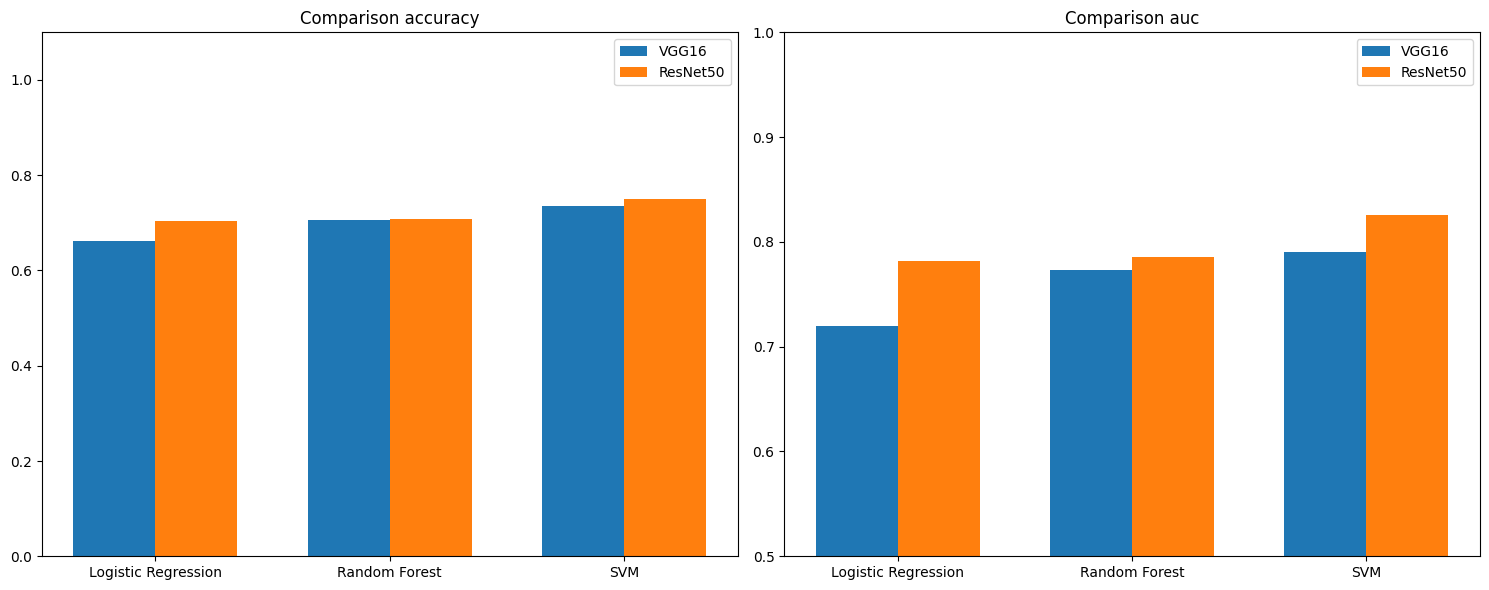

In [14]:
# Comparative visualization
def compare_results(vgg_res, resnet_res):
    metrics = ['accuracy', 'auc']
    models = list(vgg_res.keys())

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i, metric in enumerate(metrics):
        vgg_scores = [vgg_res[m][metric] for m in models]
        resnet_scores = [resnet_res[m][metric] for m in models]

        x = np.arange(len(models))
        width = 0.35

        axes[i].bar(x - width/2, vgg_scores, width, label='VGG16')
        axes[i].bar(x + width/2, resnet_scores, width, label='ResNet50')

        axes[i].set_xticks(x)
        axes[i].set_xticklabels(models)
        axes[i].set_title(f'Comparison {metric}')
        axes[i].legend()

        if metric == 'accuracy':
            axes[i].set_ylim(0, 1.1)
        else:
            axes[i].set_ylim(0.5, 1)

    plt.tight_layout()
    plt.show()

compare_results(vgg_results, resnet_results)

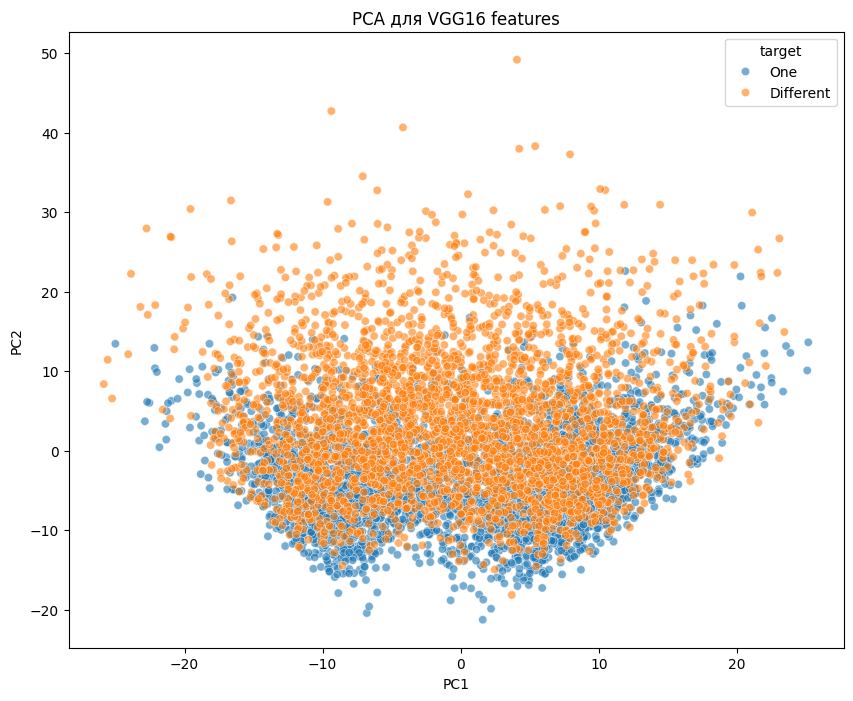

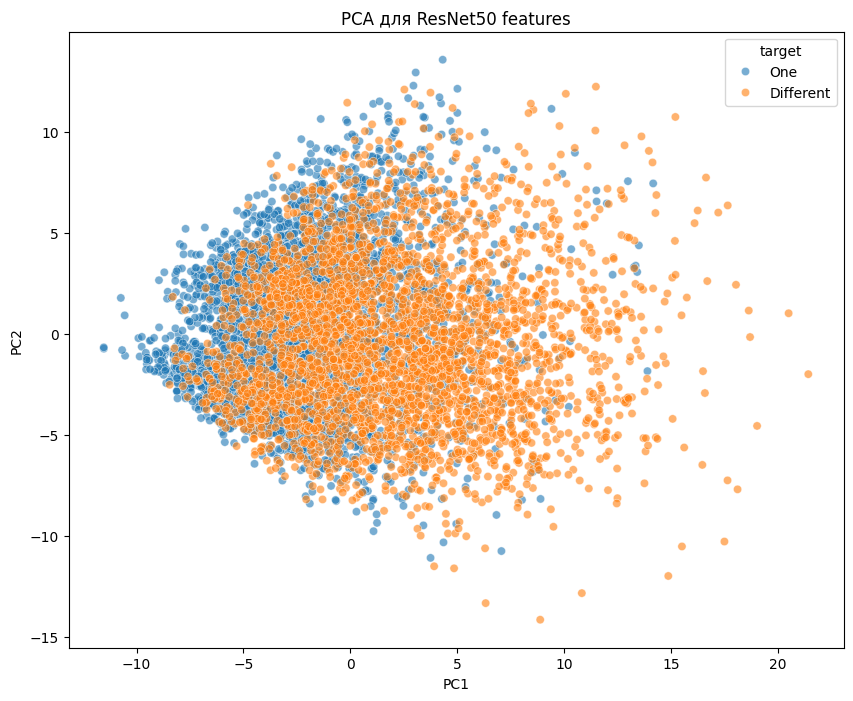

In [17]:
# PCA visualization for both methods
def plot_pca(X, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    vis_df = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1],
                          'target': ['One' if t == 1 else 'Different' for t in y]})

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x="PC1", y="PC2", hue='target', data=vis_df, alpha=0.6)
    plt.title(f"PCA для {title}")
    plt.show()

plot_pca(X_vgg, "VGG16 features")
plot_pca(X_resnet, "ResNet50 features")

# Visualization of results

In [18]:
data_path = '/root/.cache/kagglehub/datasets/juice0lover/face-identification/versions/5'

In [19]:
def visualize_predictions(model, model_type='vgg', n_examples=5):
    """
    Visualization of model predictions on random examples
    :param model: trained model
    :param model_type: 'vgg' or 'resnet' - type of features used
    :param n_examples: number of examples to display

    """

    # Setting seed for reproducibility
    np.random.seed(33)

    sample_indices = np.random.choice(len(df), n_examples, replace=False)

    # Select the required dictionary of features
    features_dict = vgg_features if model_type == 'vgg' else resnet_features


    gs = plt.GridSpec(n_examples, 3, width_ratios=[1, 0.3, 1], wspace=0.5, hspace=0.8)

    plt.figure(figsize=(20, 3*n_examples))

    for i, idx in enumerate(sample_indices):
        img1_path = os.path.join(data_path, df.iloc[idx]['image_1'])
        img2_path = os.path.join(data_path, df.iloc[idx]['image_2'])
        actual = df.iloc[idx]['target']

        # Extract features from the required dictionary
        feat1 = features_dict[df.iloc[idx]["image_1"]]
        feat2 = features_dict[df.iloc[idx]["image_2"]]
        features = np.abs(feat1 - feat2)

        # Making a prediction
        pred = model.predict([features])[0]
        proba = model.predict_proba([features])[0][1]

        # Loading images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        # First image (left column)
        ax1 = plt.subplot(gs[i, 0])
        ax1.imshow(img1)
        ax1.set_title(f"Image 1\n{os.path.basename(df.iloc[idx]['image_1'])}", pad=15, fontsize=12)
        ax1.axis('off')

        # Second image (right column)
        ax2 = plt.subplot(gs[i, 2])
        ax2.imshow(img2)
        ax2.set_title(f"Image 2\n{os.path.basename(df.iloc[idx]['image_2'])}", pad=15, fontsize=12)
        ax2.axis('off')

        # Prediction Information (Center)
        ax3 = plt.subplot(gs[i, 1])
        ax3.axis('off')

        is_correct = pred == actual
        color = 'red' if not is_correct else 'green'
        result_text = "SAME" if pred == 1 else "DIFFERENT"
        fact_text = "Same" if actual == 1 else "Different"

        ax3.text(0.5, 0.5,
                f"{result_text}\n\n"
                f"Confidence: {proba:.1%}\n"
                f"Fact: {'Same' if actual == 1 else 'Different'}\n"
                f"Model: {model_type.upper()}",
                ha='center', va='center', fontsize=12,
                bbox=dict(facecolor=color, alpha=0.3, boxstyle='round,pad=1'),
                transform=ax3.transAxes)

    plt.tight_layout(pad=4.0)
    plt.show()

In [20]:
# Choosing the best model
def get_best_model(results):
    best_name = max(results, key=lambda x: results[x]["accuracy"])
    return results[best_name]['model'], best_name

best_vgg_model, vgg_model_name = get_best_model(vgg_results)
best_resnet_model, resnet_model_name = get_best_model(resnet_results)

print(f"\nBest Model at VGG16: {vgg_model_name}")
print(f"\nBest model at ResNet50: {resnet_model_name}")


Best Model at VGG16: SVM

Best model at ResNet50: SVM



Examples of VGG16 predictions:


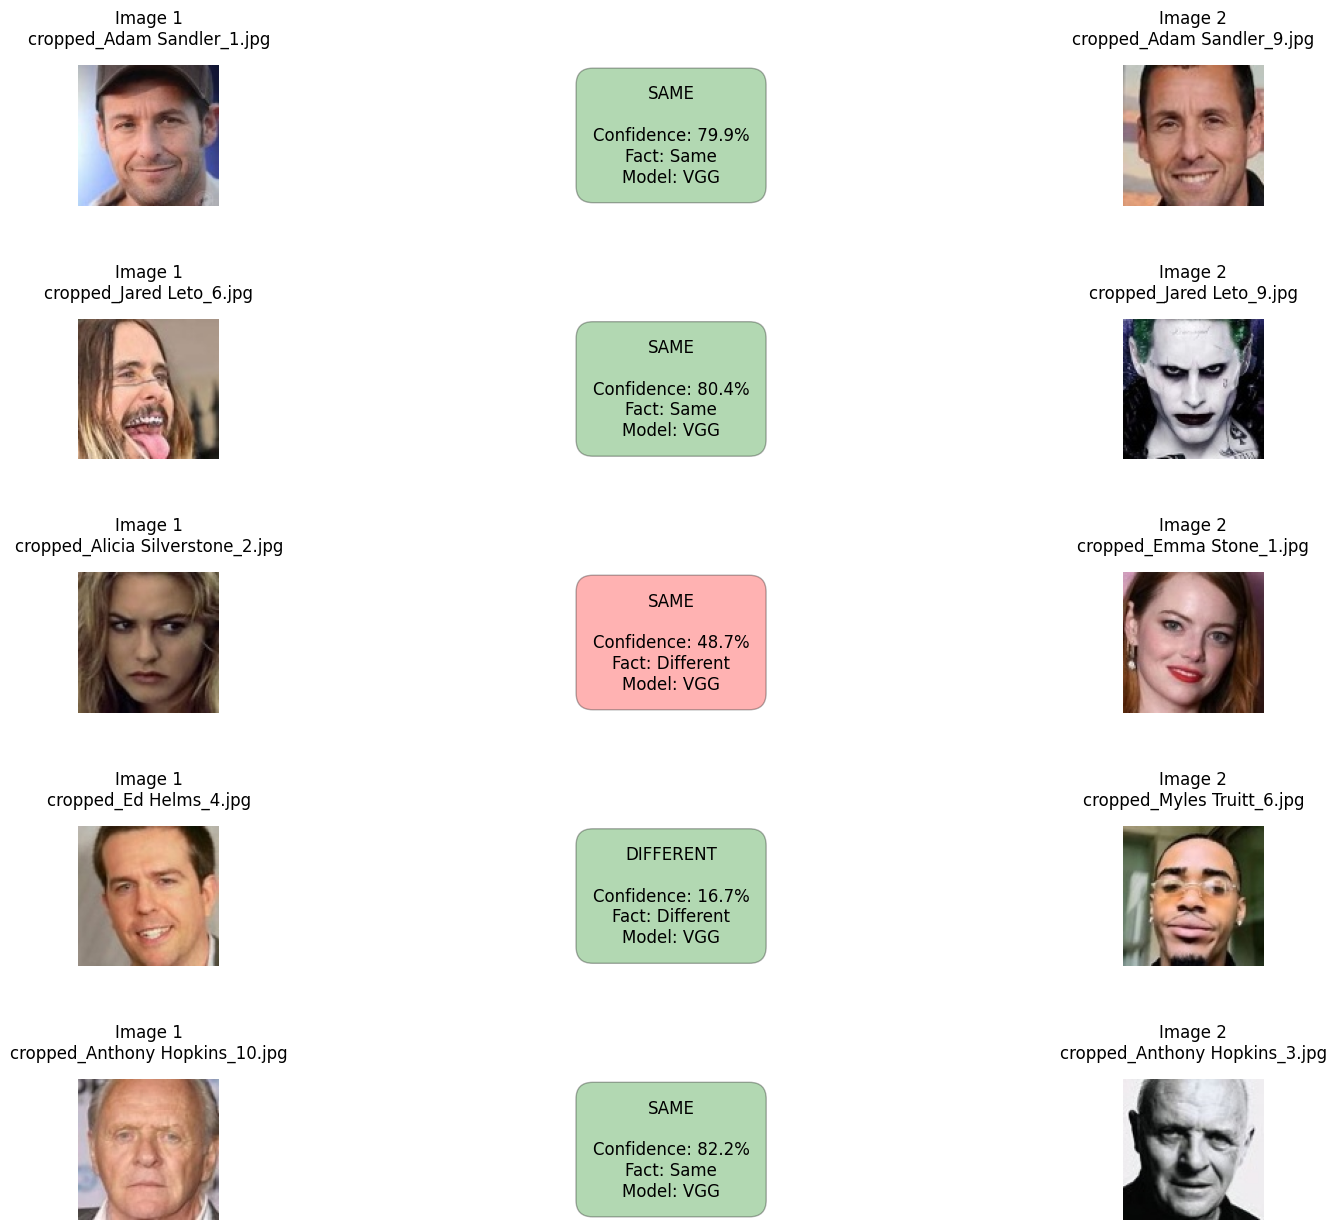

In [22]:
# Visualization of examples for both models
print("\nExamples of VGG16 predictions:")
visualize_predictions(best_vgg_model, model_type='vgg', n_examples=5)


Examples of ResNet50 predictions:


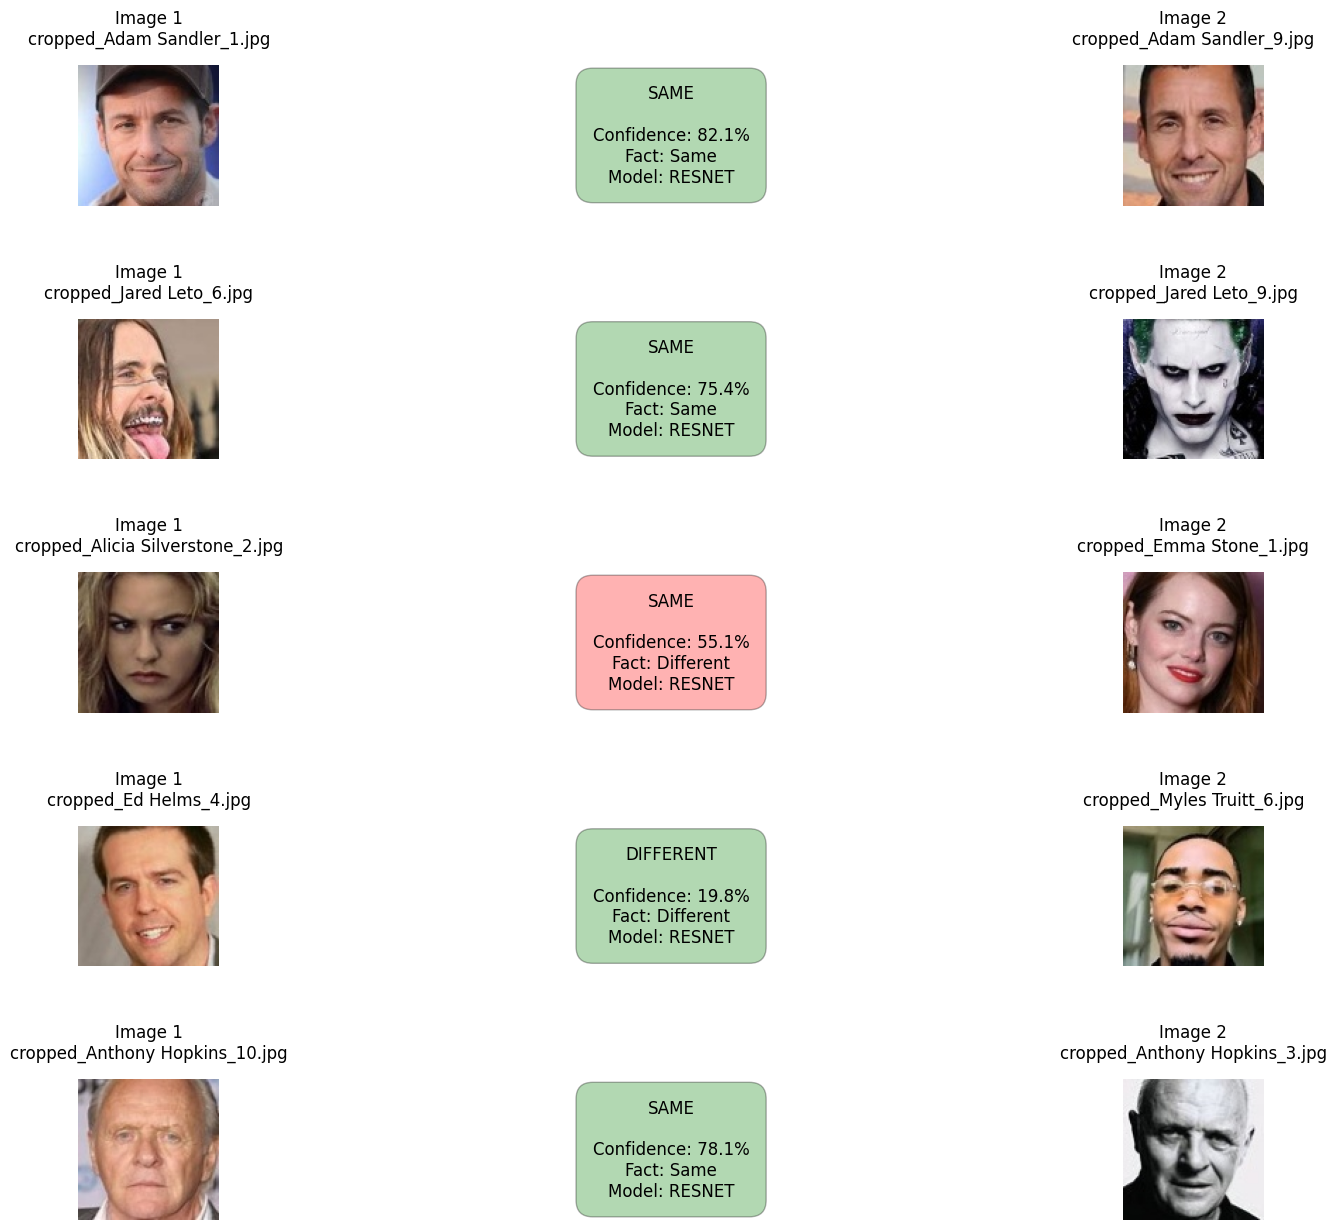

In [23]:
print("\nExamples of ResNet50 predictions:")
visualize_predictions(best_resnet_model, model_type='resnet', n_examples=5)